In [336]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [337]:
file  = "HSt42_10/RH80_PR10_1600day_startfrom_0day_final.dat"
ds = h5py.File(file, "r")
print(ds.keys())
# dycore = Dycore(file)
# u = dycore.getVar("grid_u_c_xyzt")
# # print(u.shape)

<KeysViewHDF5 ['_types', 'convection_xyzt', 'factor1_xyzt', 'factor2_xyzt', 'factor3_xyzt', 'factor4_xyzt', 'grid_div_xyzt', 'grid_geopots_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_c_xyzt', 'grid_ps_p_xyzt', 'grid_t_c_xyzt', 'grid_t_n_xyzt', 'grid_t_p_xyzt', 'grid_tracers_c_xyzt', 'grid_tracers_diff_xyzt', 'grid_tracers_n_xyzt', 'grid_tracers_p_xyzt', 'grid_u_c_xyzt', 'grid_u_n_xyzt', 'grid_u_p_xyzt', 'grid_v_c_xyzt', 'grid_v_n_xyzt', 'grid_v_p_xyzt', 'grid_vor_xyzt', 'grid_w_full_xyzt', 'grid_z_full_xyzt', 'grid_δtracers_xyzt', 'grid_δu_xyzt', 'grid_δv_xyzt', 'spe_div_c_xyzt', 'spe_div_p_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_t_c_xyzt', 'spe_t_p_xyzt', 'spe_tracers_c_xyzt', 'spe_tracers_p_xyzt', 'spe_vor_c_xyzt', 'spe_vor_p_xyzt']>


In [338]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.u_p  = self.getVar("grid_u_p_xyzt")
        self.u_n  = self.getVar("grid_u_n_xyzt")
        
        
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_c_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyzt")
        self.qv_p = self.getVar("grid_tracers_p_xyzt")
        self.qv_n = self.getVar("grid_tracers_n_xyzt")
        
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        # self.factor4 = self.getVar("factor4_xyzt")


        self.convection = self.getVar("convection_xyzt")
        
        # self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        # self.Uzm   = np.nanmean(self.u, axis=3)
        # self.Vzm   = np.nanmean(self.v, axis=3)
        # self.THzm  = np.nanmean(self.theta, axis=3)
        # self.Pzm   = np.nanmean(self.p, axis=3)
        # self.Tzm   = np.nanmean(self.t, axis=3)
        
        # ### anamoly
        # self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        # self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        # self.THzmtm = np.nanmean(self.THzm, axis=0)
        # self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        # self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        # self.Vza     = np.zeros(self.u.shape)
        # self.Uza     = np.zeros(self.u.shape)
        # self.THETAza = np.zeros(self.u.shape)
        # self.Pza     = np.zeros(self.u.shape)
        # self.Tza     = np.zeros(self.t.shape)

        # for i in range(0,128):
        #     self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
        #     self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
        #     self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
        #     self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
        #     self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        # self.xx, self.yy = np.meshgrid(self.x,self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p_half[:,i+1,:,:] - self.p_half[:,i,:,:])
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p_half[:, 1,:,:] - self.p_half[:, 0,:,:])
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(0,2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

In [339]:
def read_all_var(pr, start, end, internal_day, total_file):
    qv_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    qv_diff_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    u_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    v_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    t_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    p_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    ps_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    
    p_half_all = np.zeros(((total_file, 100, 21 , 64, 128)))
    a = 0
    for day in range(start,end,internal_day):
        print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1600day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        
        qv_all[a,:,:,:,:]   = dycore.qv
        qv_diff_all[a,:,:,:,:]   = dycore.qv_diff
        u_all[a,:,:,:,:]    = dycore.u
        v_all[a,:,:,:,:]    = dycore.v
        t_all[a,:,:,:,:]    = dycore.t
        p_all[a,:,:,:,:]    = dycore.p
        ps_all[a,:,:,:,:]   = dycore.ps
        
        p_half_all[a,:,:,:,:]    = dycore.p_half
        a += 1
        # print(a)
    # qv_all_new      = np.nanmean(qv_all  , axis=0)
    # qv_diff_new      = np.nanmean(qv_diff_all  , axis=0)
    # u_new      = np.nanmean(u_all  , axis=0)
    # v_new      = np.nanmean(v_all  , axis=0)
    # t_new      = np.nanmean(t_all  , axis=0)
    # p_new      = np.nanmean(p_all  , axis=0)
    # p_half_new      = np.nanmean(p_half_all  , axis=0)
    


    # qv = qv_all
    # qv_diff = qv_diff_new
    # u = u_new
    # v = v_new
    # t = t_new
    # p = p_new
    # p_half = p_half_new
    return qv_all, qv_diff_all, u_all, v_all, t_all, p_all, ps_all, p_half_all

In [340]:
def cal_pre(qv_diff, p_half):
    g = 9.81
    Prec = np.zeros(qv_diff.shape)
    for i in range(1,20-1):
        Prec[:,i,:,:] = 1/g * qv_diff[:,i,:,:] * (p_half[:,i+1,:,:] - p_half[:,i,:,:])
    Prec[:, 0,:,:] = 1/g * qv_diff[:, 0,:,:] * (p_half[:, 1,:,:] - p_half[:, 0,:,:])
    # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
    
    Prec_mean = np.nansum(Prec, axis=(1))
    Prec_mean2 = np.nanmean(Prec_mean, axis=(2))
    
    return Prec_mean2

In [341]:
def cal_KE(u, v):
    KE = (u**2 + v**2)
    KE_mean = np.nanmean(KE, axis=(1,3))
    return KE_mean

1600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


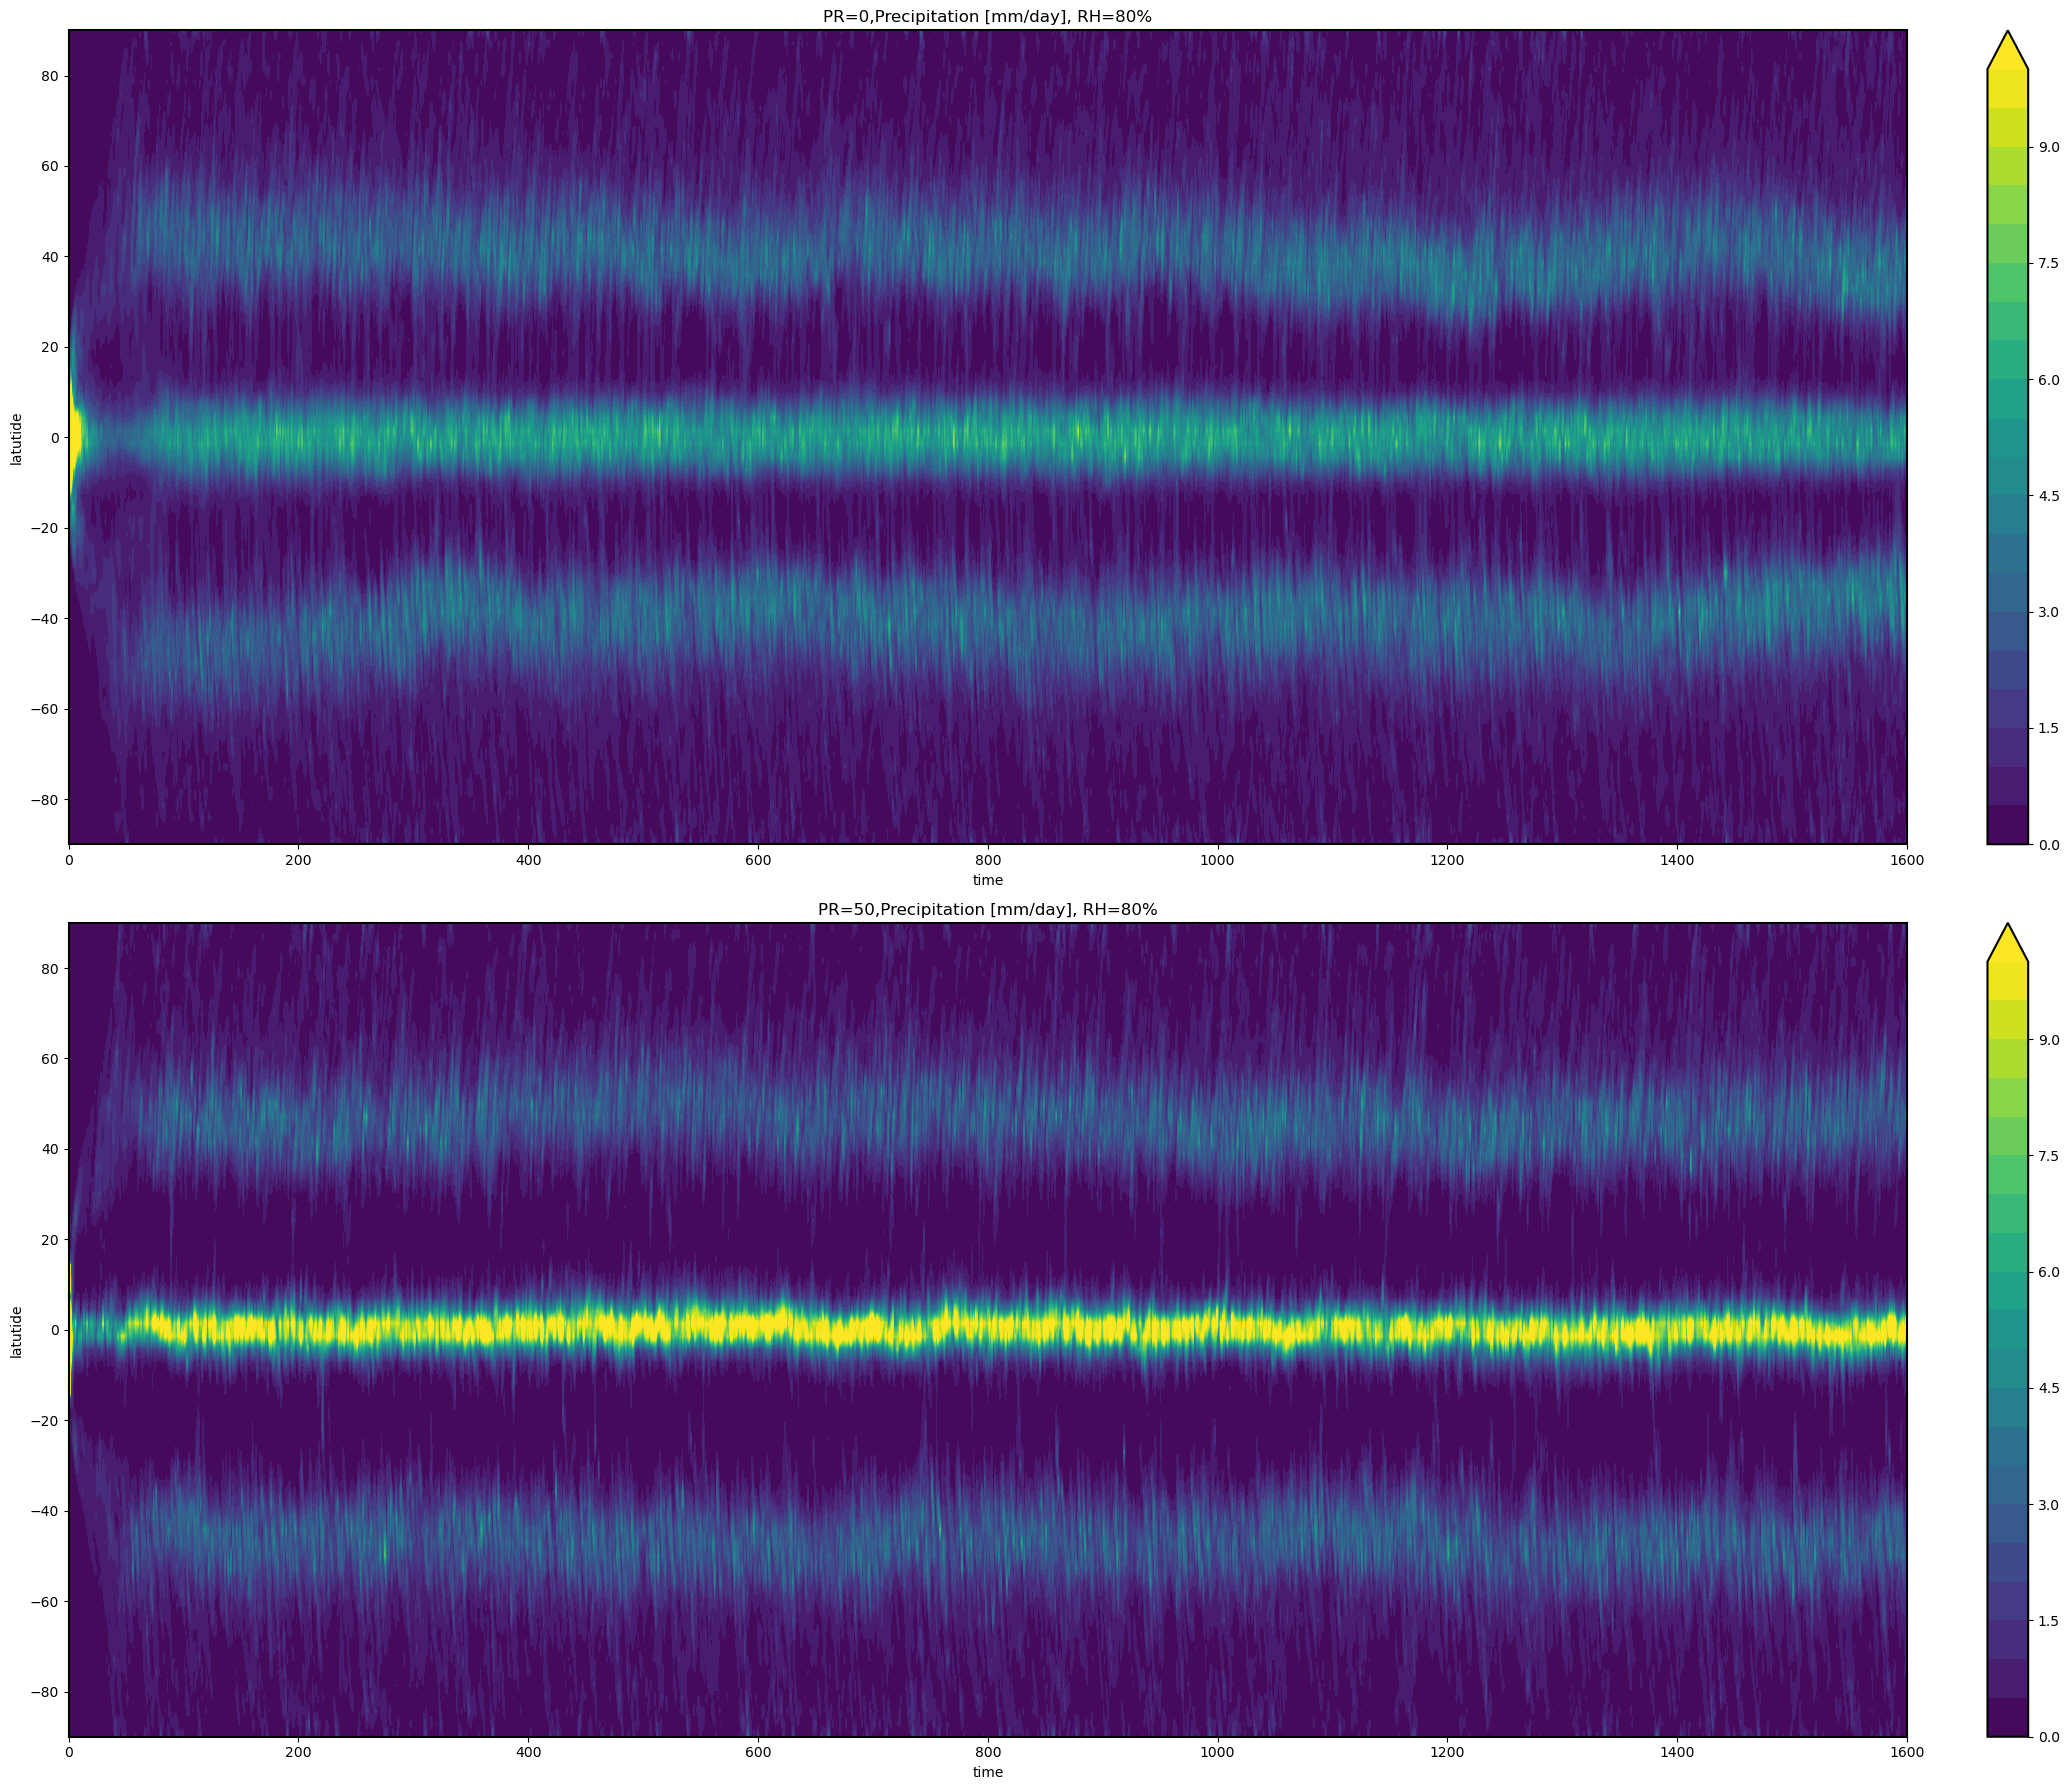

done


In [311]:
pr_start = 0
pr_leap = 50
pr_to = 100
nProc = 2

start = 0
end   = 1600
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
print(total_day)


qv = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))

### fig
y = np.linspace(-90,90,64)
time = np.linspace(start, end, total_day)
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
#########

do_check_qv = True
do_check_KE = False
do_check_t  = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_qv:
            if k ==0:
                qv[0:100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[0:100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[0:100,:,:,:]       = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]      = ps_ini[k,:,:,:,:]
                p_half[0:100,:,:,:]  = p_half_ini[k,:,:,:,:]            
            else:
                qv[k*100:(k+1)*100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:]       = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:]      = ps_ini[k,:,:,:,:]
                p_half[k*100:(k+1)*100,:,:,:]  = p_half_ini[k,:,:,:,:]
                
        if do_check_KE:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]            = ps_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:]  = u_ini[k,:,:,:,:]
                v[k*100:(k+1)*100,:,:,:]  = v_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:]  = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                
        if do_check_t:
            if k ==0:
                t[0:100,:,:,:]           = t_ini[k,:,:,:,:]
            else:
                t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
                
                

    if do_check_qv:
        Prec_new   = cal_pre(qv_diff, p_half)
        CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")    
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
        ax[a].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_KE:
        get_KE = cal_KE(u, v)   
        CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(60,1200,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_t:
        t_mean = np.nanmean(t[:,:,:,:], axis=(1,3))
        CS = ax[a].contourf(tt, yy, t_mean,levels=21, extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Temperature [K], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
        
        
if do_check_qv:
    fig.tight_layout()
    # plt.savefig("check_qv_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_KE:
    fig.tight_layout()
    # plt.savefig("check_KE_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_t:
    fig.tight_layout()
    # plt.savefig("check_T_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()

    #     print(result.shape)
    #     print(result)
    # EMF_80[a,:] = EMF_results[32:]
    # EQF_80[a,:] = EQF_results[32:]
    # EHF_80[a,:] = EHF_results[32:]
    # EKF_80[a,:] = EKF_results[32:]
    # prec_80[a,:]  = prec_results[:] #* float(t)
print("done")

# Calculate EOF of u, then plot y-z 

In [347]:
from EOF import EOF

In [348]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
cy = np.cos(yd)
# cy [0] = np.nan
# cy [-1] = np.nan
cy

array([6.12323400e-17, 4.98458857e-02, 9.95678466e-02, 1.49042266e-01,
       1.98146143e-01, 2.46757398e-01, 2.94755174e-01, 3.42020143e-01,
       3.88434796e-01, 4.33883739e-01, 4.78253979e-01, 5.21435203e-01,
       5.63320058e-01, 6.03804410e-01, 6.42787610e-01, 6.80172738e-01,
       7.15866849e-01, 7.49781203e-01, 7.81831482e-01, 8.11938006e-01,
       8.40025923e-01, 8.66025404e-01, 8.89871809e-01, 9.11505852e-01,
       9.30873749e-01, 9.47927346e-01, 9.62624247e-01, 9.74927912e-01,
       9.84807753e-01, 9.92239207e-01, 9.97203797e-01, 9.99689182e-01,
       9.99689182e-01, 9.97203797e-01, 9.92239207e-01, 9.84807753e-01,
       9.74927912e-01, 9.62624247e-01, 9.47927346e-01, 9.30873749e-01,
       9.11505852e-01, 8.89871809e-01, 8.66025404e-01, 8.40025923e-01,
       8.11938006e-01, 7.81831482e-01, 7.49781203e-01, 7.15866849e-01,
       6.80172738e-01, 6.42787610e-01, 6.03804410e-01, 5.63320058e-01,
       5.21435203e-01, 4.78253979e-01, 4.33883739e-01, 3.88434796e-01,
      

2
8
800
900
1000
1100
1200
1300
1400
1500
(800, 1280)
800
900
1000
1100
1200
1300
1400
1500
(800, 1280)


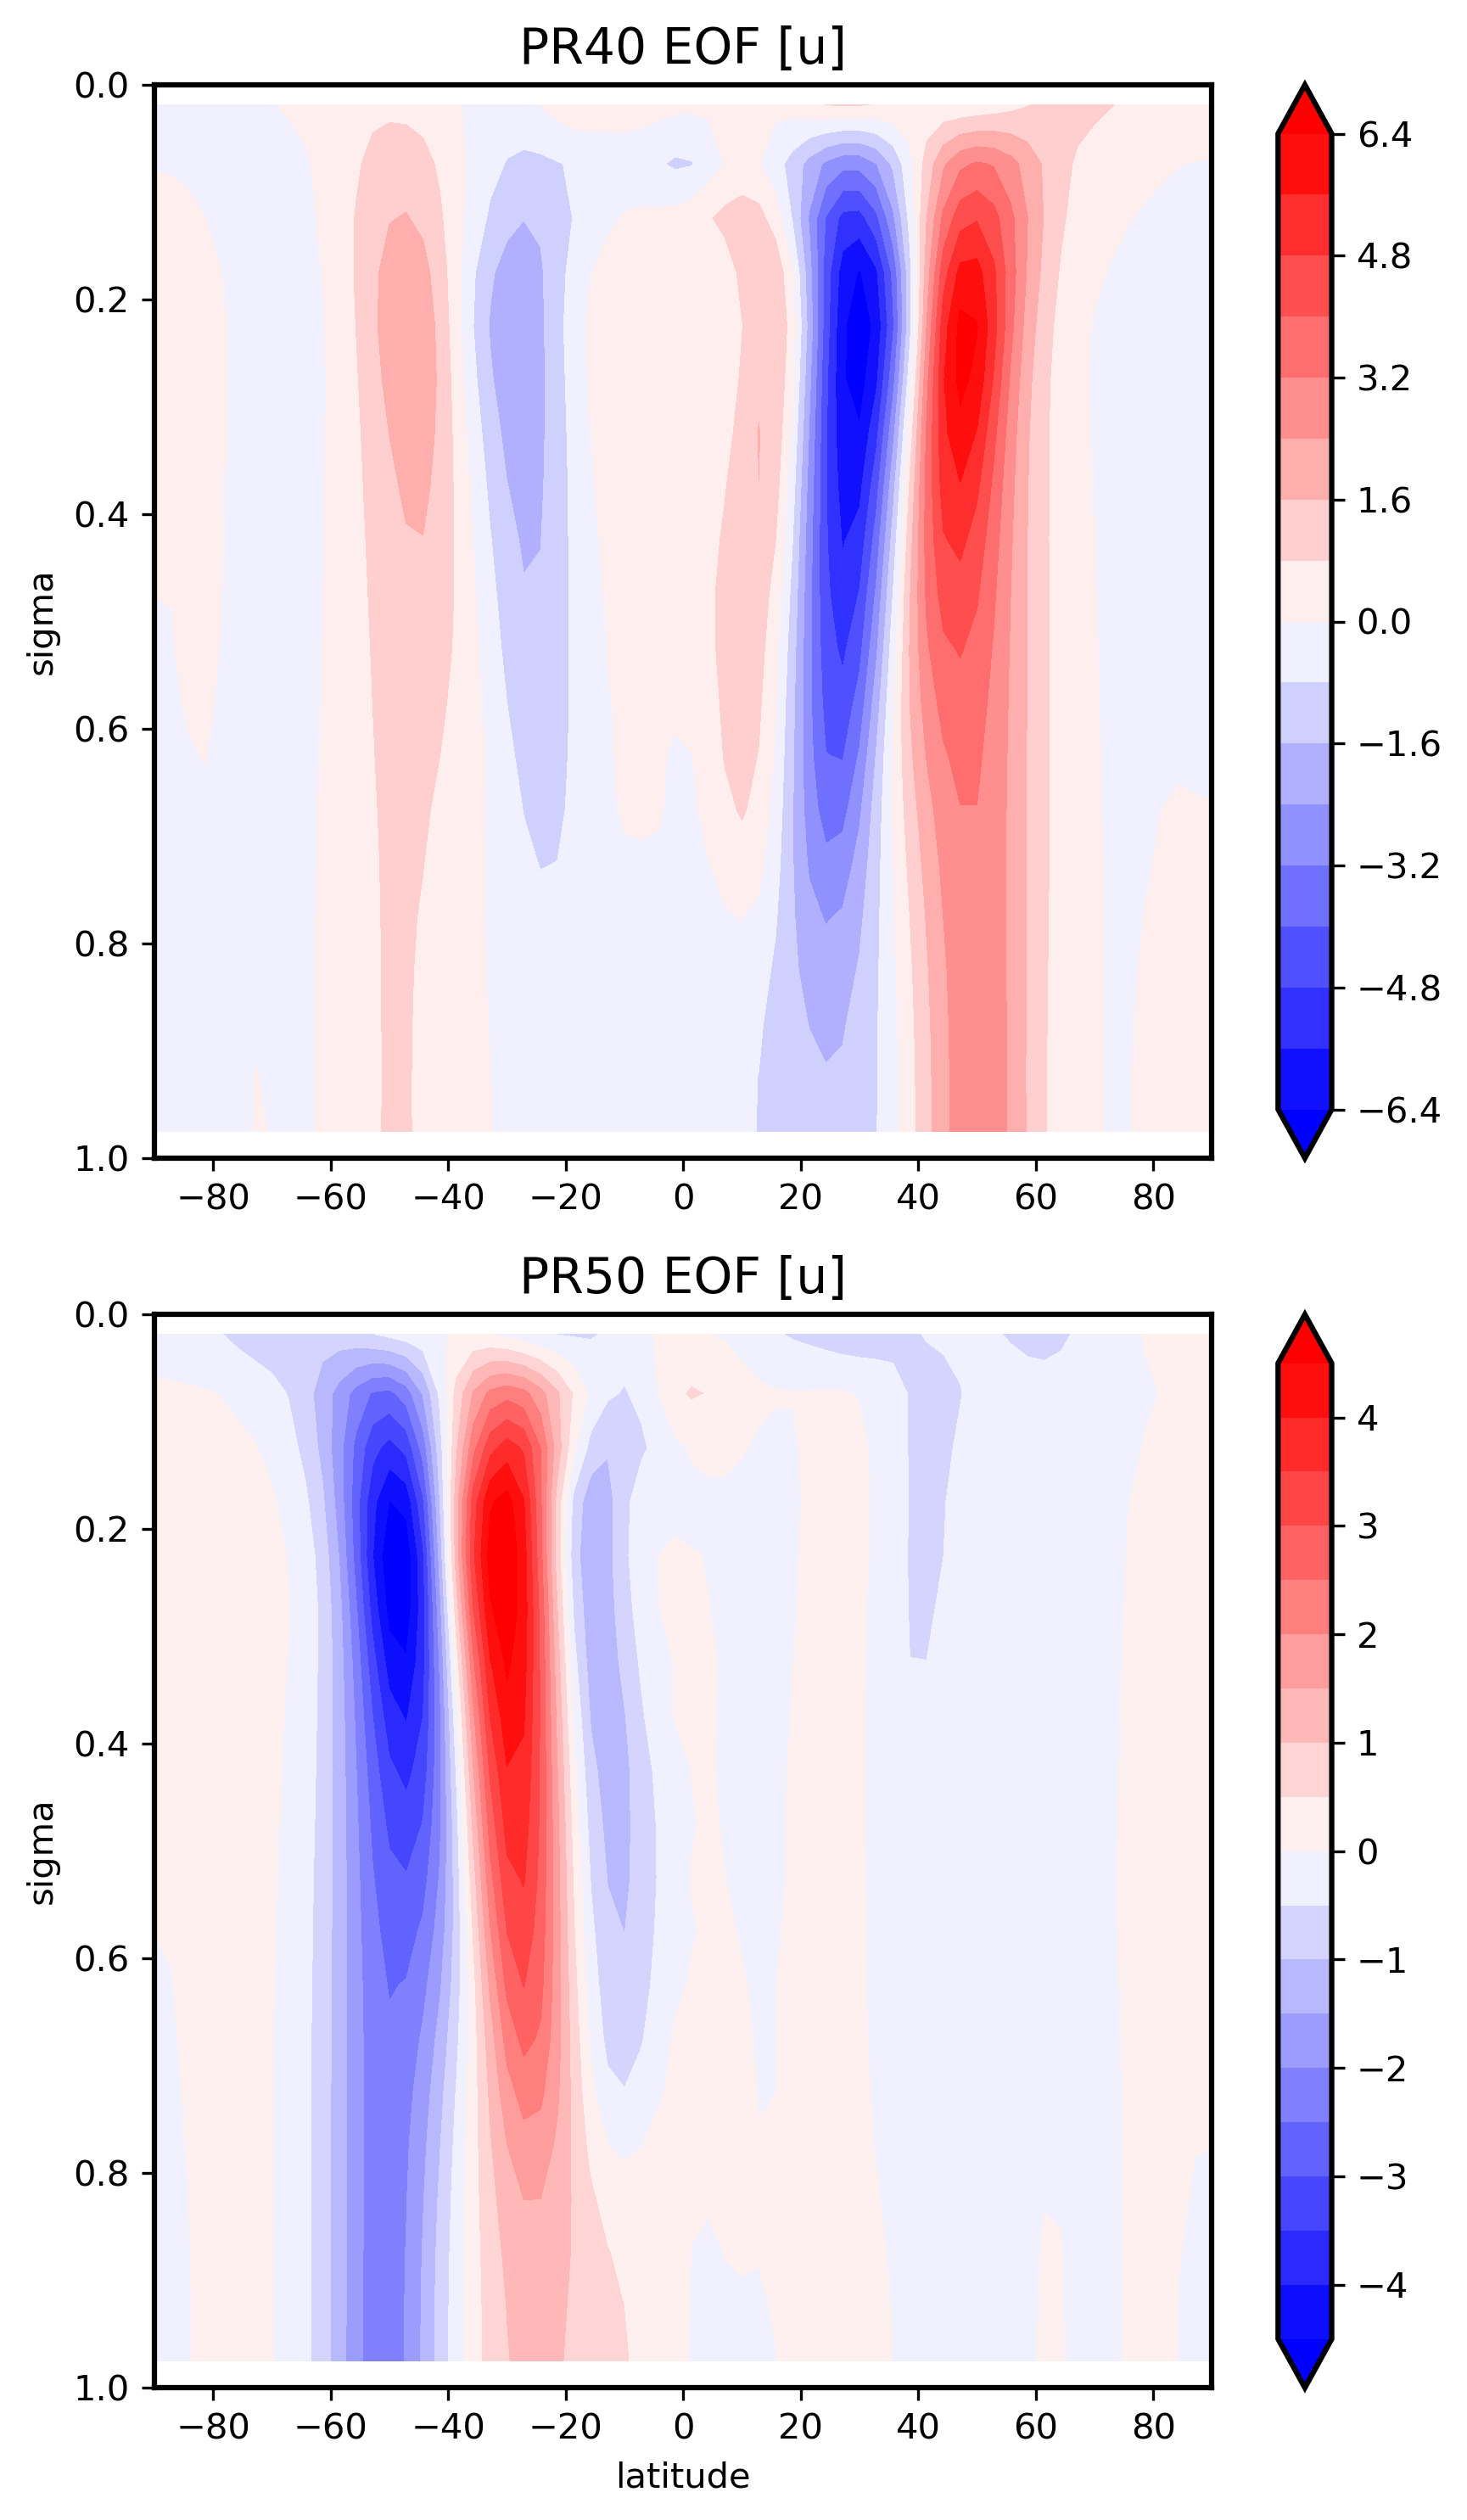

In [349]:
pr_start = 40
pr_leap = 10
pr_to = 60


### fig
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(6,10), dpi=300.)
print(int((pr_to - pr_start)/pr_leap))
#########

start = 800
end   = 1600
internal_day = 100
total_file = int((end - start) / internal_day)
print(total_file)
total_day = int(total_file*internal_day)
total_pr  = int((pr_to - pr_start) / pr_leap)


u = np.zeros((((total_day, 20, 64, 128))))


# do_check_u_EOF = True
check_days_length = int(end - start)

sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

EOF1_all = np.zeros(((total_pr, 20, 64)))
EOF2_all = np.zeros(((total_pr, 20, 64)))


PC1_all = np.zeros((total_pr, total_day))
PC2_all = np.zeros((total_pr, total_day))


a = 0
for pr in range(pr_start, pr_to, pr_leap):
    # qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    # for k in range(total_file):
    #         # if k ==0:
    #         #     u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
          
    #         # else:
    #             u[k*100:(k+1)*100,:,:,:]   = u_ini[k,:,:,:,:]
    # qv_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    # qv_diff_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    # u_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    # v_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    # t_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    # p_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    # ps_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    
    # p_half_all = np.zeros(((total_file, 100, 21 , 64, 128)))
    k = 0
    for day in range(start,end,internal_day):
        print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1600day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        
        # qv_all[a,:,:,:,:]   = dycore.qv
        # qv_diff_all[a,:,:,:,:]   = dycore.qv_diff
        # u_all[a,:,:,:,:]    = dycore.u
        # v_all[a,:,:,:,:]    = dycore.v
        u[k*100:(k+1)*100,:,:,:]   = dycore.u #[k,:,:,:,:]
        v[k*100:(k+1)*100,:,:,:]   = dycore.v #[k,:,:,:,:]
        
        # t_all[a,:,:,:,:]    = dycore.t
        # p_all[a,:,:,:,:]    = dycore.p
        # ps_all[a,:,:,:,:]   = dycore.ps
        
        # p_half_all[a,:,:,:,:]    = dycore.p_half
        k += 1
    u_w = np.zeros(u.shape)
    for i in range(np.shape(u)[0]): # cy[0] and [-1] are np.nan
        for j in range(np.shape(u)[1]):
            for k in range(np.shape(u)[3]):
                u_w[i,j,:,k] = u[i,j,:,k] * (cy[:])**0.5
    # for i in range(64): # cy[0] and [-1] are np.nan
    #     u_w[:,:,i,:] = u[:,:,i,:] * (cy[i])**0.5
    u_zy = np.nanmean(u_w[:,:,:,:], axis=(3))
    u_zy_reshape = np.reshape(u_zy, (np.shape(u_zy)[0], 20*64))
    print(u_zy_reshape.shape)
    # Step 2: do EOF of u
    single_EOF = EOF((u_zy_reshape,), n_components=300, field="1D")
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs    = single_EOF.PC[0,:]
    PC2s   = single_EOF.PC[1,:]
    
    EOFs   = single_EOF.EOF[0,:]
    EOF2s  = single_EOF.EOF[1,:]
    
    
    PCs_std = PCs.std()
    PCs     = PCs / PCs_std

    PC2s_std = PC2s.std()
    PC2s     = PC2s / PC2s_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std

    EOF2s_std  = EOF2s.std()
    EOF2s      = EOF2s * PC2s_std
    # Step 4: reshape (1280,) back to (20,64)
    EOFs_zy  = np.reshape(EOFs, (20,64))
    EOF2s_zy = np.reshape(EOF2s, (20,64))
    
    EOF1_all[a,:,:] = EOFs_zy
    EOF2_all[a,:,:] = EOF2s_zy

    PC1_all[a,:] = PCs
    PC2_all[a,:] = PC2s



    # Step 5: plot
    CS = ax[a].contourf(yy, sigma_mean2, EOFs_zy, levels=21, cmap="bwr", extend="both")
    fig.colorbar(CS, ax=ax[a], extend="both")
    ax[a].set_ylim([1,0])
    ax[a].set_title(f"PR{pr} EOF [u]", fontsize=14)
    ax[a].set_ylabel("sigma")
    ax[-1].set_xlabel("latitude")
    a += 1
fig.tight_layout()
# plt.savefig("check_U_EOF.png", dpi=300., bbox_inches='tight')
plt.show()
    # if do_check_u_EOF:
    #     Prec_new   = cal_pre(qv_diff, p_half)
    #     CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")    
    #     fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
    #     ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
    #     ax[a].set_xlabel("time")
    #     ax[a].set_ylabel("latutide")
    #     a += 1

Text(0.5, 1.0, 'u, PR=50')

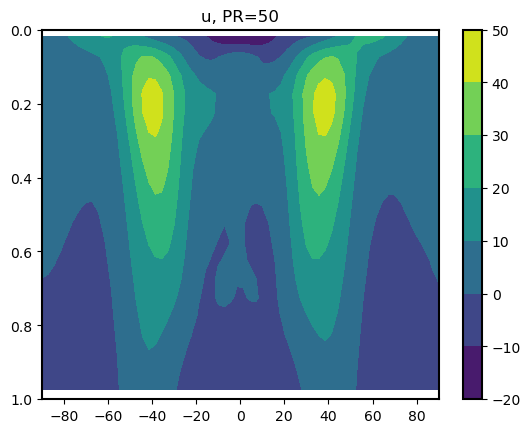

In [350]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, np.nanmean(u, axis=(0,3)))
plt.ylim([1,0])
plt.colorbar(CS)
plt.title("u, PR=50")

In [216]:
single_EOF = EOF((np.nanmean(u_w, axis=3),), n_components=check_days_length, field="2D")
single_EOF.get()
EOF_try = single_EOF.EOF[0,:]

In [219]:
print(EOF_try.shape)
EOF_try_zy = np.reshape(EOF_try, (20,64))
EOF_try_zy_reshape = np.reshape(EOF_try_zy, (20,64))

(1280,)


In [313]:
yy.shape

(20, 64)

(800, 1280)


In [229]:
u_zy_reshape.shape

(800, 1280)

(1.0, 0.0)

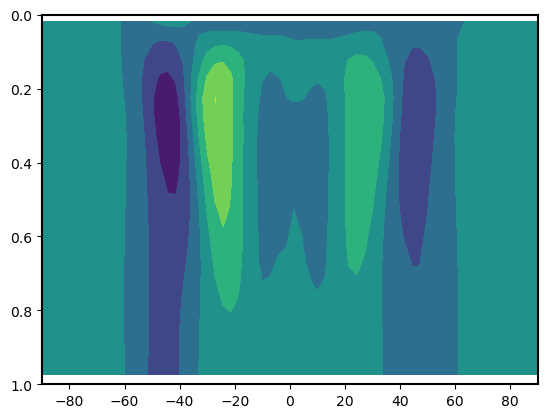

In [238]:
plt.figure()
plt.contourf(yy, sigma_mean, EOF2_all[0])
plt.ylim([1,0])

Text(0.5, 1.0, 'Original u')

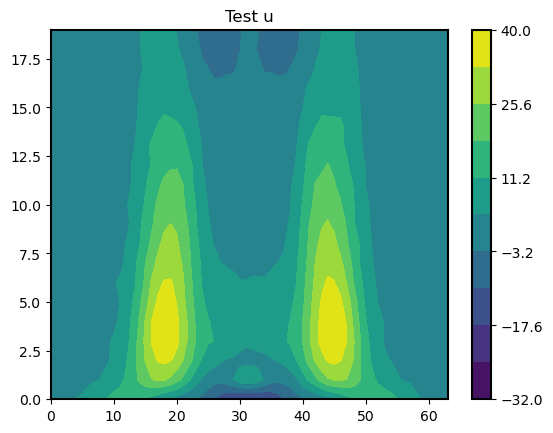

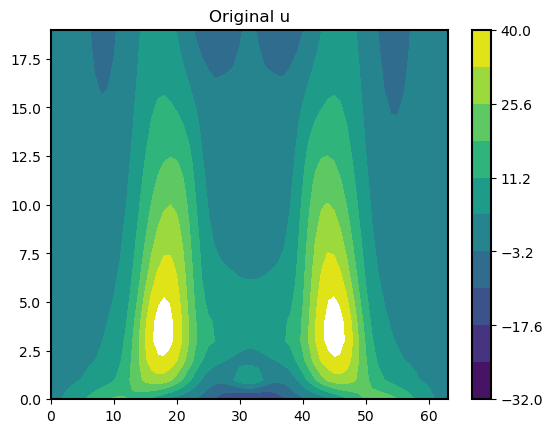

In [242]:
plt.figure()
test = (single_EOF.EOF.T.dot(single_EOF.PC)).T
test_mean = np.nanmean(test, axis=0)
test_final = np.reshape(test_mean, (20,64))
CS1 = plt.contourf(test_final, levels=np.linspace(-32,40,11))

plt.title("Test u") 
plt.colorbar(CS1)
plt.figure()
CS = plt.contourf(np.nanmean(u, axis=(0,3)), levels=np.linspace(-32,40,11))
plt.colorbar(CS)
plt.title("Original u") 


(1.0, 0.0)

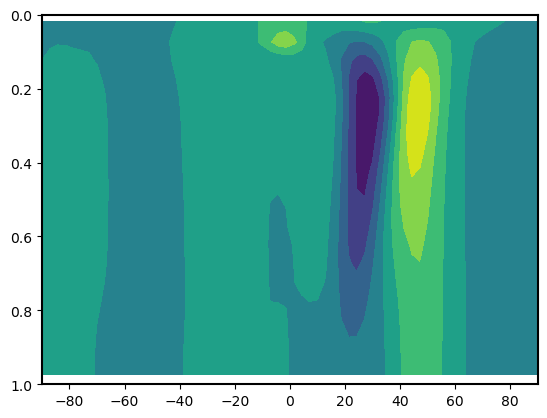

In [201]:
plt.figure()
plt.contourf(yy, sigma_mean2, EOF_try_zy)
plt.ylim([1,0])

(1.0, 0.0)

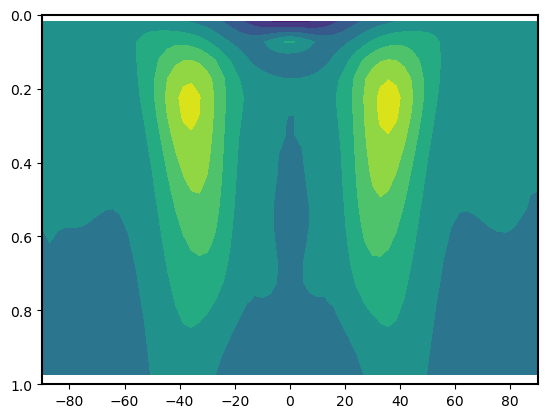

In [202]:
plt.figure()
plt.contourf(yy, sigma_mean2, np.nanmean(u_w[:,:,:,:], axis=(0,3)))
plt.ylim([1,0])

(1.0, 0.0)

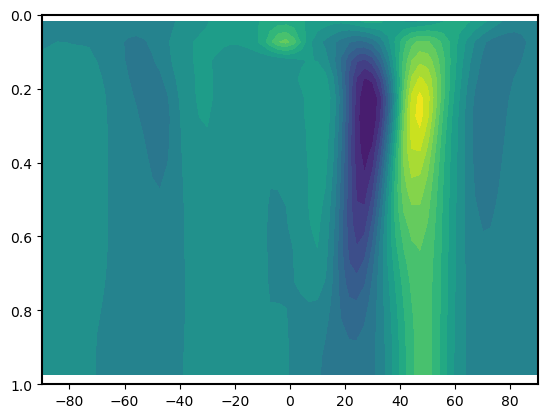

In [175]:
# u.shape
plt.figure()
CS = plt.contourf(yy, sigma_mean, EOFs_zy, levels=21)
plt.ylim([1,0])


(20, 64)


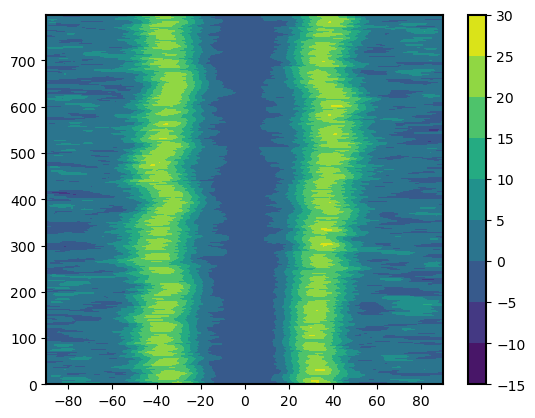

In [177]:
plt.figure()
u_mean = np.nanmean(u[:,:,:,:], axis=(1,3))
time = np.arange(0,800,1)
yy_time, tt = np.meshgrid(y, time)
print(yy.shape)
CS = plt.contourf(yy_time, tt, u_mean)
plt.colorbar(CS)
# CS = plt.contourf(yy, sigma_mean2, u_mean, levels=21, cmap="bwr", extend="both")
# plt.ylim([1,0])

In [351]:
EOF1_all.shape
EOF2_all.shape
# Do EOF1 and EOF2 interpolaiton
from scipy.interpolate import RectBivariateSpline
check_days_length = 800
interpolation_times = 10
sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

yys          = np.linspace(0, 90, 32*interpolation_times)
sigma_mean2s = np.linspace(0,  1, 20*interpolation_times)




In [359]:
check_05percentage = True
check_1percentage  = False
check_5percentage  = False
check_10percentage = False
if check_05percentage:
    if pr_leap ==5:
        y_pr0 = 37.53855211598746
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[2] = 0.245966425879397
        z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[4] = 0.2404396827889447
        z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[6] = 0.2302165672110553
        z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[8] = 0.21822737123115576
        z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[10] = 0.20429698492462314
        
        
    else:
        y_pr0 = 37.53855211598746
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        # z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[1] = 0.245966425879397
        # z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[2] = 0.2404396827889447
        # z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[3] = 0.2302165672110553
        # z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[4] = 0.21822737123115576
        # z_biggest_all[9] = 0.2113334798994975
        # z_biggest_all[5] = 0.20429698492462314

if check_1percentage:
    if pr_leap == 5:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.2504103093592965
        z_biggest_all[2] = 0.25088522298994975
        z_biggest_all[3] = 0.24788092807788945
        z_biggest_all[4] = 0.24516175408291457
        z_biggest_all[5] = 0.23950071451005026
        z_biggest_all[6] = 0.23397497644472362
        z_biggest_all[7] = 0.2242414337311558
        z_biggest_all[8] = 0.21955492305276383
        z_biggest_all[9] = 0.21416552292713567
        z_biggest_all[10] = 0.20697050879396983
    else:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.25088522298994975
        z_biggest_all[2] = 0.24516175408291457
        # z_biggest_all[3] = 0.23397497644472362
        # z_biggest_all[4] = 0.21955492305276383
        # z_biggest_all[5] = 0.20697050879396983
    
    
if check_10percentage:
    y_pr0 = 36.228926875979624
    z_biggest_all = np.zeros(total_pr)
    z_biggest_all[0] = 0.3238856163630653
    z_biggest_all[1] = 0.32541720398869345
    z_biggest_all[2] = 0.33223640625
    z_biggest_all[3] = 0.3252315201005025
    z_biggest_all[4] = 0.32447135364321605
    z_biggest_all[5] = 0.3121236958228643
    z_biggest_all[6] = 0.3052737688442211
    z_biggest_all[7] = 0.2859219904208543

if check_5percentage:
    y_pr0 = 36.5939329937304
    z_biggest_all = np.zeros(total_pr)
    z_biggest_all[0] = 0.28572386149497486
    z_biggest_all[1] = 0.2872950973618091
    z_biggest_all[2] = 0.29088036903266334
    z_biggest_all[3] = 0.2857038599246231
    z_biggest_all[4] = 0.2842567258165829
    z_biggest_all[5] = 0.27495892430904517
    z_biggest_all[6] = 0.2675492022613066
    z_biggest_all[7] = 0.252779739321608

IndexError: index 2 is out of bounds for axis 0 with size 2

In [297]:
print(z_biggest_all)
print(biggest_u_z_idx)

[0.24557166 0.24596643 0.24043968 0.23021657 0.21822737]
43


0.0
1.0
2.0
3.0
4.0


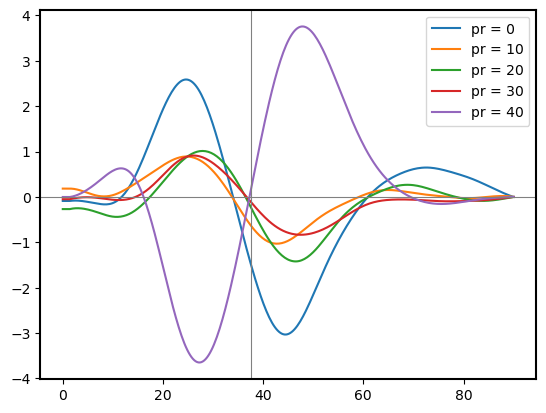

In [299]:
plt.figure()
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[a])
    print(pr/pr_leap)
    # print(biggest_u_z_idx)
    
    interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], EOF1_all[a,:,32:])
    EOF1_all_thin = interp_spline(sigma_mean2s, yys)
    # if pr == 10:    
        # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    # else:
    # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    plt.plot(yys, np.nanmean(EOF1_all_thin[:, :], axis=0), label=f"pr = {a*pr_leap}")
    
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.axhline(y=0, color='gray', lw=0.8)
plt.legend()

0.0
1.0
2.0
3.0
4.0
5.0


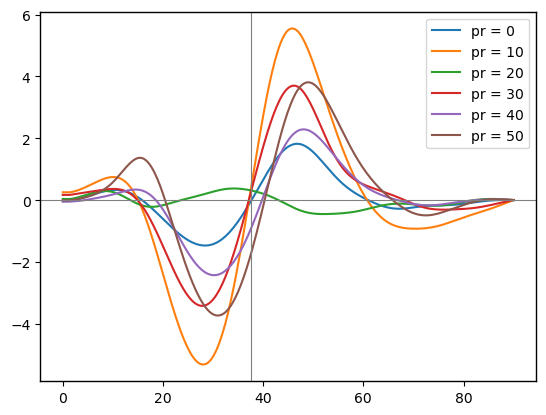

In [939]:
plt.figure()
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[a])
    print(pr/pr_leap)
    # print(biggest_u_z_idx)
    
    interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], EOF2_all[a,:,32:])
    EOF2_all_thin = interp_spline(sigma_mean2s, yys)
    # if pr == 10:    
        # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    # else:
    plt.plot(yys, EOF2_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    # plt.plot(y[:], EOF2_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.axhline(y=0, color='gray', lw=0.8)
plt.legend()

Text(0.5, 0, 'Day')

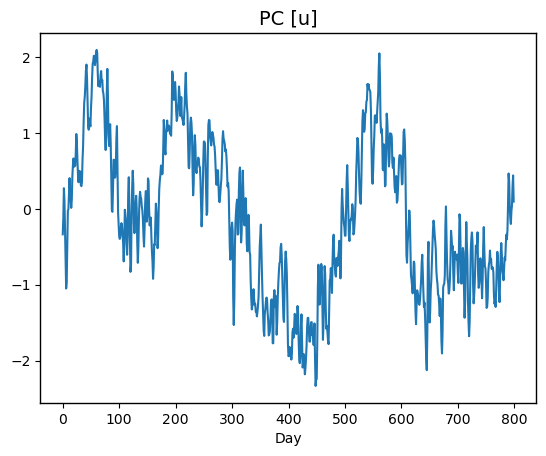

In [940]:
plt.figure()
plt.plot(PCs)
# plt.ylim([1,0])
plt.title("PC [u]", fontsize=14)
# plt.ylabel("sigma")
plt.xlabel("Day")

(1.0, 0.0)

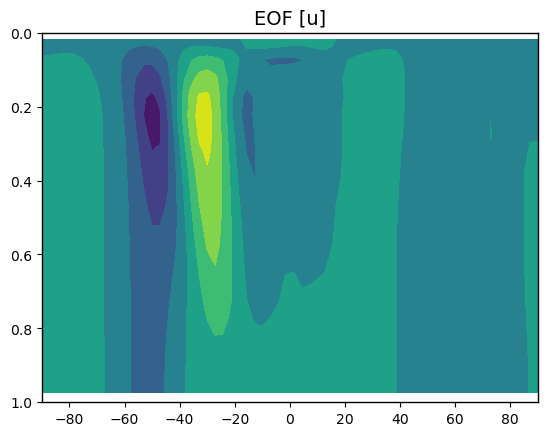

In [941]:
plt.figure()
# EOFs_final = np.reshape(EOFs, (20,64))
plt.contourf(yy, sigma_mean2,EOFs_zy[:,:])
# plt.ylim([1,0])
plt.title("EOF [u]", fontsize=14)
# plt.ylabel("sigma")
# plt.xlabel("Day")
plt.ylim([1,0])

TypeError: Input z must be 2D, not 1D

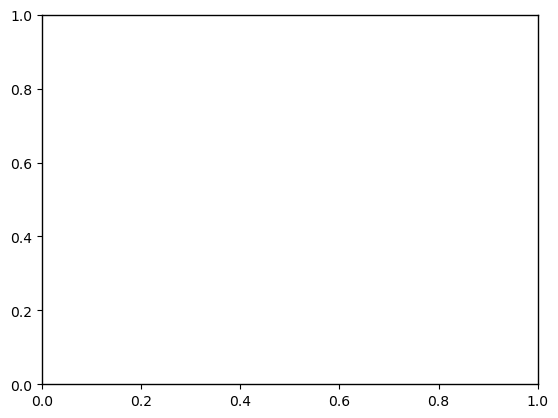

In [942]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_zy.mean(axis=0), levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("original u")

(800, 1280)


Text(0.5, 1.0, 'test from EOF and PC back to u')

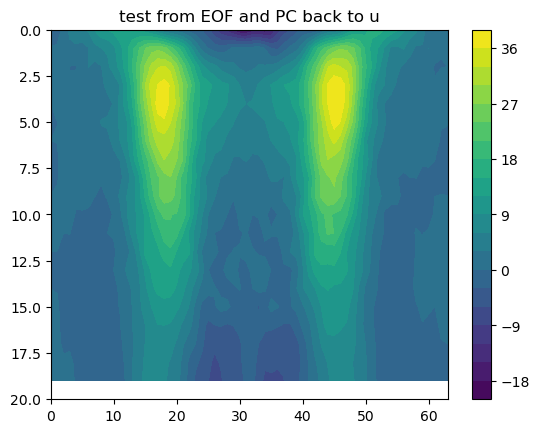

In [705]:
print(np.shape((single_EOF.EOF.T.dot(single_EOF.PC)).T))
test = np.reshape((single_EOF.EOF.T.dot(single_EOF.PC)).T, (total_day, 20*64))
test_mean = np.nanmean(test, axis=0)
test_final = np.reshape(test_mean, (20,64))
plt.figure()
CS = plt.contourf(test_final, levels=21)
plt.colorbar(CS)
plt.ylim([20,0])
plt.title("test from EOF and PC back to u")

# plot original u different PR

In [ ]:
pr_start = 0
pr_leap = 5
pr_to = 40

do_check_u = True
fig,ax   = plt.subplots(8,figsize=(5,24), dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    if do_check_u:
        u_mean = np.nanmean(u, axis=(0,3))
        CS = ax[a].contourf(yy, sigma_mean2, u_mean,levels=np.linspace(-18,36,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_ylim([1,0])
        ax[a].set_title(f"u wind [m/s], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
if do_check_u:
    # plt.savefig("check_U_equilibrium.png", dpi=600., bbox_inches='tight')
    fig.tight_layout()
    plt.show()



# Plot different PR latitude profile u

In [ ]:
cy

800
900
1000
1100
1200
1300
1400
1500


NameError: name 'do_check_u' is not defined

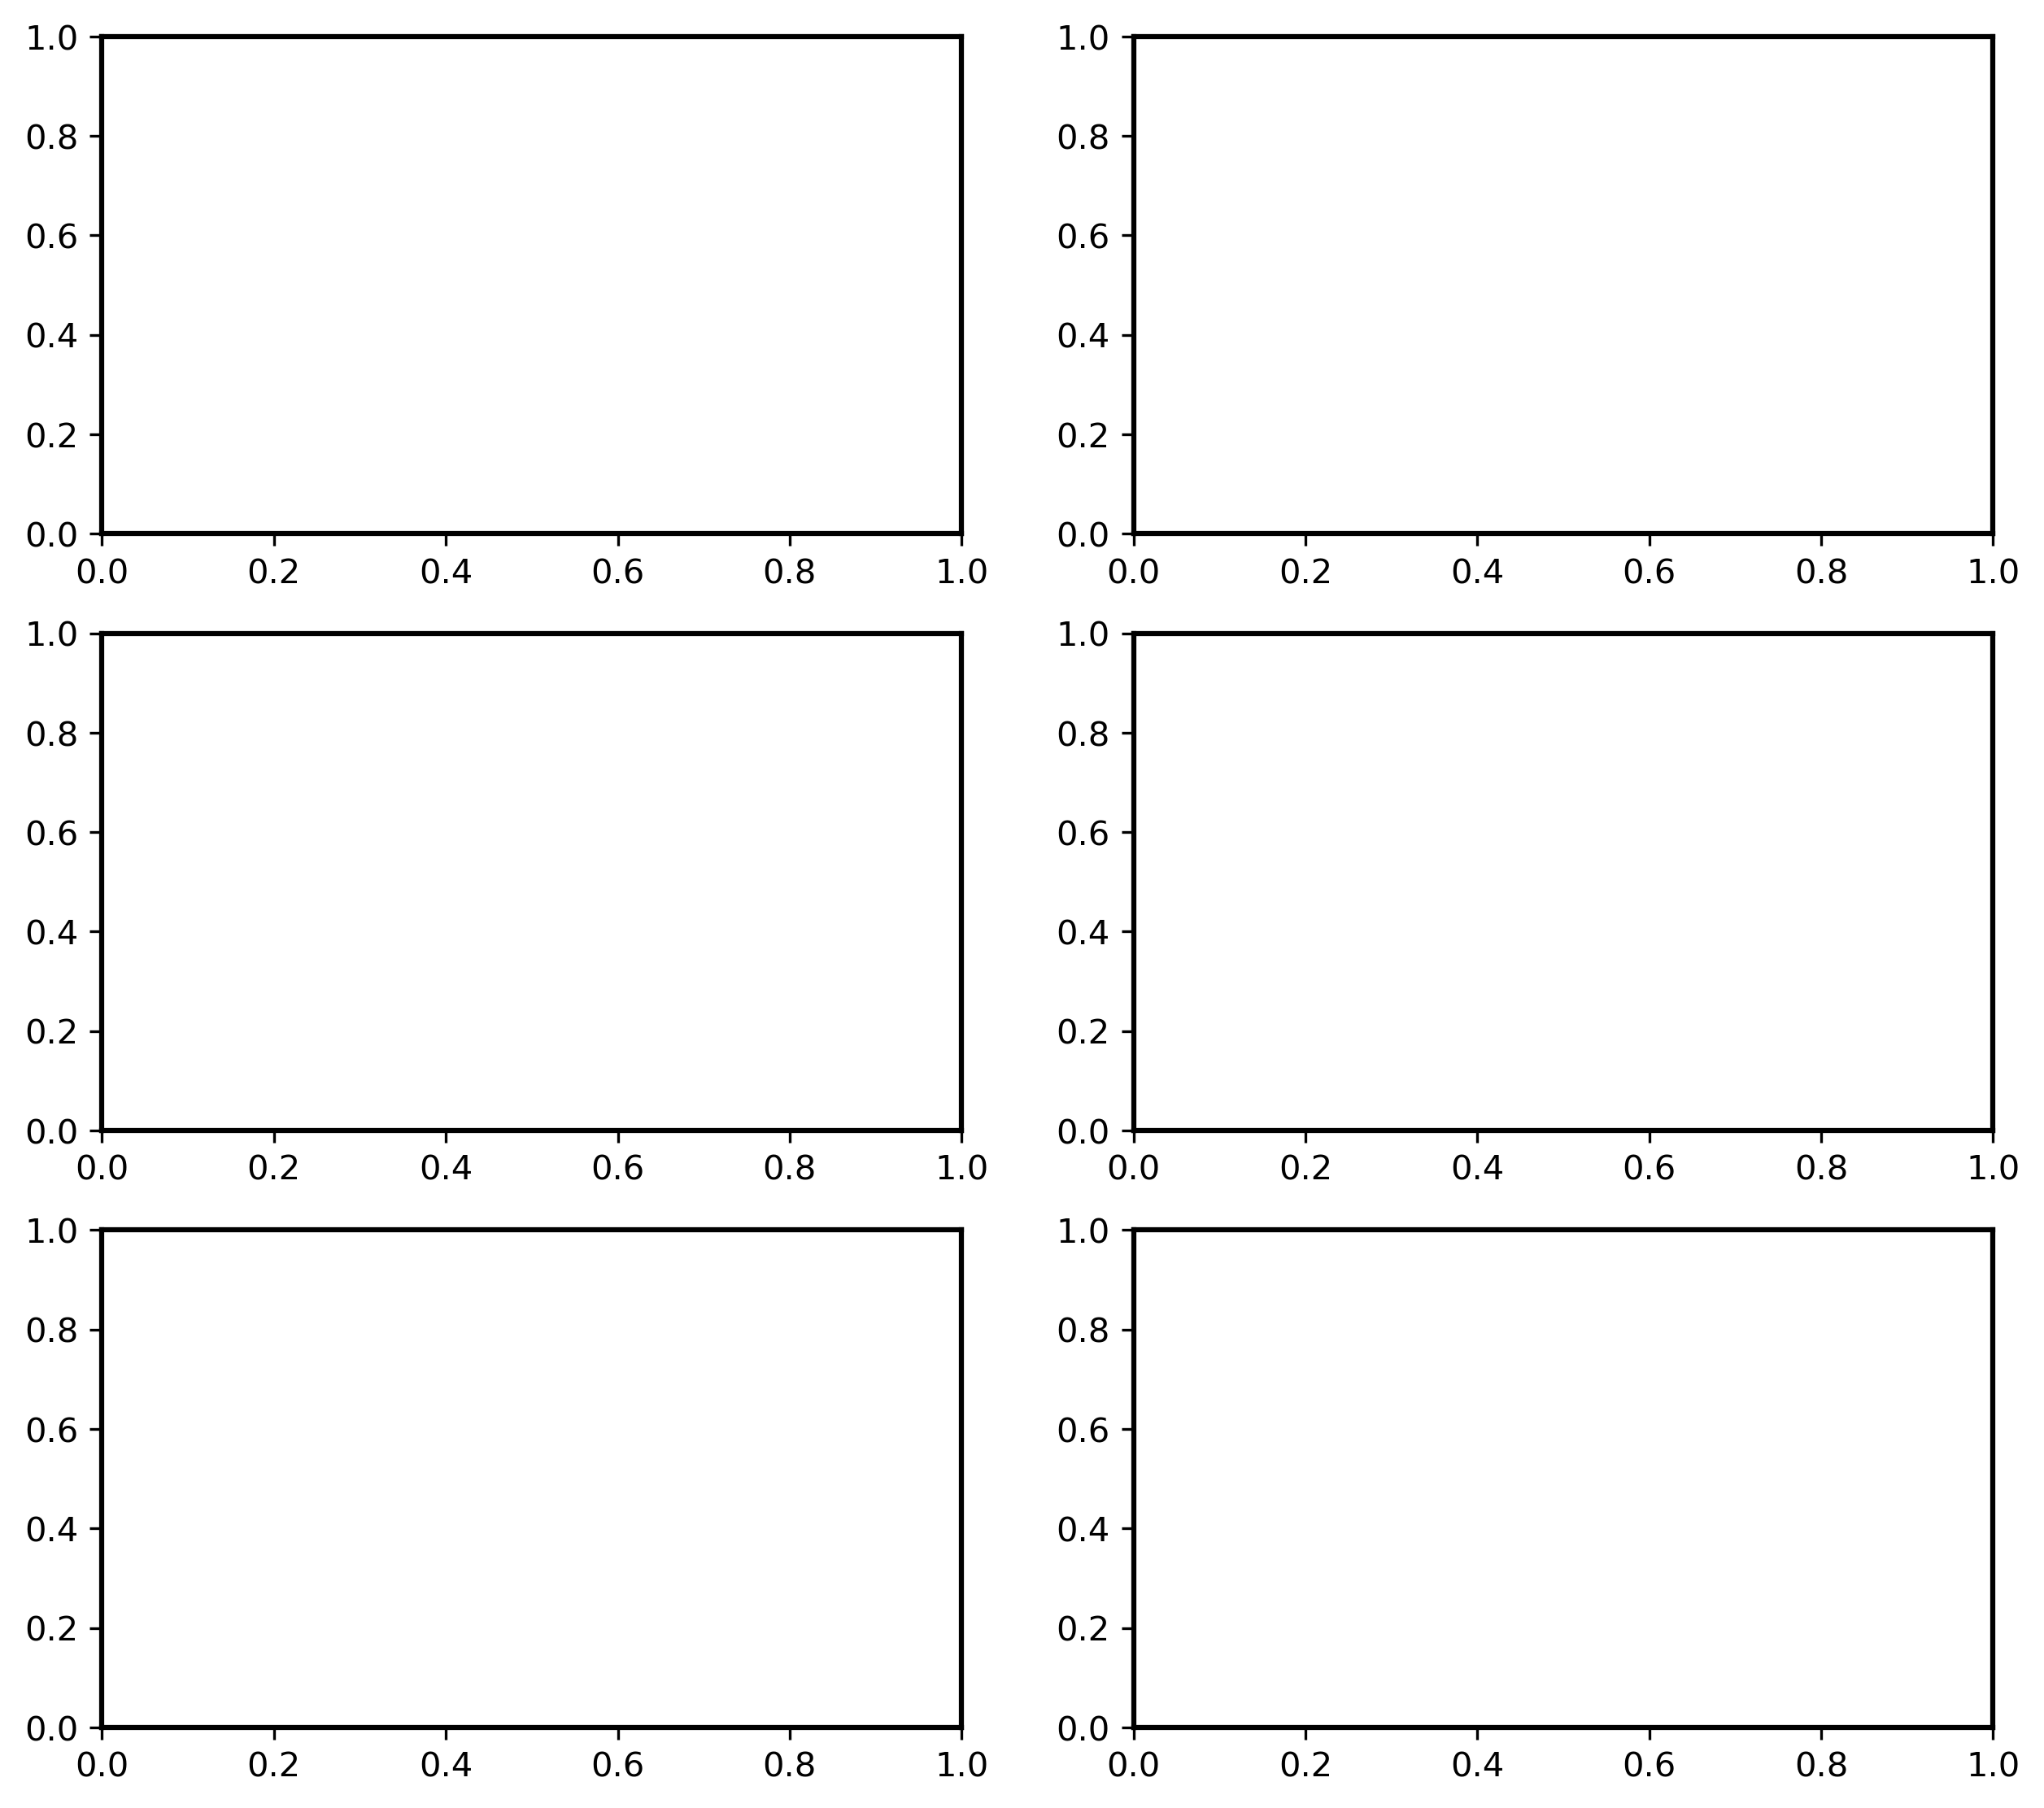

In [353]:
import matplotlib.colors as colors
import matplotlib as mpl
from scipy.interpolate import RectBivariateSpline

pr_start = 0
pr_leap = 5
pr_to = 40

fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########

do_check_north_jet = True
do_check_south_jet = False
do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
pr_north_idx_z = []
pr_north_idx_y = []

# Find the biggest n u wind
n = 20
biggest_n_U_z = np.zeros((pr_file, n)) 
biggest_n_U_y = np.zeros((pr_file, n))
interpolation_times = 10

for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    
    if do_check_north_jet:
        u_north_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_north_half[:,:,i,:] = u[:,:,i+32,:] * cy[i+32]**0.5
        u_zy = np.nanmean(u_north_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        pr_north_idx_y.append(j)
        pr_north_idx_z.append(k)
        # pr_idx_z_y[a,1] = j

        """
        # Becasue the grid is too coarse to identify the location of biggest u wind,
        # it would calculate the index of the biggest five u wind in the below code block.
        """
        if do_check_biggest_n_U:
            # Step 1. Do interpolation, increasing resolution third times
            interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
            yys          = np.linspace(0, 90, 32*interpolation_times)
            sigma_mean2s = np.linspace(0,  1, 20*interpolation_times)
            
            Y, Z = np.meshgrid(yys, sigma_mean2s)
            
            u_zy_thin = interp_spline(sigma_mean2s, yys)
            # Step 2. Find the biggest n U wind
            small_idx = np.dstack(np.unravel_index(np.argsort(u_zy_thin.ravel()), (np.shape(sigma_mean2s)[0], np.shape(yys)[0]))) # (1, 20*32, 2)
            biggest_n_U_z[a,:] = small_idx[0,-n:,0]
            biggest_n_U_y[a,:] = small_idx[0,-n:,1]
            
        ############################################################################
        ### plot ###
        if pr == 0:
            print("Northern Hemisphere")
            control = np.nanmax(u_zy[k,:])
            ax[0,0].axvline(x=y[32+j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[32:], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Northern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")
        
    if do_check_south_jet:
        u_south_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_south_half[:,:,i,:] = u[:,:,i,:] * cy[i]**0.5
        u_zy = np.nanmean(u_south_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        if pr == 0:
            print("Southern Hemisphere")
            control = np.nanmax(u_zy[k,:])
            ax[0,0].axvline(x=y[j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[:32], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Southern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")

    a += 1
# plt.legend()
ax[0,0].legend(prop={'size': 8})
plt.show()

In [ ]:
print(biggest_n_U_z[0,:])
print(biggest_n_U_y[0,:])

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9), dpi=300.)
ax = ax.ravel()
a = 0
# b = 0
y_north = np.linspace(0,90,32*interpolation_times) 
z_north = np.linspace(0, 1,20*interpolation_times) 

for pr in range(pr_start, pr_to, pr_leap):
# for pr in range(0, 10, 5):
    for i in range(n):
        if i == int(n-1):
            ax[a].scatter(y_north[int(biggest_n_U_y[a,i])], z_north[int(biggest_n_U_z[a,i])], label=f"PR={pr}")
        else:
            ax[a].scatter(y_north[int(biggest_n_U_y[a,i])], z_north[int(biggest_n_U_z[a,i])])
            
    ax[a].set_title(f"NH PR={pr} "+f"index of the biggest {n} U wind")
    ax[a].set_ylim([0.26,0.20])
    ax[a].set_xlim([34,41])
    ax[a].set_ylabel("sigma")
    ax[a].set_xlabel("latitude")
    ax[a].legend()
    ax[a].grid()
    a += 1
plt.suptitle(f"Interpolate the resolution to {interpolation_times} times")

fig.tight_layout()

# plt.savefig("check_U_index.png", dpi=300., bbox_inches='tight')
plt.show()


In [ ]:
biggest_n_U_y[0,:]

In [ ]:
plt.figure()
a = 0
for pr in range(pr_start, pr_to, pr_leap):
# for pr in range(0, 10, 5):
    # print(pr)
    plt.scatter(y_north[int(np.nanmean(biggest_n_U_y[a,:]))], z_north[int(np.nanmean(biggest_n_U_z[a,:]))], label=f"PR={pr}")
    a+=1
plt.ylim([0.245,0.215])
plt.legend()
plt.title(f"Mean index of the biggest {n} U wind,"+f"interpolational times = {interpolation_times}") 
plt.grid()
# plt.savefig("check_mean_U_index.png", dpi=300., bbox_inches='tight')
plt.show()

# Interplotation

In [354]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

In [355]:
sigma_onlyz

array([0.01839397, 0.07357589, 0.12415931, 0.17440211, 0.22453579,
       0.27462053, 0.32467908, 0.37472195, 0.42475472, 0.47478057,
       0.52480149, 0.57481877, 0.62483328, 0.67484563, 0.72485628,
       0.77486556, 0.82487371, 0.87488093, 0.92488737, 0.97489315])

In [356]:
y[32:]

array([ 1.42857143,  4.28571429,  7.14285714, 10.        , 12.85714286,
       15.71428571, 18.57142857, 21.42857143, 24.28571429, 27.14285714,
       30.        , 32.85714286, 35.71428571, 38.57142857, 41.42857143,
       44.28571429, 47.14285714, 50.        , 52.85714286, 55.71428571,
       58.57142857, 61.42857143, 64.28571429, 67.14285714, 70.        ,
       72.85714286, 75.71428571, 78.57142857, 81.42857143, 84.28571429,
       87.14285714, 90.        ])

In [357]:
u_zy.shape

(800, 20, 64)

In [358]:
interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
yys          = np.linspace(0,90,64)
sigma_mean2s = np.linspace(0,1,40)

Y, Z = np.meshgrid(yys, sigma_mean2s)

u_zy_thin = interp_spline(sigma_mean2s, yys)
# for i in range(yys.shape[0]):
#     zs[i]=f(yys[i],sigma_mean2s[i])

ValueError: x dimension of z must have same number of elements as x

In [928]:
u_zy_thin.shape

(200, 320)

TypeError: Shapes of x (20, 32) and z (20, 64) do not match

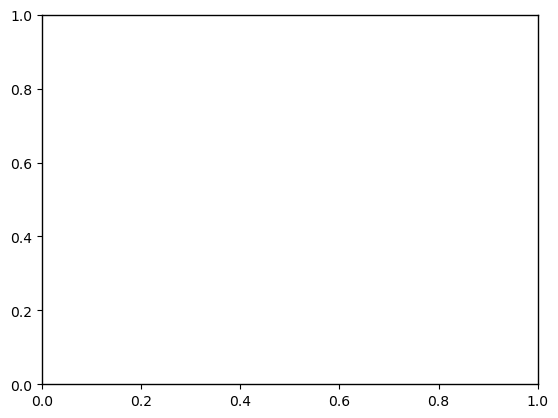

In [929]:
plt.figure()
plt.contourf(yy[:,32:], sigma_mean2[:,32:], u_zy)
plt.title("Original: (y,z) = (32,20)")
plt.ylim([1,0])

plt.figure()
plt.title("Interpolation: (y,z) = (64,40)")
plt.contourf(Y, Z, u_zy_thin)
plt.ylim([1,0])

# Calculate error bar of the interpolation

In [943]:
import random
import scipy.stats as st 

In [944]:
# Null hypothesis: To test the location of maximum u wind in 80 days would be different significantly.
# 
# I have (time, z, y, x) = (800, 20, 32, 128) in each hemisphere.
# Step 1. Interpolate from (80, 20, 32) => (80, 200, 320)
# Step 2. Randomly select the index of the day of 80 days from 200-1000 day 
#         => the reason why choose 80 not 20 or 10, because it takes 25 days to do Fourier transform in Lorenz paper, and 70~80 days to do the low frequency in Nick paper.
# Step 3. From (80, 200, 320) find the each day find the biggest 10% u wind of these 80 days of y-z coordinate,
#         that is 200 * 320 * 10% = 640 indexes. (Want to circle the biggest u wind on the y-z coordinate)
# Step 4. Do mean these 640 indexes => get the single point (y,z)
# Step 5. Repeat step 2-4 1000 times => get 1000 point (y,z)
# Step 6. plot mean and confident interval

In [945]:
def bootstrap_y(all_index, total_times, each_time, n, intepolation, y , sigma_onlyz, yys, sigma_mean2s):
    sample_idx_mean = []
    CI_low          = []
    CI_high         = []

    # biggest_n_U_z_errorbar_mean_all = np.zeros(np.shape(all_index)[0])# 640
    # biggest_n_U_y_errorbar_mean_all = np.zeros(np.shape(all_index)[0])

    biggest_n_U_z_errorbar_mean_final = np.zeros(total_times)
    biggest_n_U_y_errorbar_mean_final = np.zeros(total_times)
    selected_u_mean_total_time_y        = np.zeros(total_times)
    selected_u_mean_total_time_z        = np.zeros(total_times)
    
    #selected_u_mean_z = np.zeros(total_times)
    # Step 1. Interpolation 
    data_thin = np.zeros(((np.shape(all_index)[0], 20*intepolation, 32*intepolation)))
    
    biggest_n_U_z_errorbar = np.zeros(total_times)
    biggest_n_U_y_errorbar = np.zeros(total_times)
    # top_u_z                  = np.zeros(n)
    # top_u_y                  = np.zeros(n)

    for k in range(np.shape(all_index)[0]):
        interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], all_index[k,:,:])
        data_thin[k,:,:]       = interp_spline(sigma_mean2s, yys)


    for i in range(total_times): 
          # randomly select
          each_time_u   = np.zeros(((each_time, np.shape(data_thin)[1], np.shape(data_thin)[2])))  # randomly select each_time
          # each_time_z   = np.zeros(np.shape(all_index)[2])  # all_index  : (20, 32)each_time
          for j in range(each_time): # 80
              tmp_z  = np.zeros(int(20*32*intepolation*intepolation*n))
              tmp_y  = np.zeros(int(20*32*intepolation*intepolation*n))

              
              random_index_time  = np.random.randint(0, data_thin.shape[0]) #(20,32) (z,y)
              each_time_u[j,:,:] = data_thin[random_index_time, :, :] # (20, 32)
              small_idx_z_eachtime = np.dstack(np.unravel_index(np.argsort(each_time_u[j,:,:].ravel()), ((np.shape(each_time_u[j,:,:])[0]), (np.shape(each_time_u[j,:,:])[1]))))  
              small_idx_y_eachtime = np.dstack(np.unravel_index(np.argsort(each_time_u[j,:,:].ravel()), ((np.shape(each_time_u[j,:,:])[0]), (np.shape(each_time_u[j,:,:])[1]))))  

              tmp_z[:] = small_idx_z_eachtime[0,-int(20*32*intepolation*intepolation*n):,0]
              tmp_y[:] = small_idx_y_eachtime[0,-int(20*32*intepolation*intepolation*n):,1]

              zz_idx = np.zeros(int(20*32*intepolation*intepolation*n))
              yy_idx = np.zeros(int(20*32*intepolation*intepolation*n))
              for q in range(int(20*32*intepolation*intepolation*n)):
                  yy_idx[q] = yys[int(tmp_y[q])]
                  zz_idx[q] = sigma_mean2s[int(tmp_z[q])]
          
          selected_u_mean_total_time_z[i] = np.nanmean(zz_idx)
          selected_u_mean_total_time_y[i] = np.nanmean(yy_idx)

    biggest_n_U_z_errorbar = np.nanmean(selected_u_mean_total_time_z)
    biggest_n_U_y_errorbar = np.nanmean(selected_u_mean_total_time_y)

    ### Let all total_time back to lat, sigma, then calculate CI





    CI_low_mean_z, CI_high_mean_z = st.t.interval(confidence=0.95, 
                                                  df=np.shape(selected_u_mean_total_time_z)[0]-1, 
                                                  loc=np.mean(selected_u_mean_total_time_z),  
                                                  scale=st.sem(selected_u_mean_total_time_z))

    ############################################################################################
    CI_low_mean_y, CI_high_mean_y = st.t.interval(confidence=0.95, 
                                                  df=np.shape(selected_u_mean_total_time_y)[0]-1, 
                                                  loc=np.mean(selected_u_mean_total_time_y),  
                                                  scale=st.sem(selected_u_mean_total_time_y))
    
    
    return biggest_n_U_z_errorbar, biggest_n_U_y_errorbar, CI_low_mean_z, CI_high_mean_z, CI_low_mean_y, CI_high_mean_y



In [417]:
pr_start = 0
pr_leap = 5
pr_to = 40

### fig
# y = np.linspace(-90, 90, 64)
# yy, tt = np.meshgrid(y,time)
a      = int(0)
plt.figure(figsize=(6,4), dpi=300.)

#########

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
print(total_file)
total_day = int(total_file*internal_day)

u = np.zeros((((800, 20, 64, 128))))

do_check_u_error_bar = True
a = 0
# b = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    # print(u_ini.shape)
    # b = 0
    for k in range(total_file):
        if do_check_u_error_bar:
            if k ==0:
                u[0:100,:,:,:]           = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]

    # Step 1. given value
    u_all_mean = np.nanmean(u, axis=(3)) # (800, 20, 32)

    # Step 2. Do interpolation, increasing resolution ten times
    interpolation_times = 10
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)
    
    # # Step 3. Do bootstrap
    total_time = 1000
    each_time = 80           # need to equal to the number of Fourier transform and wannt to see low frequency
    ### n denote to take the biggest n% in each day 
    n = 0.05
    
    selected_u_mean_z, selected_u_mean_y, CI_low_mean_z, CI_high_mean_z, CI_low_mean_y, CI_high_mean_y= bootstrap_y(u_all_mean[:,:,32:], total_time, each_time, n, interpolation_times, y , sigma_onlyz, yys, sigma_mean2s) # each_time need to eqaul to the amount of the number of Fourier transform

    
    y_error2  = CI_high_mean_y - np.nanmean(selected_u_mean_y)
    y_error   = np.nanmean(selected_u_mean_y) - CI_low_mean_y
    print(y_error, y_error2)

    z_error2  = CI_high_mean_z - np.nanmean(selected_u_mean_z)
    z_error   = np.nanmean(selected_u_mean_z) - CI_low_mean_z
    print(z_error, z_error2)
    
    print("PR:",f"{pr},\n z index:CI_high=",(CI_high_mean_z), "mean point=", np.nanmean(selected_u_mean_z),"CI_low=",(CI_low_mean_z))
    print("PR:",f"{pr},\n y index:CI_high=",(CI_high_mean_y), "mean point=", np.nanmean(selected_u_mean_y),"CI_low=",(CI_low_mean_y))
    ###########################################################
    print("===========================")
    print(f"PR={pr}:")
    print("y latitude:")
    
    print("CI high:", CI_high_mean_y)
    print("mean:   ", np.nanmean(selected_u_mean_y))
    print("CI low: ", CI_low_mean_y)
    print("===========================")
    print("z latitude:")
    print("CI high:", CI_high_mean_z)
    print("mean:   ", np.nanmean(selected_u_mean_z))
    print("CI low: ", CI_low_mean_z)
    print("===========================")
    ###############################################################
    plt.scatter( np.nanmean(selected_u_mean_y), np.nanmean(selected_u_mean_z), label=f"PR={pr}")
    plt.errorbar(np.nanmean(selected_u_mean_y), np.nanmean(selected_u_mean_z), xerr = np.stack([[y_error], [y_error2]]), yerr = np.stack([[z_error],[z_error2]]), fmt='o', elinewidth=2, capsize=3, ms=2) # 

    a += 1
plt.gca().invert_yaxis()
plt.title(f"200-1000 day files bootstrap {total_time} times ({each_time} time each),\n take the biggest {n} (10%) u wind of {each_time} times (interpolation {interpolation_times} times)")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.legend()
plt.savefig("check_u_index_bootstrap_2percentage.png", dpi=300, bbox_inches='tight')
plt.show()



                

5


KeyboardInterrupt: 

<Figure size 1800x1200 with 0 Axes>

In [ ]:
sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

plt.figure()
CS = plt.contourf(yy, sigma_mean2, np.nanmean(u,axis=(0,3)), levels=21)
plt.contour(yy, sigma_mean2, np.nanmean(u,axis=(0,3)), [34,36],colors= 'k')

plt.ylim([1,0])
plt.colorbar(CS)


In [ ]:
sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

u_new = np.mean(u, axis=(0,3))
print(20 * 64 * 0.1)
print(np.shape(u_new[0:2,32:38]))
u_new[0:10,32:44] = 0
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_new, levels=21)
plt.ylim([1,0])
plt.colorbar(CS)

In [ ]:
### 01/15 final work
### have done bootstrap function
### need to find the y index and z index using bootstrap method

# Reproduce Nick fig.1 using interpolative U

In [360]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

In [361]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
cy = np.cos(yd)

In [362]:
# PR=0
interpolation_times = 10
yys           = np.linspace(0, 90, 32*interpolation_times)
sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)

y_pr0 = 37.505543593260185
z_pr0 = 0.3238856163630653
print(np.shape(yys))

(320,)


In [363]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [364]:
print(find_nearest(yys, value=y_pr0))
print(find_nearest(sigma_mean2s, value=z_pr0))


(37.52351097178683, 133)
(0.32160804020100503, 64)


In [365]:
pr_start = 0
pr_leap = 10
pr_to = 60

start = 800
end   = 1600
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
total_pr  = int((pr_to - pr_start) / pr_leap)
print(total_day)
print(total_pr)

800
6


In [370]:
check_05percentage = True
check_1percentage  = False
check_5percentage  = False
check_10percentage = False
if check_05percentage:
    if pr_leap ==5:
        y_pr0 = 37.505543593260185
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[2] = 0.245966425879397
        z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[4] = 0.2404396827889447
        z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[6] = 0.2302165672110553
        z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[8] = 0.21822737123115576
        z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[10] = 0.20429698492462314
        
        
    else:
        y_pr0 = 37.505543593260185
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        # z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[1] = 0.245966425879397
        # z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[2] = 0.2404396827889447
        # z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[3] = 0.2302165672110553
        # z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[4] = 0.21822737123115576
        # z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[5] = 0.20429698492462314

if check_1percentage:
    if pr_leap == 5:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.2504103093592965
        z_biggest_all[2] = 0.25088522298994975
        z_biggest_all[3] = 0.24788092807788945
        z_biggest_all[4] = 0.24516175408291457
        z_biggest_all[5] = 0.23950071451005026
        z_biggest_all[6] = 0.23397497644472362
        z_biggest_all[7] = 0.2242414337311558
        z_biggest_all[8] = 0.21955492305276383
        z_biggest_all[9] = 0.21416552292713567
        z_biggest_all[10] = 0.20697050879396983
    else:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.25088522298994975
        z_biggest_all[2] = 0.24516175408291457
        # z_biggest_all[3] = 0.23397497644472362
        # z_biggest_all[4] = 0.21955492305276383
        # z_biggest_all[5] = 0.20697050879396983
    
    
if check_10percentage:
    y_pr0 = 36.228926875979624
    z_biggest_all = np.zeros(total_pr)
    z_biggest_all[0] = 0.3238856163630653
    z_biggest_all[1] = 0.32541720398869345
    z_biggest_all[2] = 0.33223640625
    z_biggest_all[3] = 0.3252315201005025
    z_biggest_all[4] = 0.32447135364321605
    z_biggest_all[5] = 0.3121236958228643
    z_biggest_all[6] = 0.3052737688442211
    z_biggest_all[7] = 0.2859219904208543

if check_5percentage:
    y_pr0 = 36.5939329937304
    z_biggest_all = np.zeros(total_pr)
    z_biggest_all[0] = 0.28572386149497486
    z_biggest_all[1] = 0.2872950973618091
    z_biggest_all[2] = 0.29088036903266334
    z_biggest_all[3] = 0.2857038599246231
    z_biggest_all[4] = 0.2842567258165829
    z_biggest_all[5] = 0.27495892430904517
    z_biggest_all[6] = 0.2675492022613066
    z_biggest_all[7] = 0.252779739321608
print("done")

done


800
900
1000
1100
1200
1300
1400
1500
PR: 0 ,maximum [z index, y index]: 49 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 10 ,maximum [z index, y index]: 49 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 20 ,maximum [z index, y index]: 48 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 30 ,maximum [z index, y index]: 46 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 40 ,maximum [z index, y index]: 43 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 50 ,maximum [z index, y index]: 41 133
Interpolation done


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


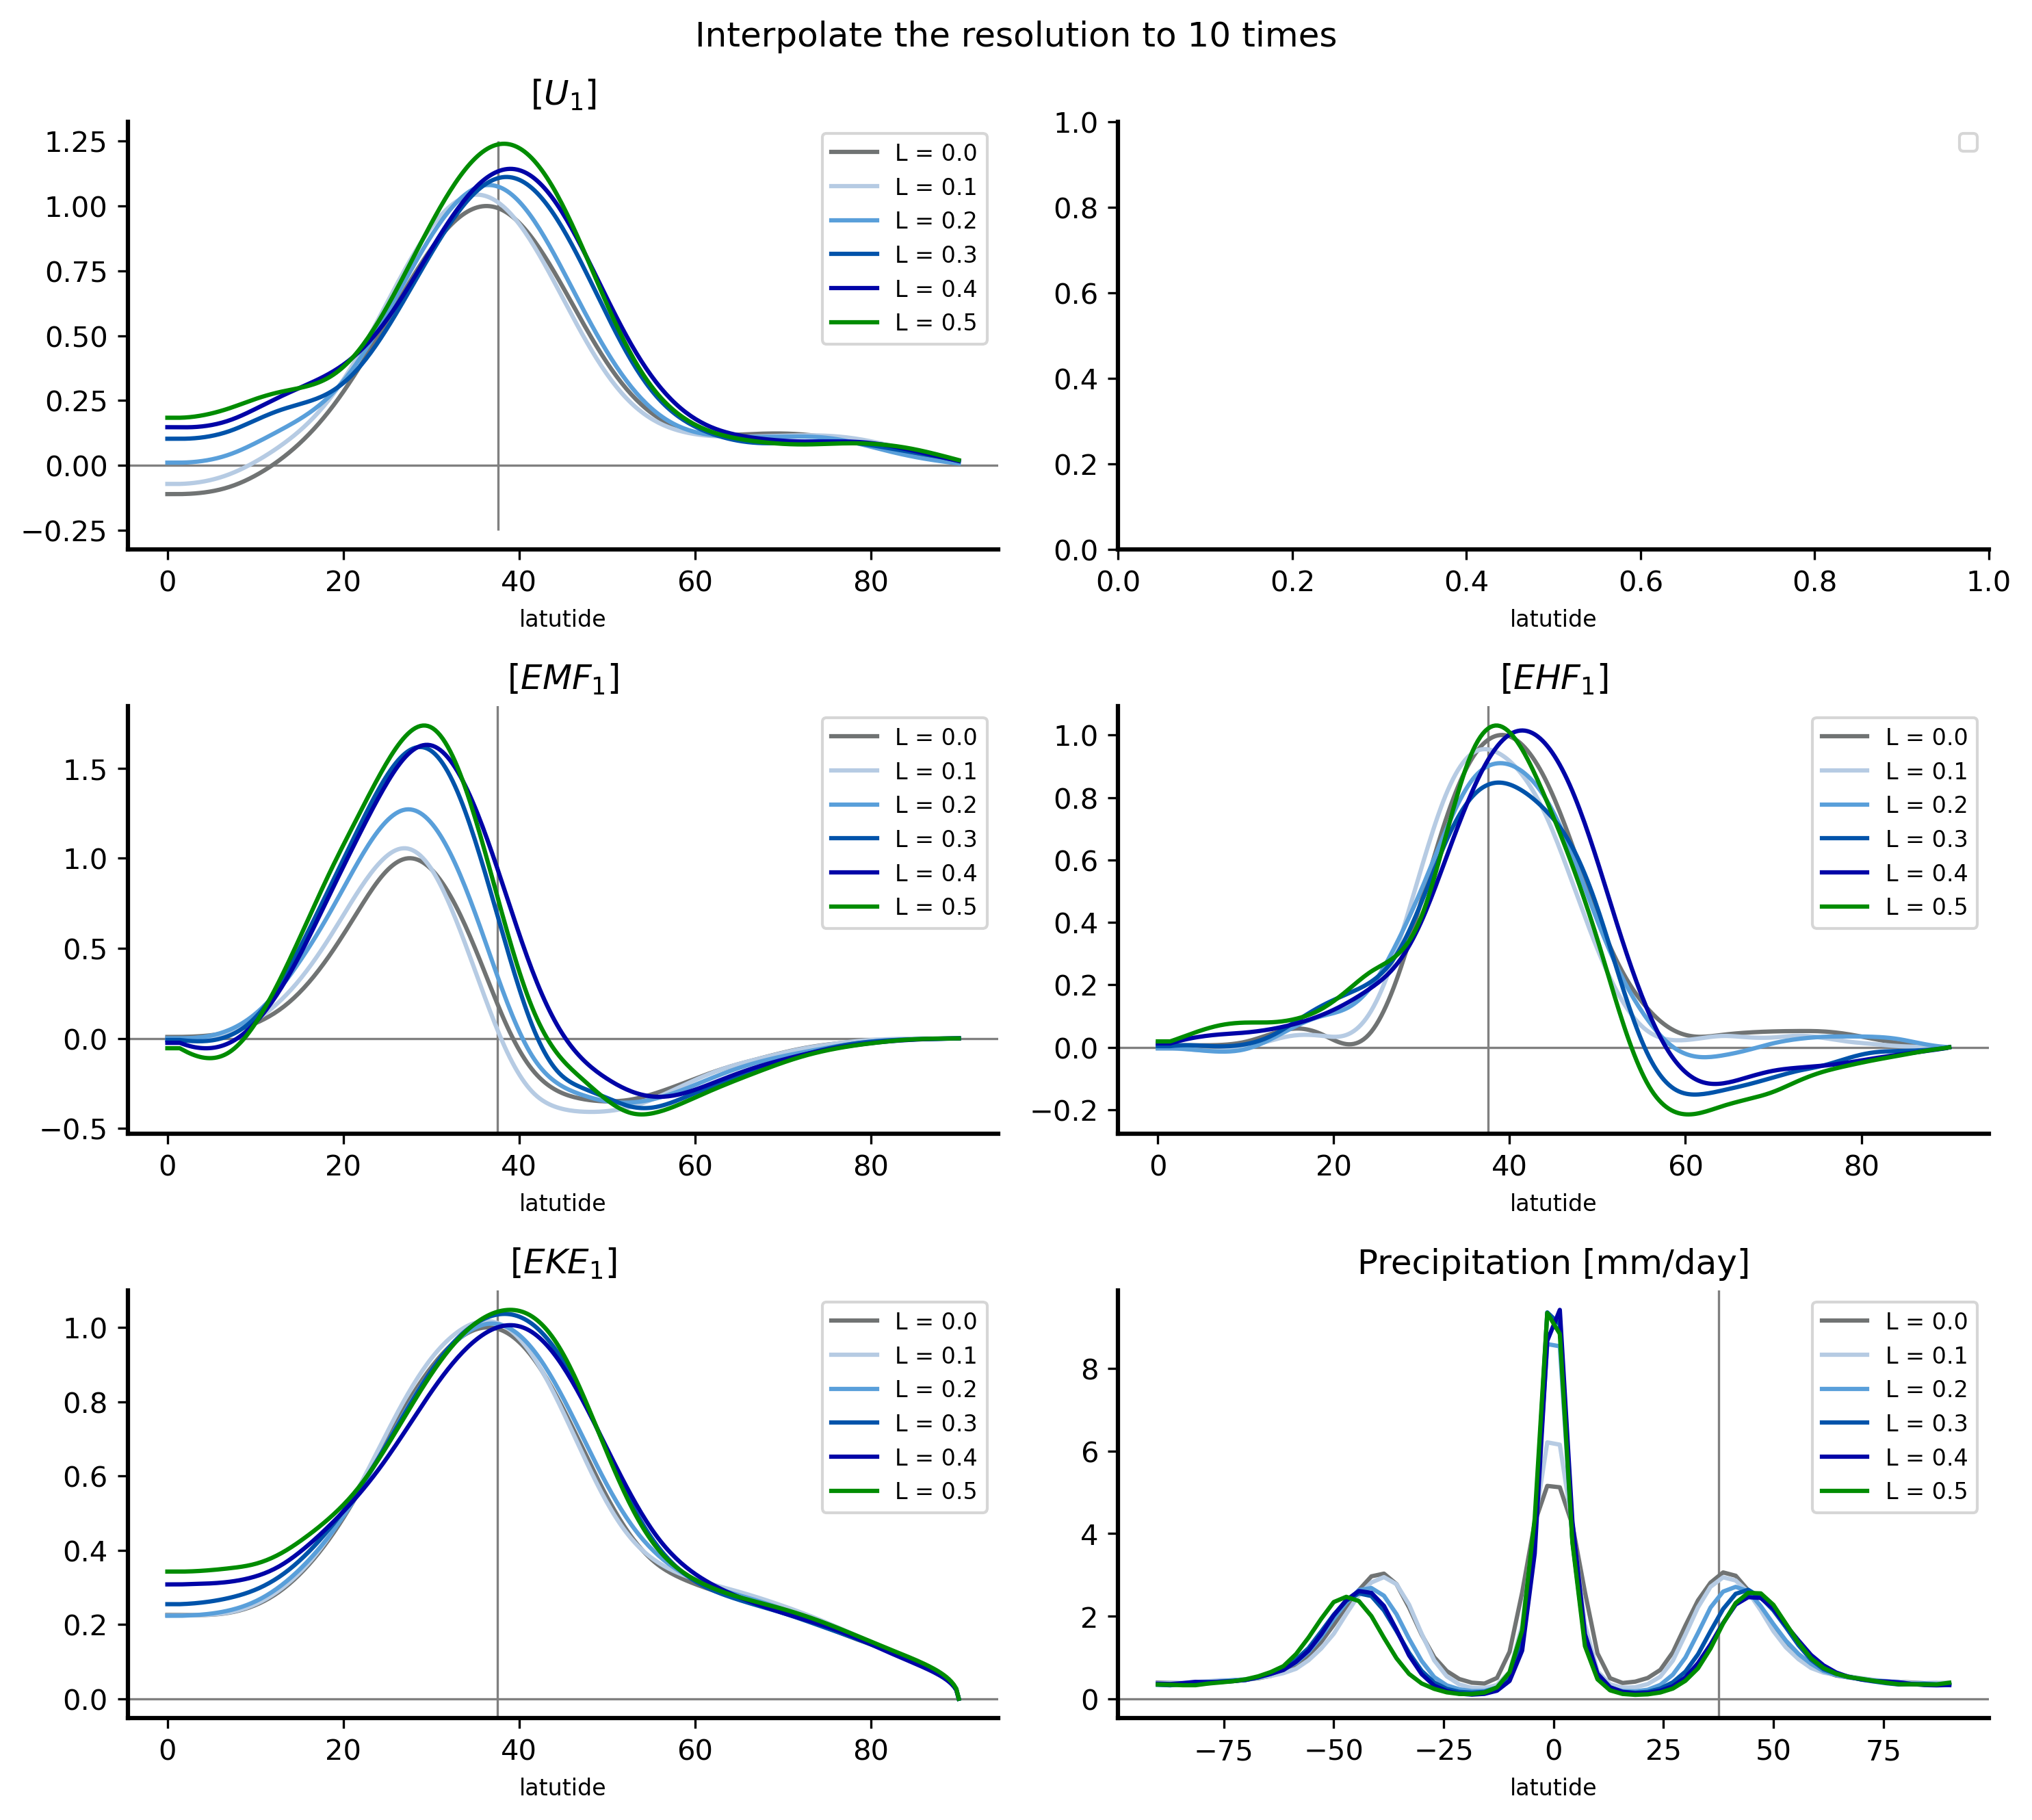

In [371]:
import matplotlib.colors as colors
import matplotlib as mpl
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))



fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
mpl.rcParams['axes.linewidth'] = 2

y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########


do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
g = 9.81
pr_north_idx_z = []
pr_north_idx_y = []


interpolation_times = 10

EMF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EHF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
u_zy_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EKE_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if k ==0:
            u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
            t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            p_half[0:100,:,:,:]             = p_half_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
            qv_diff[0:100,:,:,:]             = qv_diff_ini[k,:,:,:,:]
            
            
            
        else:
            u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
            v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
            t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
            qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
            
    if pr == 0:
        if k ==0:
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
        else:
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
            
        check_days_length = total_day
        sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
        sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
        y               = np.linspace(-90,90,64)
        yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)


    u_zy = np.nanmean(u, axis=(0,3))
    interpolation_times = 10
    u_zy_thin = np.zeros((20*interpolation_times, 32*interpolation_times))


    
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)

    cyy = np.cos(np.deg2rad(yys))
    
    
    interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], u_zy[:,32:])
    u_zy_thin[:,:]         = interp_spline(sigma_mean2s, yys)
    u_zy_thin_check[a,:,:] = u_zy_thin

    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
    
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)

    #########################################################################
    ## EMF
    u_prime        = np.rollaxis((np.rollaxis(u, 3, 0) - np.nanmean(u, axis=3)), 0, 4) 
    v_prime        = np.rollaxis((np.rollaxis(v, 3, 0) - np.nanmean(v, axis=3)), 0, 4) 
    
    # u_prime_w = np.zeros(u_prime.shape)
    # v_prime_w = np.zeros(v_prime.shape)
    # # t_prime_w = np.zeros(t_prime.shape)
    
    # for i in range(total_day):
    #     for j in range(20):
    #         for k in range(128):
    #             u_prime_w[i,j,:,k] = u_prime[i,j,:,k]* cy[:]**0.5
    #             v_prime_w[i,j,:,k] = v_prime[i,j,:,k]* cy[:]**0.5
    #             # t_prime_w[i,j,:,k] = t_prime[i,j,:,k]* cy[:]**0.5
                
                
    
    Mzmtm      = np.nanmean(u_prime * v_prime, axis=(0,3))
    Mzmtm_thin = np.zeros((20*interpolation_times, 32*interpolation_times))
    
    interp_spline        = RectBivariateSpline(sigma_onlyz, y[32:], Mzmtm[:,32:])
    Mzmtm_thin[:,:]      = interp_spline(sigma_mean2s, yys)

    print("Interpolation done")
    
    Mzmtm_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        Mzmtm_thin_w[i,:] = Mzmtm_thin[i,:] * cyy[:]**0.5
    EMF_check[a,:,:] = Mzmtm_thin_w
    #########################################################################
    ## EKE
    # cal first, then interpolate.
    eddy_kinatic_energy    = 0.5 * np.nanmean((u_prime**2 + v_prime**2)**0.5, axis=(0,3))
    EKE_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    EKE_thin_check[a,:,:] = EKE_thin
    

    EKE_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        EKE_thin_w[i,:] = EKE_thin[i,:] * cyy[:]**0.5
    ###
    # for i in range(800):
    #     for j in range(128):
    #     interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    # EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    #########################################################################
    # EHF
    t_prime        = np.rollaxis((np.rollaxis(t, 3, 0) - np.nanmean(t, axis=3)), 0, 4)
    b = t_prime / np.nanmean(t, axis=0) * 9.81
    eddy_flux_heat      = np.nanmean(b * v_prime, axis=(0, 3))
    eddy_flux_heat_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline            = RectBivariateSpline(sigma_onlyz, y[32:], eddy_flux_heat[:,32:])
    eddy_flux_heat_thin[:,:] = interp_spline(sigma_mean2s, yys)
    
    eddy_flux_heat_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        eddy_flux_heat_thin_w[i,:] = eddy_flux_heat_thin[i,:] * cyy[:]**0.5
    EHF_check[a,:,:] = eddy_flux_heat_thin_w
    #########################################################################
    # Precipitation
    Prec = np.zeros(u.shape)
    for i in range(1,20-1):
        Prec[:,i,:,:] = 1/g * qv_diff[:,i,:,:] * (p_half[:,i+1,:,:] - p_half[:,i,:,:])
    Prec[:, 0,:,:] = 1/g * qv_diff[:, 0,:,:] * (p_half[:, 1,:,:] - p_half[:, 0,:,:])
    # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
    
    Prec_mean = np.nansum(Prec, axis=(1))
    Prec_mean_y = np.nanmean(Prec_mean, axis=(0,2))

    

    
    ### plot ###
    """
    # fig[0,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        control = np.nanmax(u_zy_thin[biggest_u_z_idx,:])
        # ax[0,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[0,0].vlines(37.6316129032258, ymin=-0.25,ymax=1.25, color='gray', lw=0.8)
        
        ax[0,0].axhline(y=0, color='gray', lw=0.8)
    
    ax[0,0].plot(yys, u_zy_thin[biggest_u_z_idx,:] / control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)]) #
    ax[0,0].set_title("[$U_{1}$]", fontsize=12)
    """
    # fig[1,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        EMF_control = np.nanmax(Mzmtm_thin_w[biggest_u_z_idx,:])
        ax[1,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[1,0].axhline(y=0, color='gray', lw=0.8)

    ax[1,0].plot(yys, Mzmtm_thin_w[biggest_u_z_idx,:] / EMF_control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[1,0].set_title("[$EMF_{1}$]", fontsize=12)
    """
    # fig[2,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        EKE_control = np.nanmax(EKE_thin_w[biggest_u_z_idx,:])
        ax[2,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[2,0].axhline(y=0, color='gray', lw=0.8)
        
    ax[2,0].plot(yys, EKE_thin_w[biggest_u_z_idx,:] / EKE_control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[2,0].set_title("[$EKE_{1}$]", fontsize=12)
    """
    # fig[1,1]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        EHF_control = np.nanmax(eddy_flux_heat_thin_w[biggest_u_z_idx,:])
        ax[1,1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[1,1].axhline(y=0, color='gray', lw=0.8)
        
    ax[1,1].plot(yys, eddy_flux_heat_thin_w[biggest_u_z_idx,:] / EHF_control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[1,1].set_title("[$EHF_{1}$]", fontsize=12)
    """
    # fig[2,1]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # EHF_control = np.nanmax(eddy_flux_heat_thin_w[biggest_u_z_idx,:])
        ax[2,1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[2,1].axhline(y=0, color='gray', lw=0.8)
        
    ax[2,1].plot(y[:], Prec_mean_y[:]*86400, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[2,1].set_title("Precipitation [mm/day]", fontsize=12)
    

    a += 1

for i in range(3):
    for j in range(2):
        ax[i,j].spines["right"].set_visible(False)
        ax[i,j].spines["top"].set_visible(False)
        ax[i,j].set_xlabel("latutide", fontsize=8)
        ax[i,j].legend()
        ax[i,j].legend(prop={'size': 8})
        
        
mpl.rcParams['axes.linewidth'] = 1.5
        
plt.suptitle(f"Interpolate the resolution to {interpolation_times} times")

fig.tight_layout()
# plt.savefig("Nick_fig1_PR0_50.png", dpi=300., bbox_inches='tight')
plt.show()

# Nick paper fig.1 but using all level intergration

800
900
1000
1100
1200
1300
1400
1500
PR: 0 ,maximum [z index, y index]: 49 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 10 ,maximum [z index, y index]: 49 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 20 ,maximum [z index, y index]: 48 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 30 ,maximum [z index, y index]: 46 133
Interpolation done
800
900
1000
1100
1200
1300
1400
1500
PR: 40 ,maximum [z index, y index]: 43 133
Interpolation done


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


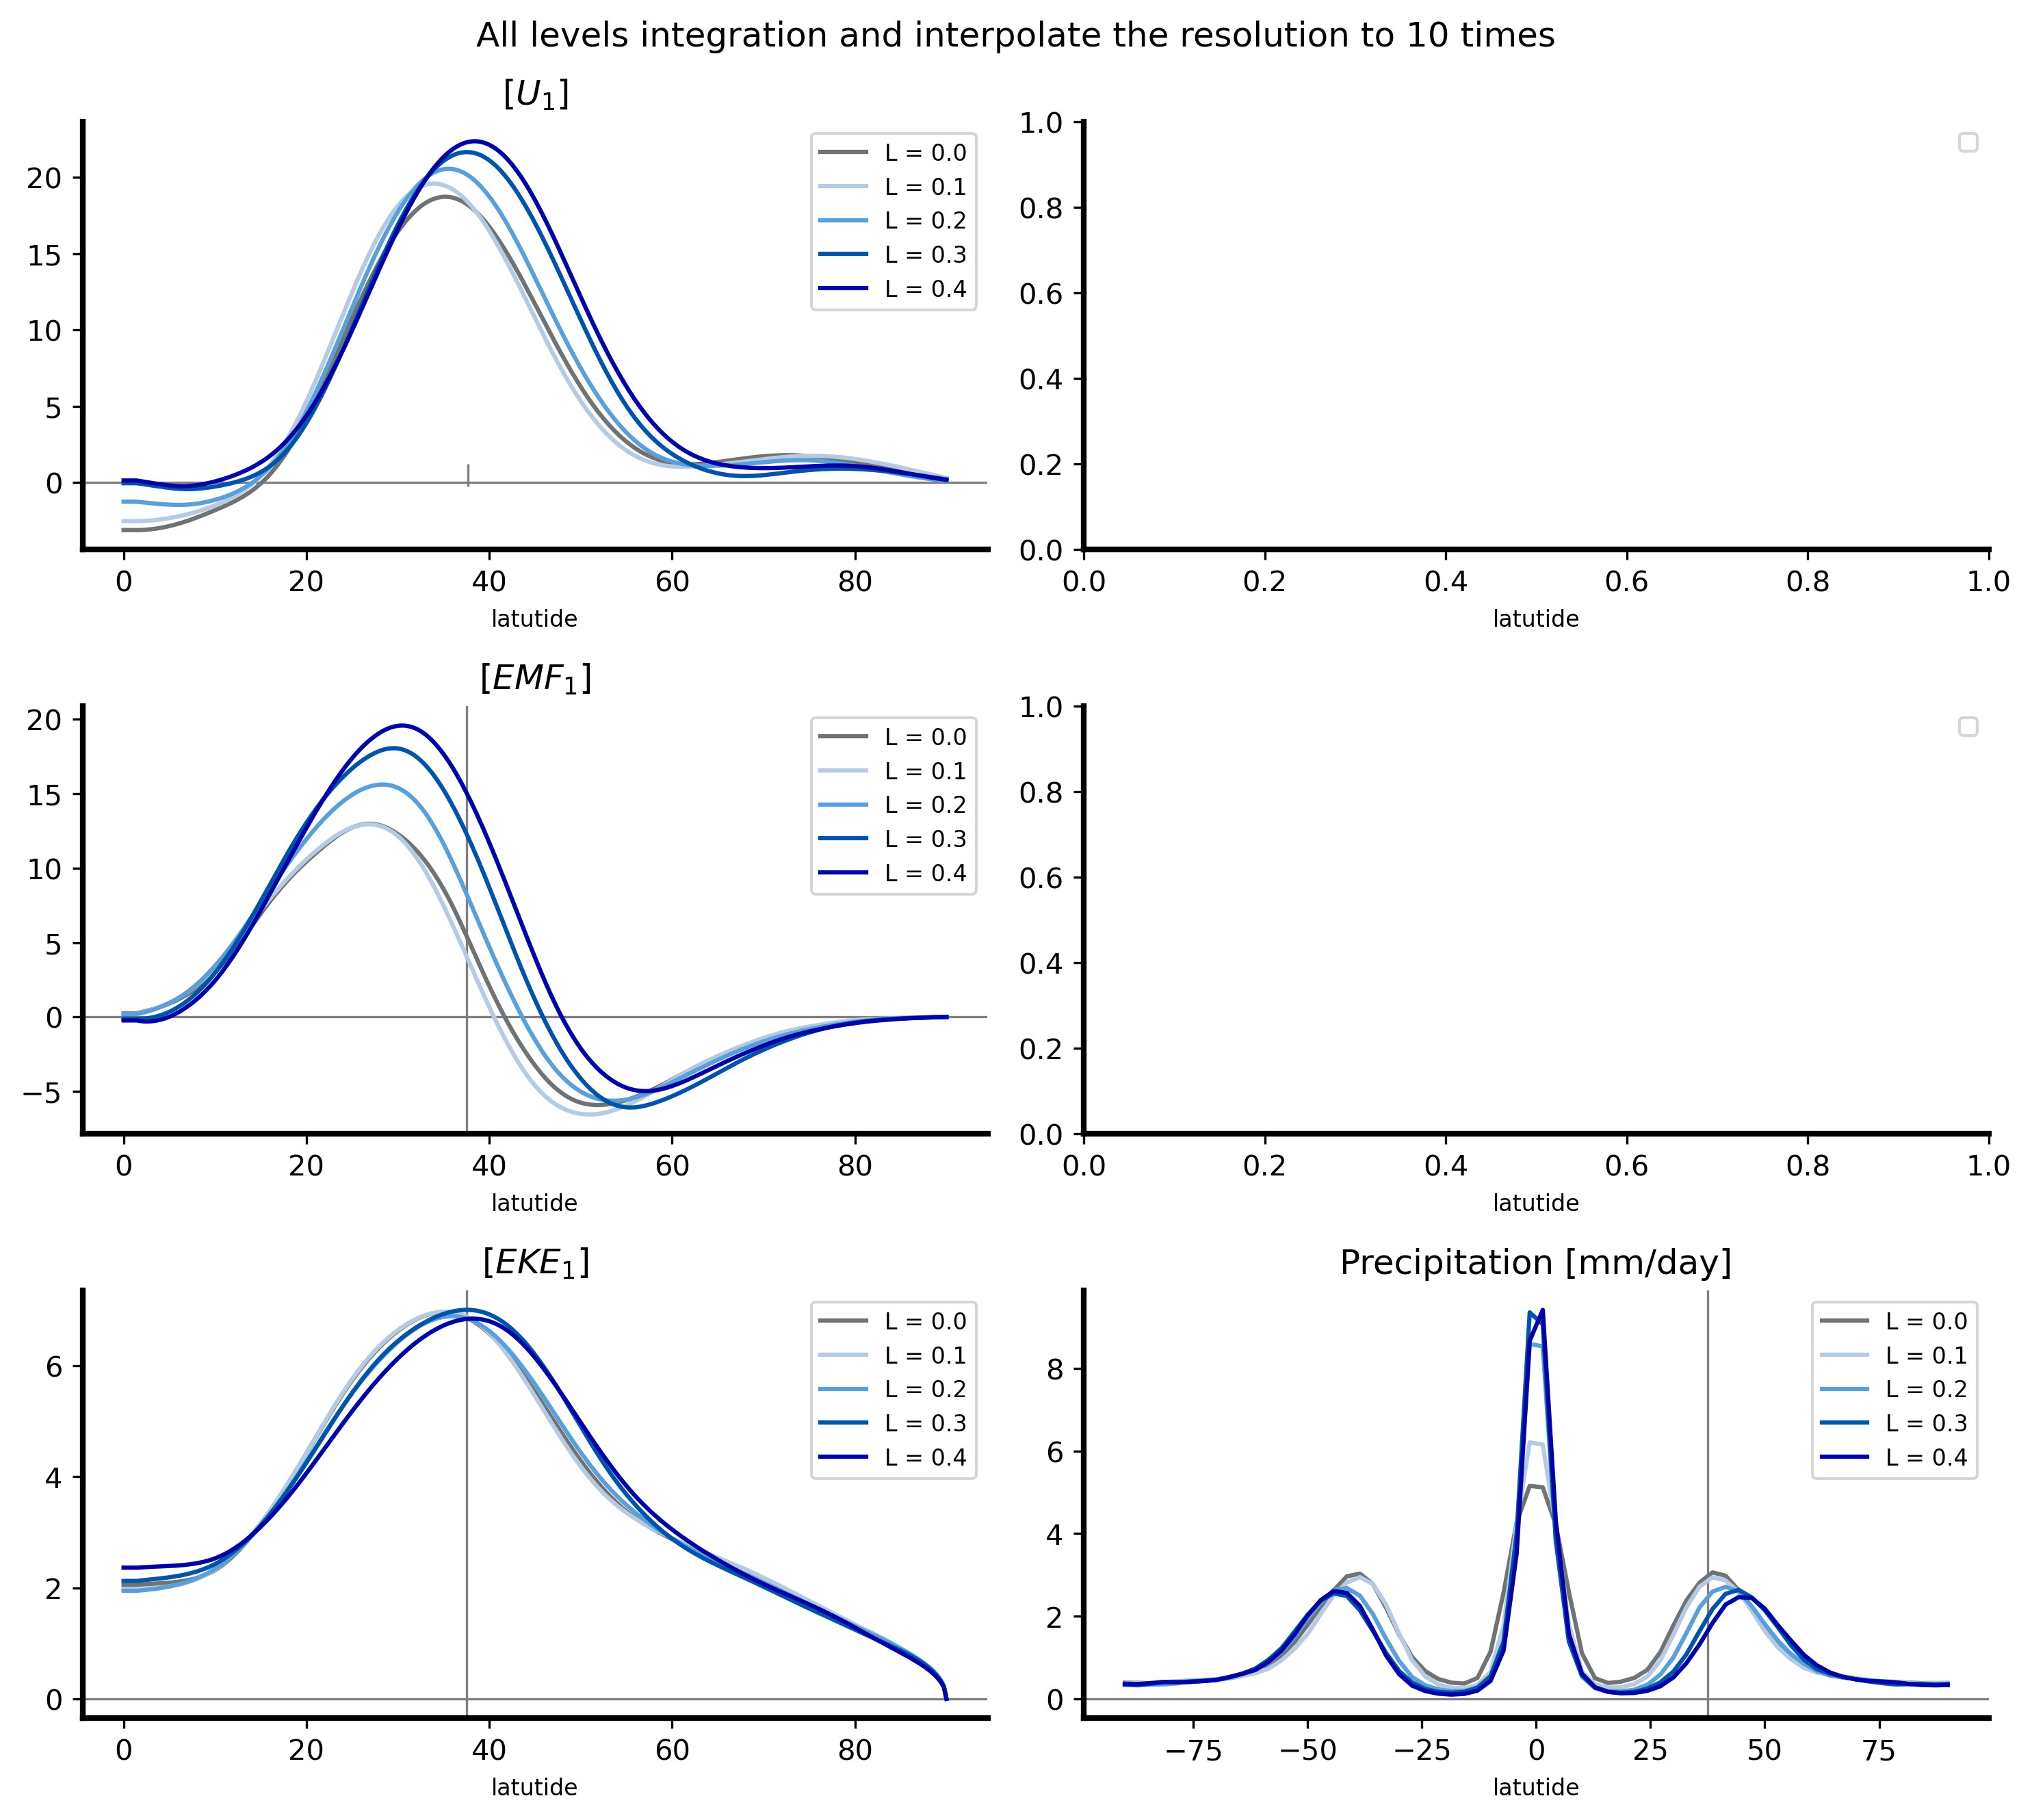

In [270]:
import matplotlib.colors as colors
import matplotlib as mpl
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))



fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
mpl.rcParams['axes.linewidth'] = 2

y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########


do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
g = 9.81
pr_north_idx_z = []
pr_north_idx_y = []


interpolation_times = 10

EMF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EHF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
u_zy_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EKE_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        # if k ==0:
        #     u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
        #     v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
        #     t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
        #     p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
        #     p_half[0:100,:,:,:]             = p_half_ini[k,:,:,:,:]
        #     ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
        #     qv_diff[0:100,:,:,:]             = qv_diff_ini[k,:,:,:,:]
            
            
            
        # else:
            u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
            v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
            t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
            qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
            
    if pr == 0:
        if k ==0:
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
        else:
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
            
        check_days_length = total_day
        sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
        sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
        y               = np.linspace(-90,90,64)
        yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)


    u_zy = np.nanmean(u, axis=(0,3))
    interpolation_times = 10
    u_zy_thin = np.zeros((20*interpolation_times, 32*interpolation_times))


    
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)

    cyy = np.cos(np.deg2rad(yys))
    
    
    interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], u_zy[:,32:])
    u_zy_thin[:,:]         = interp_spline(sigma_mean2s, yys)
    u_zy_thin_check[a,:,:] = u_zy_thin

    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
    
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)

    #########################################################################
    ## EMF
    u_prime        = np.rollaxis((np.rollaxis(u, 3, 0) - np.nanmean(u, axis=3)), 0, 4) 
    v_prime        = np.rollaxis((np.rollaxis(v, 3, 0) - np.nanmean(v, axis=3)), 0, 4) 
    
    # u_prime_w = np.zeros(u_prime.shape)
    # v_prime_w = np.zeros(v_prime.shape)
    # # t_prime_w = np.zeros(t_prime.shape)
    
    # for i in range(total_day):
    #     for j in range(20):
    #         for k in range(128):
    #             u_prime_w[i,j,:,k] = u_prime[i,j,:,k]* cy[:]**0.5
    #             v_prime_w[i,j,:,k] = v_prime[i,j,:,k]* cy[:]**0.5
    #             # t_prime_w[i,j,:,k] = t_prime[i,j,:,k]* cy[:]**0.5
                
                
    
    Mzmtm      = np.nanmean(u_prime * v_prime, axis=(0,3))
    Mzmtm_thin = np.zeros((20*interpolation_times, 32*interpolation_times))
    
    interp_spline        = RectBivariateSpline(sigma_onlyz, y[32:], Mzmtm[:,32:])
    Mzmtm_thin[:,:]      = interp_spline(sigma_mean2s, yys)

    print("Interpolation done")
    
    Mzmtm_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        Mzmtm_thin_w[i,:] = Mzmtm_thin[i,:] * cyy[:]**0.5
    EMF_check[a,:,:] = Mzmtm_thin_w
    #########################################################################
    ## EKE
    # cal first, then interpolate.
    eddy_kinatic_energy    = 0.5 * np.nanmean((u_prime**2 + v_prime**2)**0.5, axis=(0,3))
    EKE_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    EKE_thin_check[a,:,:] = EKE_thin
    

    EKE_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        EKE_thin_w[i,:] = EKE_thin[i,:] * cyy[:]**0.5
    ###
    # for i in range(800):
    #     for j in range(128):
    #     interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    # EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    #########################################################################
    # EHF
    t_prime        = np.rollaxis((np.rollaxis(t, 3, 0) - np.nanmean(t, axis=3)), 0, 4)
    b = t_prime / np.nanmean(t, axis=0) * 9.81
    eddy_flux_heat      = np.nanmean(b * v_prime, axis=(0, 3))
    eddy_flux_heat_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline            = RectBivariateSpline(sigma_onlyz, y[32:], eddy_flux_heat[:,32:])
    eddy_flux_heat_thin[:,:] = interp_spline(sigma_mean2s, yys)
    
    eddy_flux_heat_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        eddy_flux_heat_thin_w[i,:] = eddy_flux_heat_thin[i,:] * cyy[:]**0.5
    EHF_check[a,:,:] = eddy_flux_heat_thin_w
    #########################################################################
    # Precipitation
    Prec = np.zeros(u.shape)
    for i in range(1,20-1):
        Prec[:,i,:,:] = 1/g * qv_diff[:,i,:,:] * (p_half[:,i+1,:,:] - p_half[:,i,:,:])
    Prec[:, 0,:,:] = 1/g * qv_diff[:, 0,:,:] * (p_half[:, 1,:,:] - p_half[:, 0,:,:])
    # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
    
    Prec_mean = np.nansum(Prec, axis=(1))
    Prec_mean_y = np.nanmean(Prec_mean, axis=(0,2))

    

    
    ### plot ###
    """
    # fig[0,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # control = np.nanmax(u_zy_thin[:,:], axis=0)
        # ax[0,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[0,0].vlines(37.6316129032258, ymin=-0.25,ymax=1.25, color='gray', lw=0.8)
        
        ax[0,0].axhline(y=0, color='gray', lw=0.8)
    
    ax[0,0].plot(yys, np.nanmean(u_zy_thin[:,:], axis=0), label=f"L = {pr/100}", color=colors[int(pr/pr_leap)]) #
    ax[0,0].set_title("[$U_{1}$]", fontsize=12)
    """
    # fig[1,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # EMF_control = np.nanmax(Mzmtm_thin_w[:,:], axis=0)
        ax[1,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[1,0].axhline(y=0, color='gray', lw=0.8)

    ax[1,0].plot(yys, np.nanmean(Mzmtm_thin_w[:,:], axis=0) , label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[1,0].set_title("[$EMF_{1}$]", fontsize=12)
    """
    # fig[2,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # EKE_control = np.nanmax(EKE_thin_w[:,:], axis=0)
        ax[2,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[2,0].axhline(y=0, color='gray', lw=0.8)
        
    ax[2,0].plot(yys, np.nanmean(EKE_thin_w[:,:], axis=0), label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[2,0].set_title("[$EKE_{1}$]", fontsize=12)
    """
    # fig[1,1]
    """
    # if pr == 0:
    #     # print("Northern Hemisphere")
    #     EHF_control = np.nanmax(eddy_flux_heat_thin_w[:,:], axis=0)
    #     ax[1,1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    #     ax[1,1].axhline(y=0, color='gray', lw=0.8)
        
    # ax[1,1].plot(yys, np.nanmean(eddy_flux_heat_thin_w[:,:], axis=0) / EHF_control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    # ax[1,1].set_title("[$EHF_{1}$]", fontsize=12)
    """
    # fig[2,1]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # EHF_control = np.nanmax(eddy_flux_heat_thin_w[biggest_u_z_idx,:])
        ax[2,1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[2,1].axhline(y=0, color='gray', lw=0.8)
        
    ax[2,1].plot(y[:], Prec_mean_y[:]*86400, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[2,1].set_title("Precipitation [mm/day]", fontsize=12)
    

    a += 1

for i in range(3):
    for j in range(2):
        ax[i,j].spines["right"].set_visible(False)
        ax[i,j].spines["top"].set_visible(False)
        ax[i,j].set_xlabel("latutide", fontsize=8)
        ax[i,j].legend()
        ax[i,j].legend(prop={'size': 8})
        
        
mpl.rcParams['axes.linewidth'] = 1.5
        
plt.suptitle(f"All levels integration and interpolate the resolution to {interpolation_times} times")

fig.tight_layout()
# plt.savefig("Nick_fig1_PR0_50.png", dpi=300., bbox_inches='tight')
plt.show()

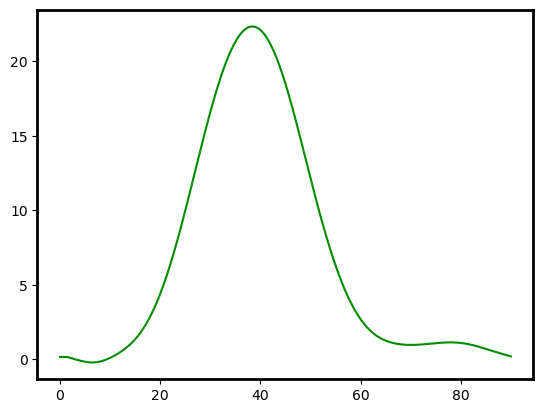

In [265]:
plt.figure()
plt.plot(yys, np.nanmean(u_zy_thin[:,:], axis=0) ,label=f"L = {pr/100}", color=colors[int(pr/pr_leap)]) #


In [76]:
EMF_check.shape
EMF_check_w = np.zeros(EMF_check.shape)
for i in range(6):
    for j in range(200):
        EMF_check_w[i,j,:] = EMF_check[i,j,:] * cyy[:]**0.5

0
1
2
3
4
5


Text(0.5, 1.0, 'EMF using all levels vertical integration')

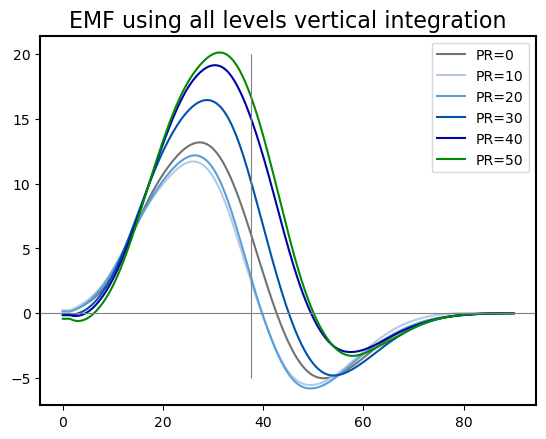

In [77]:
plt.figure()
for i in range(6):
    EMF_check_vertical_mean = np.nanmean(EMF_check[i,:,:], axis=0)
    print(i)
    plt.plot(yys, EMF_check_vertical_mean, label=f"PR={i*10}", color=colors[int(i)])
# plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.vlines(37.6316129032258, ymin=-5,ymax=20, color='gray', lw=0.8)

plt.axhline(y=0, color='gray', lw=0.8)
plt.legend()
plt.title("EMF using all levels vertical integration", fontsize=16)
#####################################################################
plt.figure()
for i in range(6):
    EMF_check_vertical_mean = np.nanmean(u[i,:,:], axis=0)
    print(i)
    plt.plot(yys, EMF_check_vertical_mean, label=f"PR={i*10}", color=colors[int(i)])
# plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.vlines(37.6316129032258, ymin=-5,ymax=20, color='gray', lw=0.8)

plt.axhline(y=0, color='gray', lw=0.8)
plt.legend()
plt.title("EMF using all levels vertical integration", fontsize=16)

In [81]:
u_check = np.zeros(((6, 20, 64)))
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if k ==0:
            u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
            t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            p_half[0:100,:,:,:]             = p_half_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
            qv_diff[0:100,:,:,:]             = qv_diff_ini[k,:,:,:,:]
            
            
            
        else:
            u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
            v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
            t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
            qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
            
    if pr == 0:
        if k ==0:
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
        else:
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
    u_check[a,:,:] = np.nanmean(u, axis=(0,3))
    a += 1
    

In [82]:
u_check.shape

(6, 20, 64)

PR: 0 ,maximum [z index, y index]: 49 133
PR: 10 ,maximum [z index, y index]: 49 133
PR: 20 ,maximum [z index, y index]: 48 133
PR: 30 ,maximum [z index, y index]: 46 133
PR: 40 ,maximum [z index, y index]: 43 133
PR: 50 ,maximum [z index, y index]: 41 133


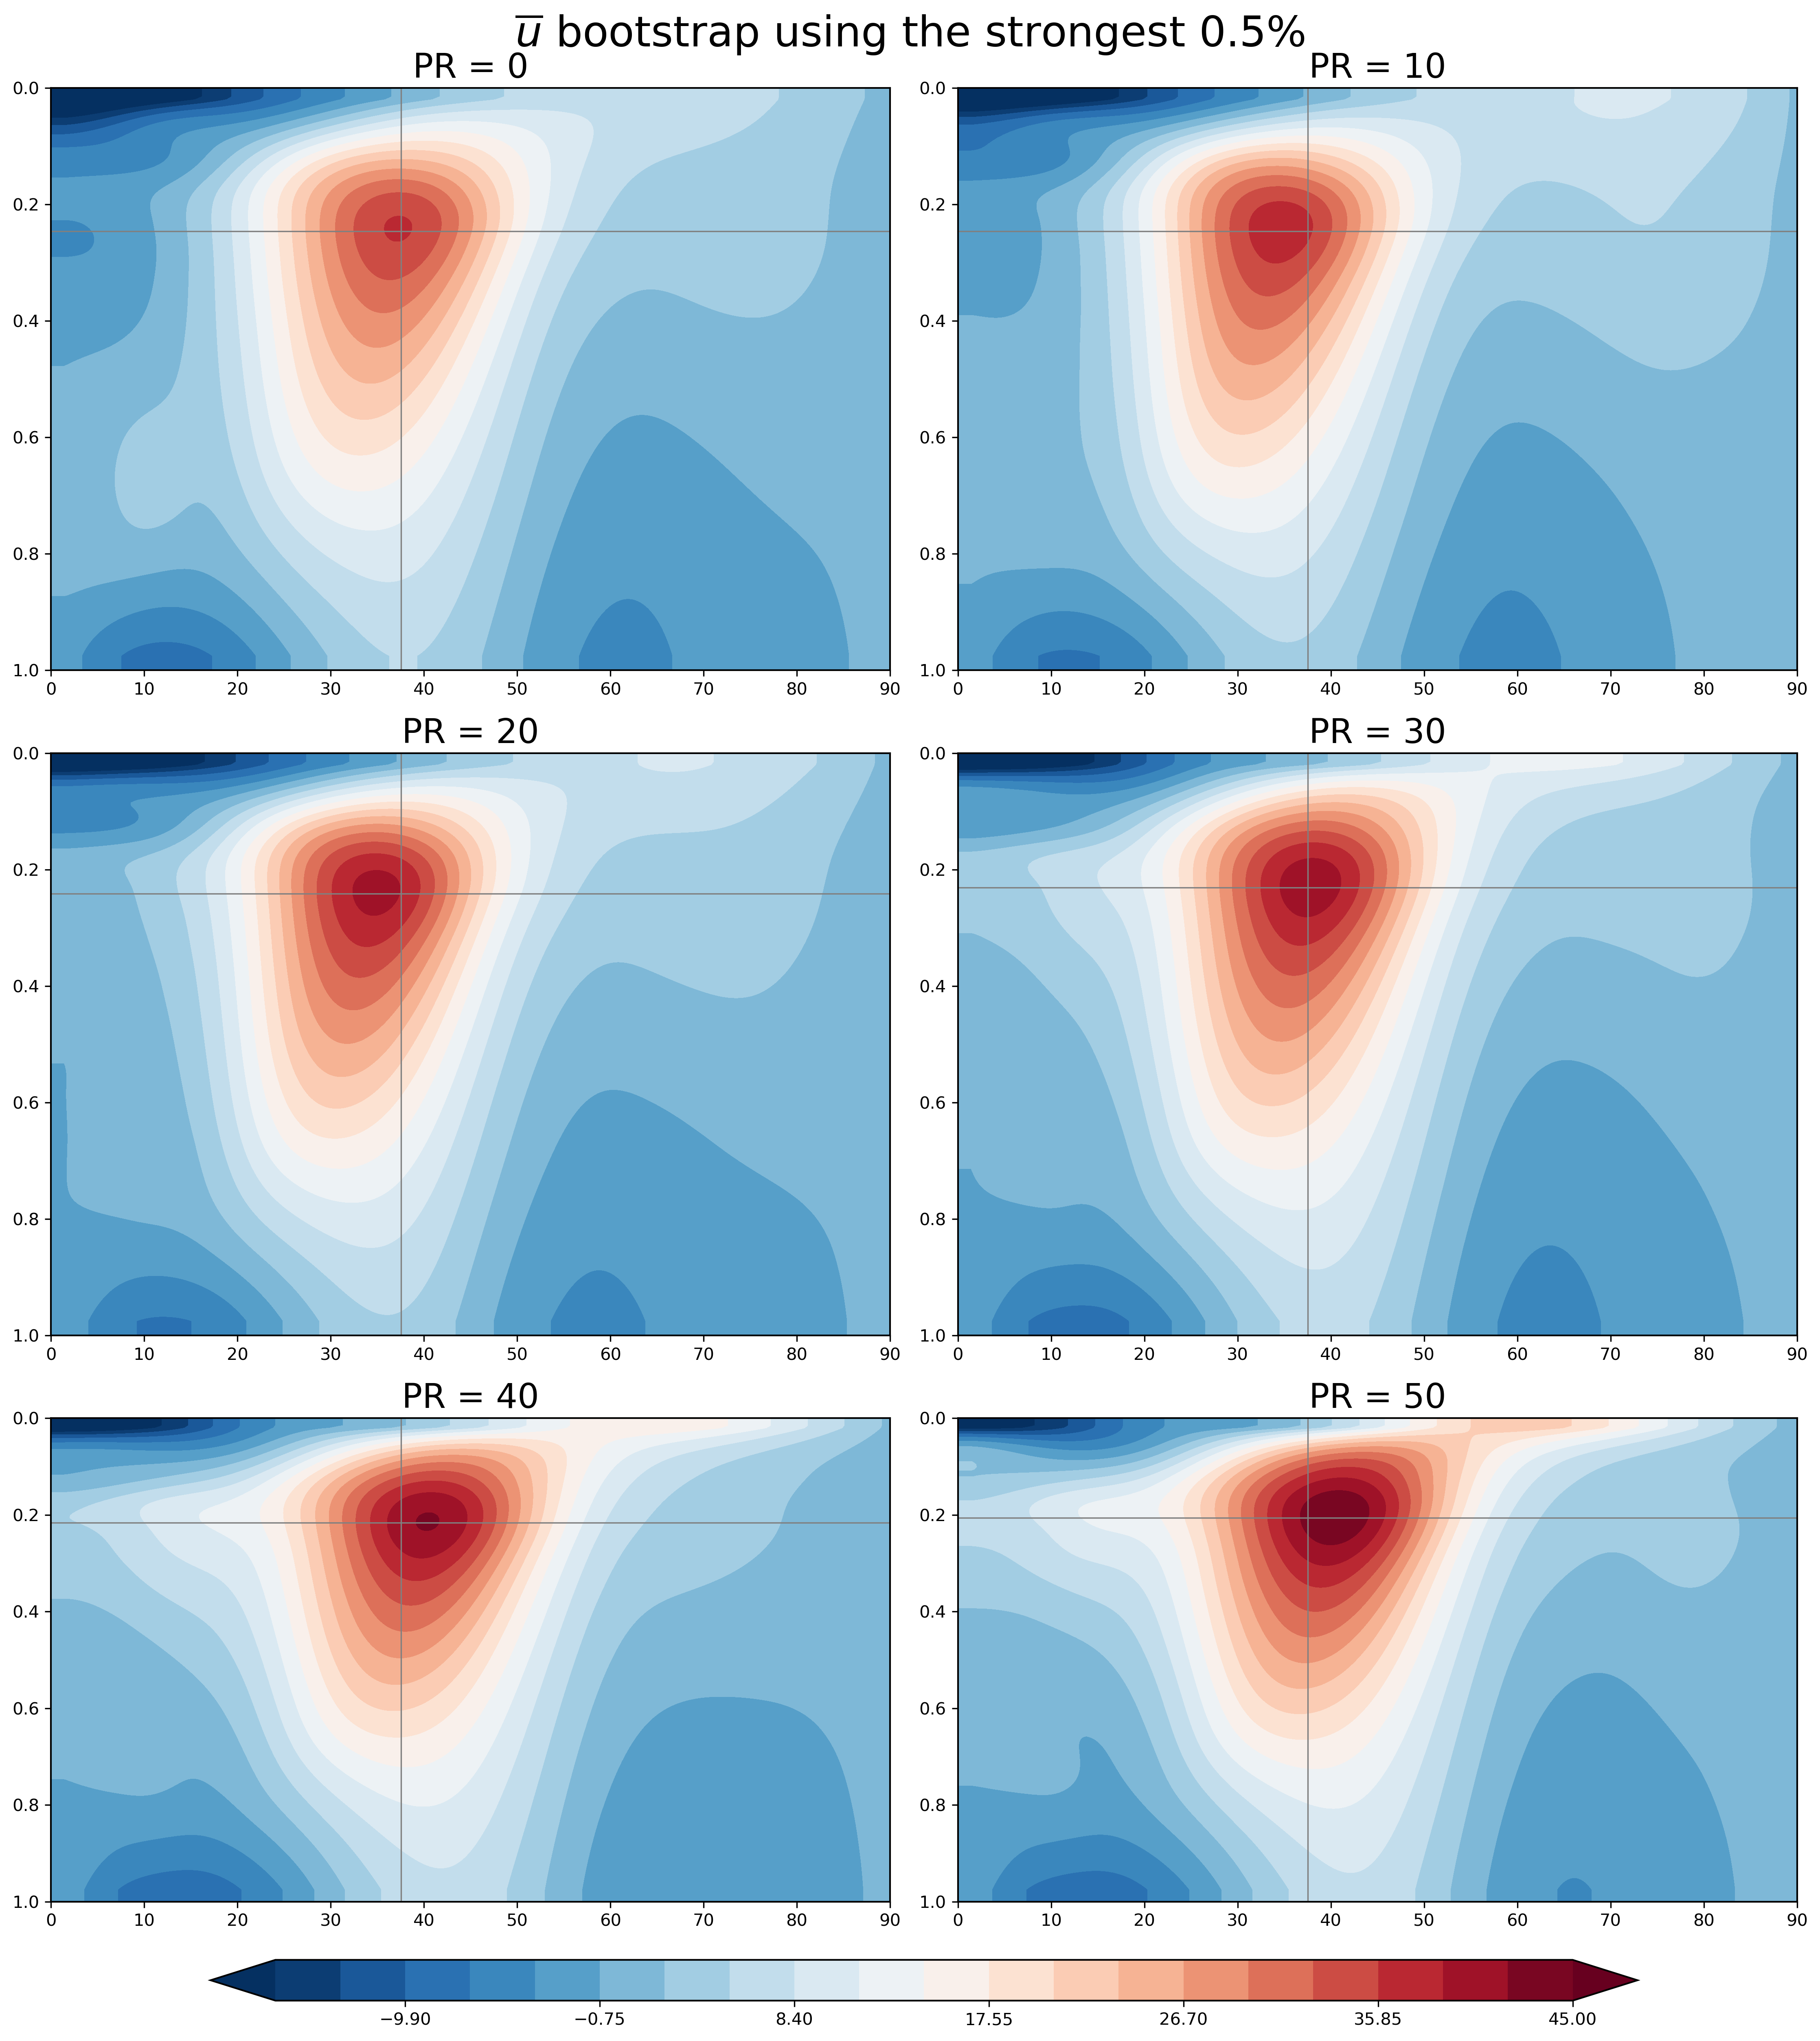

In [904]:
just_check = False
want_output_pic = True
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,25), dpi=100.)
    mpl.rcParams['axes.linewidth'] = 1
    
    for i in range(total_pr):
        pr = i*pr_leap
        biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
        biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
        print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[i,:,:], levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{u}$", fontsize=16)
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    # plt.savefig("U_PR0_50.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()
    
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    mpl.rcParams['axes.linewidth'] = 1
    pr = 0 
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[int(pr/pr_leap),:,:], levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += pr_leap
    plt.suptitle("$\overline{u}$ bootstrap using the strongest 0.5%", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig(f"05bootstrap_U_PR{pr_start}_{pr_to}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()


PR: 0 ,maximum [z index, y index]: 49 133
PR: 10 ,maximum [z index, y index]: 49 133
PR: 20 ,maximum [z index, y index]: 48 133
PR: 30 ,maximum [z index, y index]: 46 133
PR: 40 ,maximum [z index, y index]: 43 133
PR: 50 ,maximum [z index, y index]: 41 133


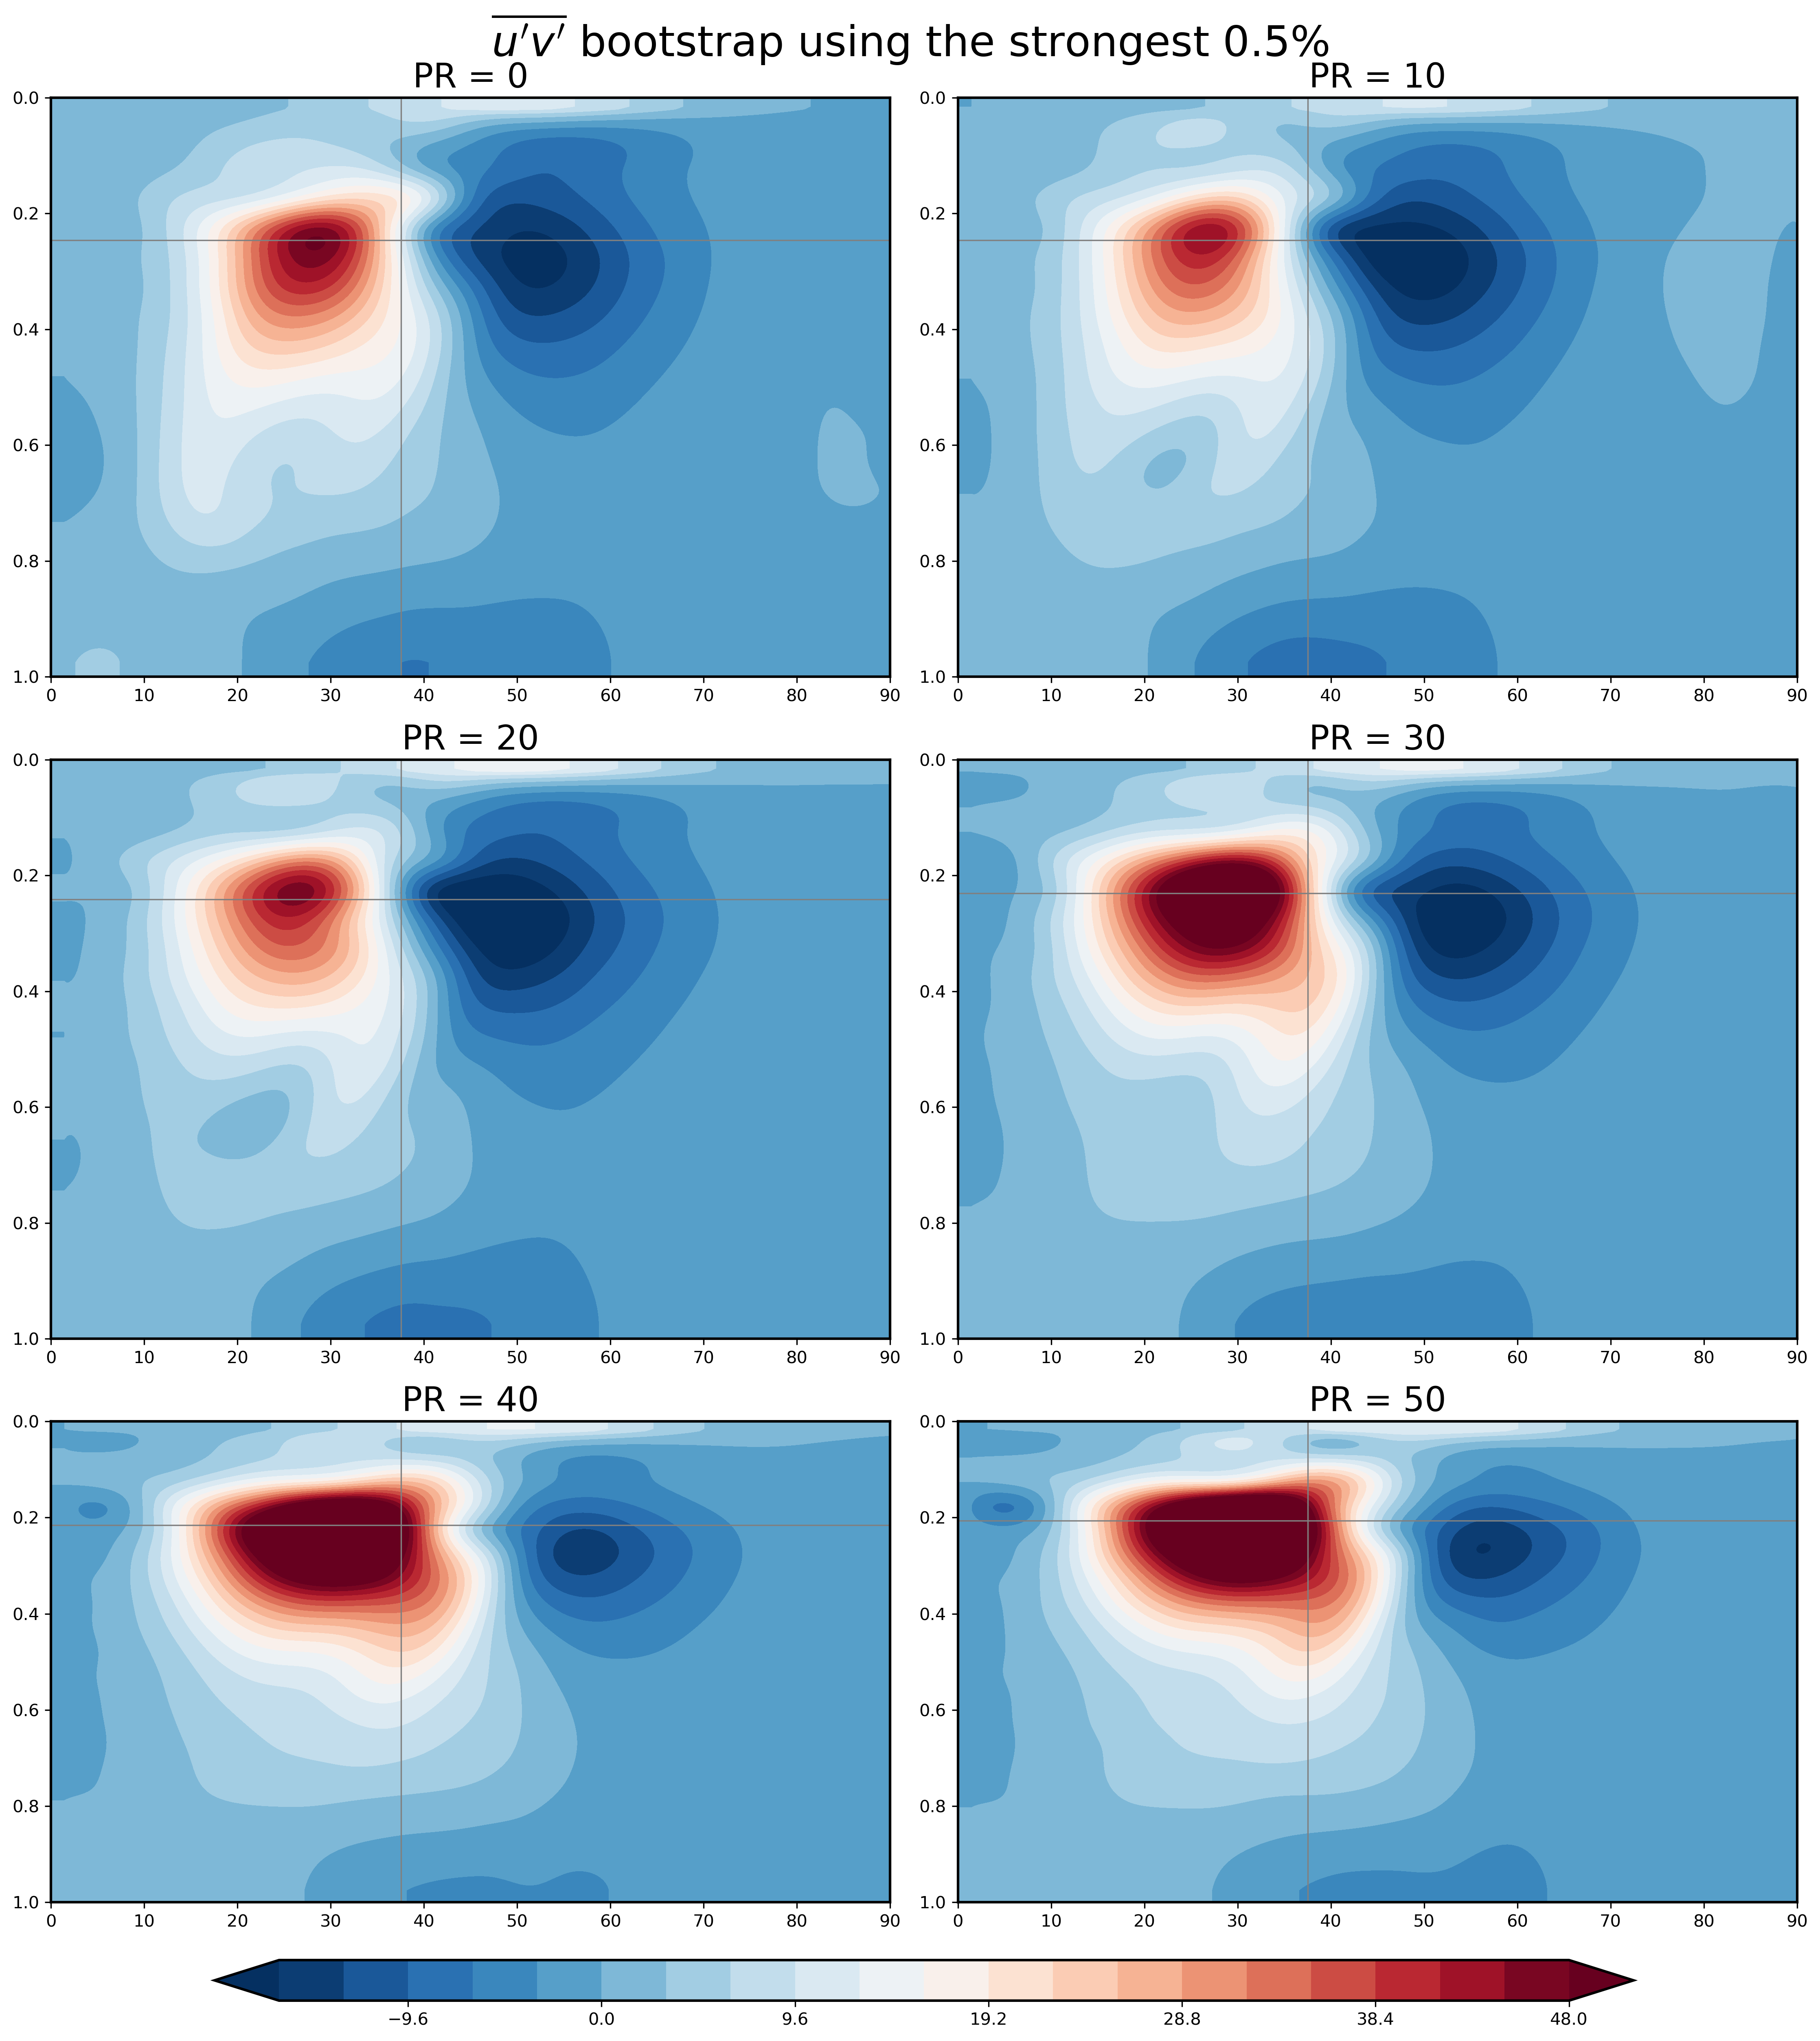

In [1105]:
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,30), dpi=100.)
    pr = 0
    for i in range(total_pr):
        pr = i*pr_leap
        biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
        biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
        print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EMF_check[i,:,:], levels=np.linspace(-16,48,21), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{u'v'}$")
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    plt.show()
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    pr = 0
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EMF_check[int(pr/pr_leap),:,:], levels=np.linspace(-16,48,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += pr_leap
    plt.suptitle("$\overline{u'v'}$ bootstrap using the strongest 0.5%", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig(f"05bootstrap_EMF_PR{pr_start}_{int(pr_to-pr_leap)}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()


In [1189]:
##################################################################
def plot_contourf_near0_fixcolorbar(X, Y ,var_near0, aa, cbar_lim, i, j, ax, shading_levels = 9, least_levels = 4, near0white = True, my_cmap = 'coolwarm'):
    from matplotlib.colors import ListedColormap
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm
    #####
    import matplotlib.colors as colors
    a, antialiased = 1,  True
#     a, antialiased = 0.7, True
#     a, antialiased = 0.9, True
#     a, antialiased = 1, False
    
    my_cmap = plt.colormaps[my_cmap]  
    
    # create random data with cbar_lim
    rngdata = np.random.uniform(low=cbar_lim[0], high=cbar_lim[1], size=(len(Y),len(X)))
    print(np.shape(rngdata))
    # make sure the min and Max value are included
    rngdata[0,0] = cbar_lim[0]
    rngdata[-1,-1] = cbar_lim[1]
    
    # get contour levels with random data
    # cs = plt.contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)

    # i, j = 0,0
    cs = ax[i,j].contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    ax[i,j].invert_yaxis()
    
    
    auto_levels_rng = cs.levels.copy()
    plt.gca().clear()

    # cs = plt.contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    cs = ax[i,j].contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    auto_levels2 = cs.levels.copy()
    #cbar = add_colorbar(cs)#plt.colorbar()
    #plt.show()

    if ~((np.min(auto_levels2) >= 0) | (np.max(auto_levels2) <= 0)):
        plt.gca().clear()
        
        try:
            cbar.remove()
        except:
            pass
        
        # check levels of both ends
        # if either end has contour levels less than 'least_levels', create custom levels
        if ((len(np.where(auto_levels2 > 0)[0]) < least_levels) | (len(np.where(auto_levels2 < 0)[0]) < least_levels)):
            # cs = plt.contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            cs = ax[i,j].contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            auto_levels1 = cs.levels.copy()
        #     plt.colorbar()
        #     plt.show()
            plt.gca().clear()
            if (len(np.where(auto_levels2 > 0)[0]) > len(np.where(auto_levels2 < 0)[0])):
                   custom_levels = np.concatenate((np.linspace(np.min(auto_levels1), 0, least_levels+1), 
                                    auto_levels2[auto_levels2 > 0]))

            else:
                   custom_levels = np.concatenate((auto_levels2[auto_levels2 < 0], 
                                               np.linspace(0,np.max(auto_levels1),least_levels+1)))

            #custom_levels = np.unique(custom_levels)
            custom_levels_bar = custom_levels
        else:

            custom_levels = auto_levels2
            custom_levels_bar = custom_levels

        # create white shading around 0
        if near0white:
            custom_lower = custom_levels[custom_levels < 0]
            dlevel_lower = custom_lower[1] - custom_lower[0]
            custom_lower_near0 = np.concatenate((custom_lower, [0 - dlevel_lower/5]))

            custom_upper = custom_levels[custom_levels > 0]
            dlevel_upper = custom_upper[1] - custom_upper[0]
            custom_upper_near0 = np.concatenate(([dlevel_upper/5 - 0] ,custom_upper))

            custom_levels_near0 = np.concatenate((custom_lower_near0, [0], custom_upper_near0))

            mycmap_lower_near0 = my_cmap(np.linspace(0, 0.5, len(custom_levels_near0[custom_levels_near0 < 0])))
            mycmap_upper_near0 = my_cmap(np.linspace(0.5, 1, len(custom_levels_near0[custom_levels_near0 >= 0])))[1:]
            all_colors = np.vstack((mycmap_lower_near0, mycmap_upper_near0))

            all_colors[np.where(custom_levels_near0 == 0)[0]] = [1, 1, 1, 1] # set to white
            all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [1, 1, 1, 1]
            
#             all_colors[np.where(custom_levels_near0 == 0)[0]] = [0.85, 0.85, 0.85, 1] # set to gray
#             all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [0.85, 0.85, 0.85, 1]

            #all_colors[:,0:3] *= a


            mycmap_near0 = colors.LinearSegmentedColormap.from_list('mycmap_near0', all_colors)

            custom_levels = custom_levels_near0
            mycmap = mycmap_near0
        else:
            mycmap = my_cmap


        norm = colors.BoundaryNorm(boundaries=custom_levels, ncolors=256)

        # cs = plt.contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
        cs = ax[i,j].contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
        plt.gca().invert_yaxis()
        
        ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[i,j].set_title(f"PR={int(aa*10)}", fontsize=16)

#         cbar = plt.colorbar(spacing="proportional")#cbar = add_colorbar(cs, aspect=8, pad_fraction=0.8)#

#         cbar.set_ticks(custom_levels_bar)
#         ticklabs = cbar.ax.get_yticklabels()
#         cbar.ax.set_yticklabels(ticklabs, fontsize=14)
        
    #####
    return custom_levels, custom_levels_bar, cs
########################################################################

In [1069]:
### try EMF calculate outside ###
# u_prime_w = np.zeros(u.shape)
# v_prime_w = np.zeros(u.shape)
# y_outside = np.linspace(-90,90,64)
# yd_outside = np.cos(np.deg2rad(y_outside))
# for i in range(800):
#     for j in range(20):
#         for k in range(128):
#             u_prime_w[i,j,:,k] = u_prime[i,j,:,k] * yd_outside[:]**0.5
#             v_prime_w[i,j,:,k] = v_prime[i,j,:,k] * yd_outside[:]**0.5
u_prime_new = np.zeros((((800, 20, 64,128))))
for i in range(128):
    u_prime_new[:,:,:,i] = u[:,:,:,i] - np.nanmean(u, axis=3)

In [1070]:
v_prime_new = np.zeros((((800, 20, 64, 128))))
for i in range(128):
    v_prime_new[:,:,:,i] = v[:,:,:,i] - np.nanmean(v, axis=3)

In [1071]:
EMF_outside = np.nanmean(u_prime_new* v_prime_new, axis=(0,3))
print(np.shape(EMF_outside))

(20, 64)


In [1073]:
dmdy = np.zeros((20,64))
r = 6371e3
for i in range(1,64-1):
    dmdy[:,i] = -(EMF_outside[:,i+1] - EMF_outside[:,i-1]) / (r * (yys[i+1] - yys[i-1]))
dmdy[:, 0] = -(EMF_outside[:, 1] - EMF_outside[:, 0]) / (r*(yys[ 1] - yys[ 0]))
dmdy[:,-1] = -(EMF_outside[:,-1] - EMF_outside[:,-2]) / (r*(yys[-1] - yys[-2]))

# dmdy = np.zeros((200,320))
# r = 6371e3
# for i in range(1,320-1):
#     dmdy[:,i] = -(EMF_outside[:,i+1] - EMF_outside[:,i-1]) / (r * (yys[i+1] - yys[i-1]))
# dmdy[:, 0] = -(EMF_outside[:, 1] - EMF_outside[:, 0]) / (r*(yys[ 1] - yys[ 0]))
# dmdy[:,-1] = -(EMF_outside[:,-1] - EMF_outside[:,-2]) / (r*(yys[-1] - yys[-2]))
print(dmdy.shape)

(20, 64)


In [1064]:
yys.shape

(320,)

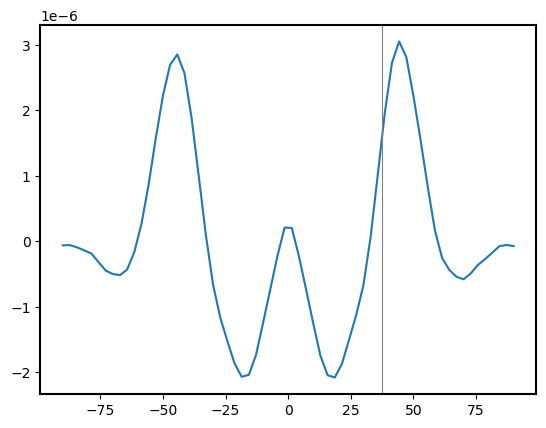

In [1076]:
dmdy_mean =  np.nanmean(dmdy, axis=0)
plt.figure()
plt.plot(y,dmdy_mean)
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)


In [1051]:
EMF_check_w.shape

(6, 200, 320)

(1.0, 0.0)

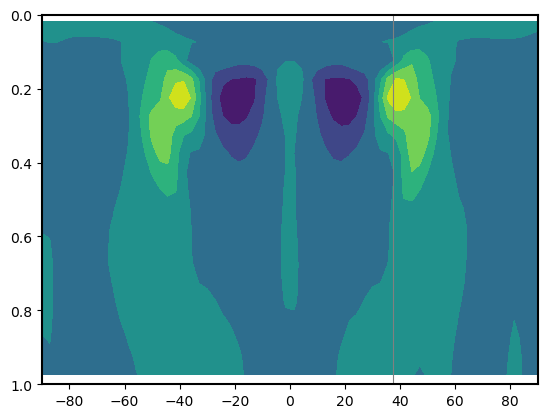

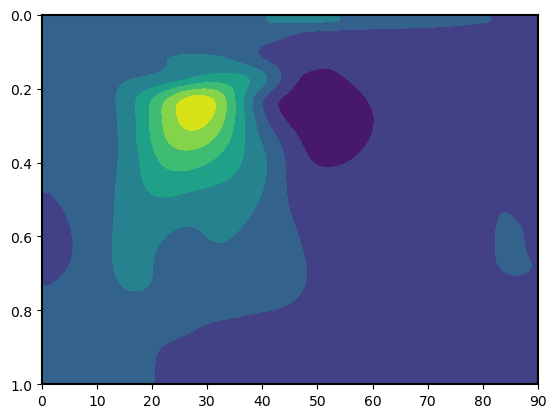

In [1079]:
plt.figure()
plt.contourf(yy, sigma_mean2, dmdy)
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.ylim([1,0])
plt.figure()
plt.contourf(yys, sigma_mean2s, EMF_check_w[0,:,:])
plt.ylim([1,0])

PR: 0 ,maximum [z index, y index]: 49 133
(200, 320)
(200, 320)
(200, 320)
(200, 320)
(200, 320)
(200, 320)


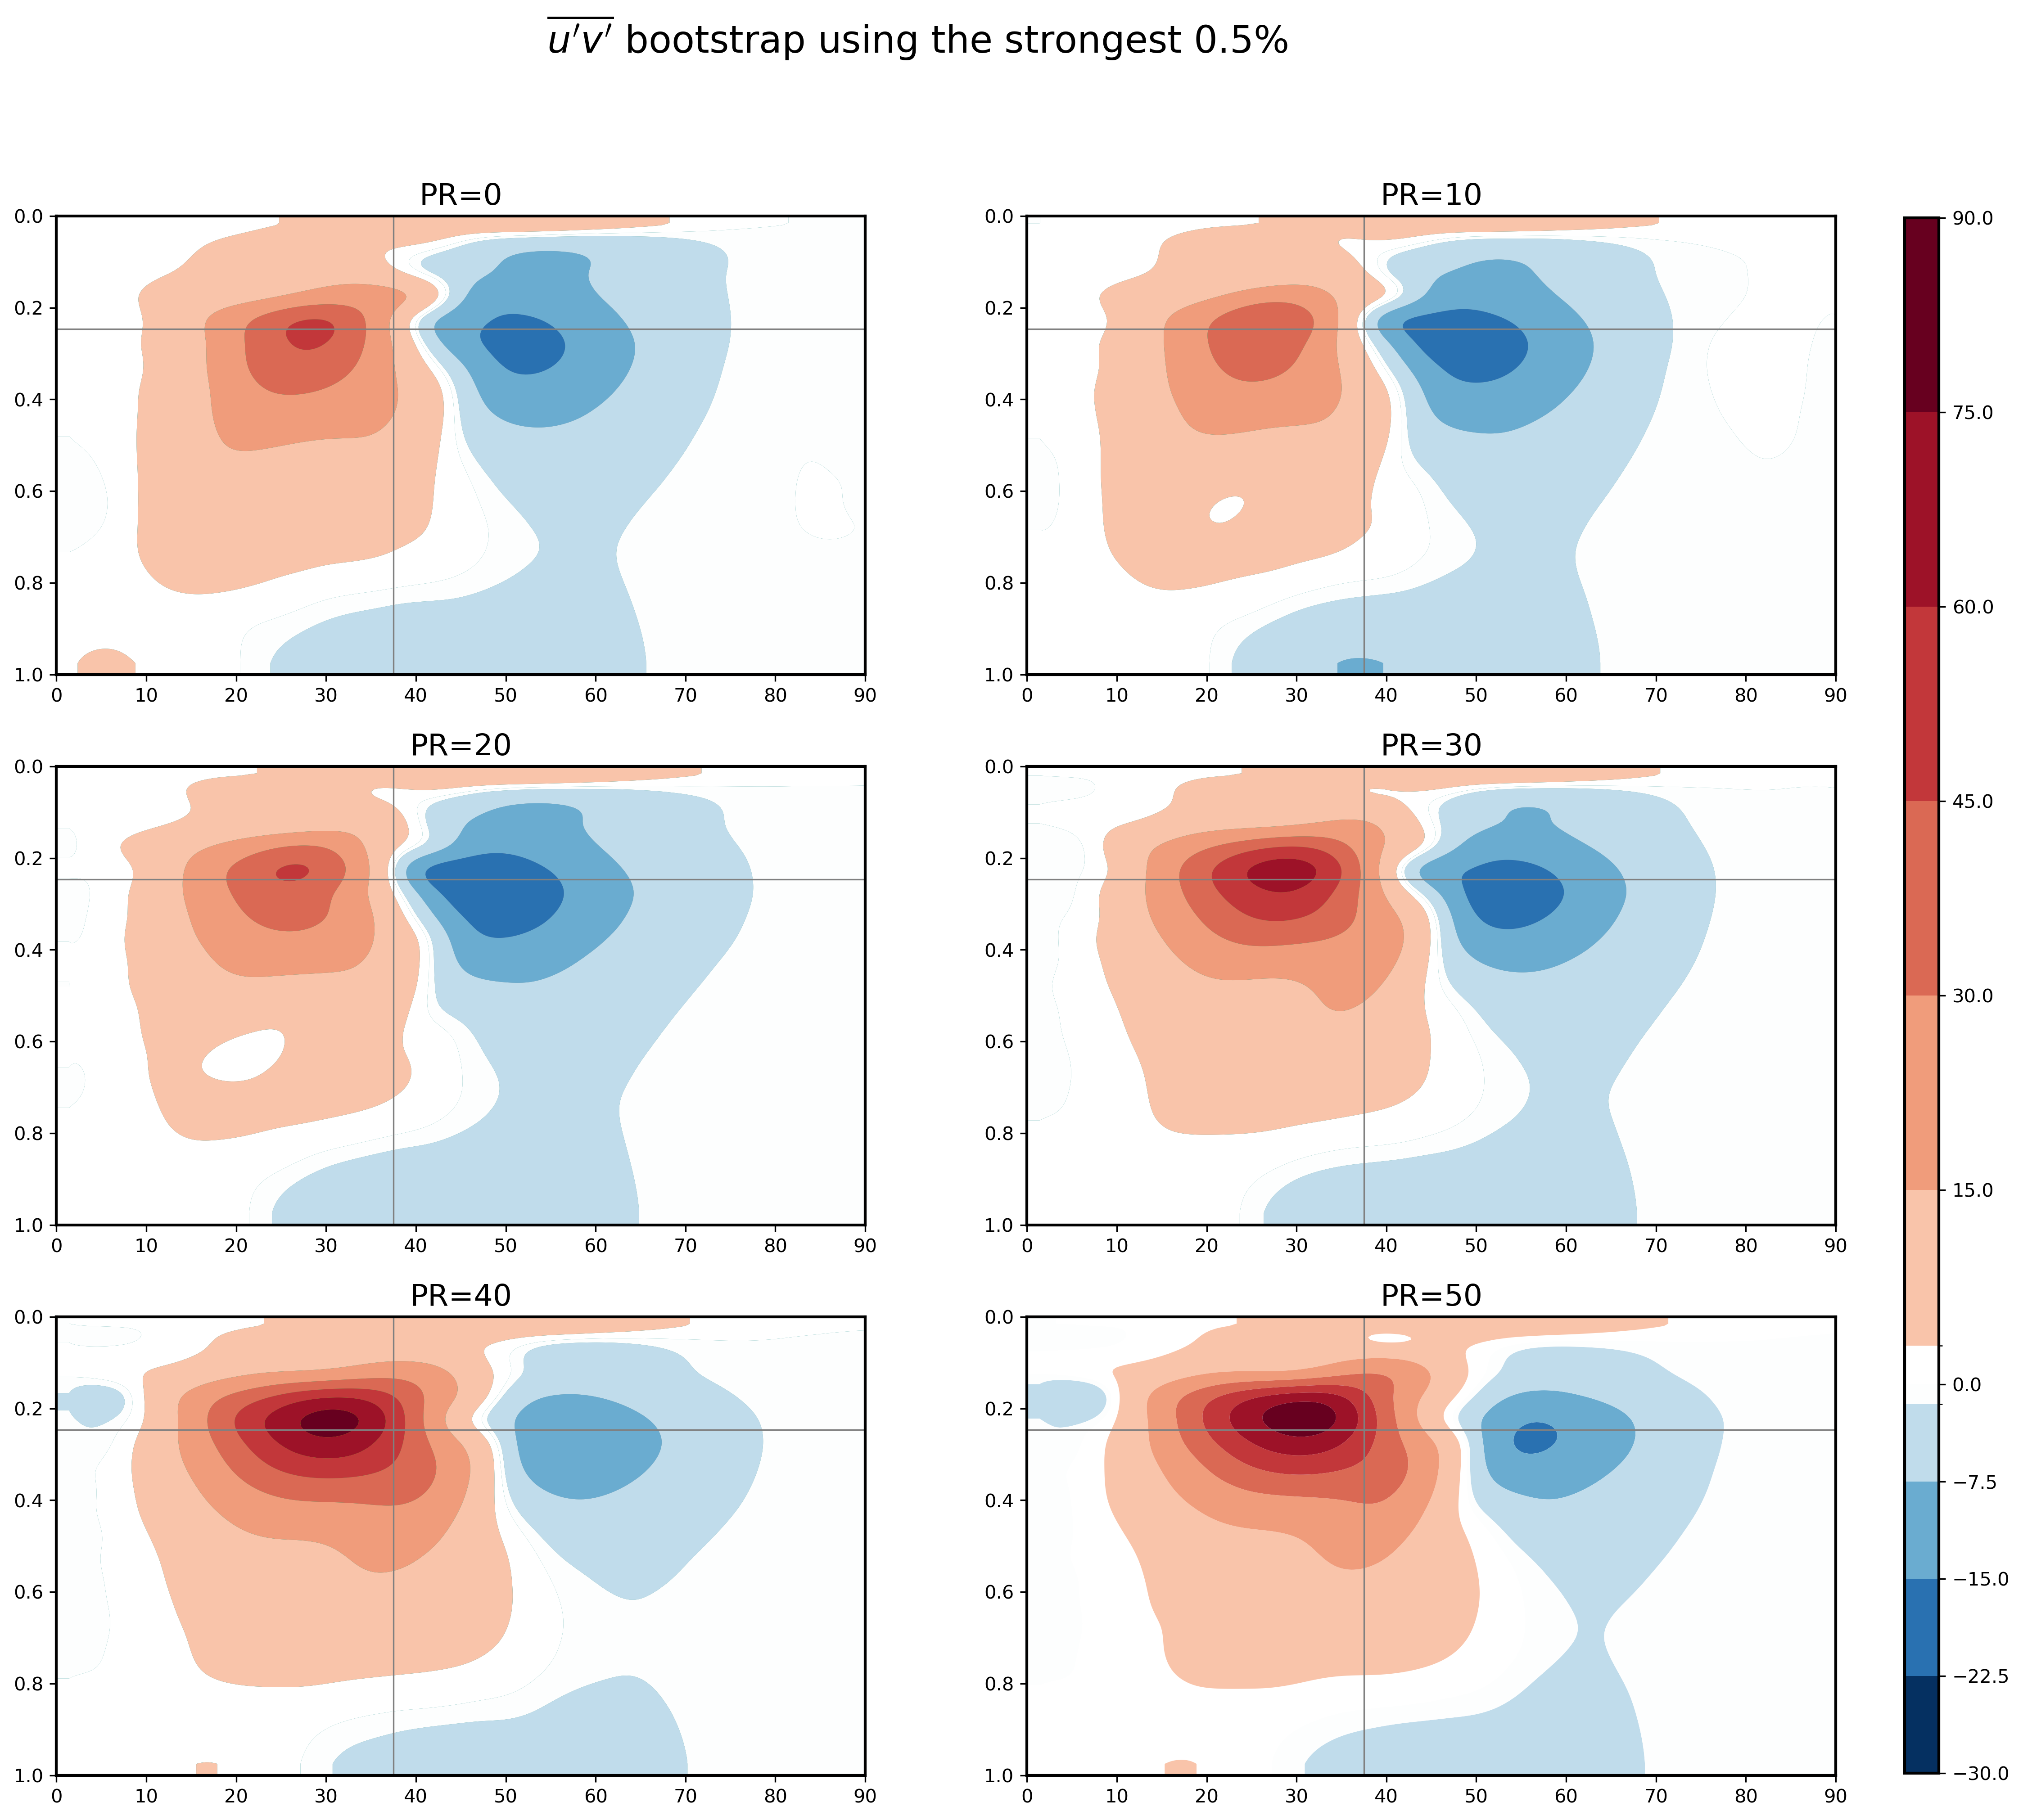

In [1190]:
########################### EMF try new colorbar ################

EMF_check_w = np.zeros(EMF_check.shape)
for i in range(6):
    for j in range(200):
        EMF_check_w[i,j,:] = EMF_check[i,j,:] * cyy[:]**0.5

if want_output_pic:
    # fig, ax = plt.subplots(6, figsize=(10,8), dpi=300.)
    pr = 0
    # for i in range(3):
        # for j in range(2):
        # pr = i*pr_leap
    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
    # CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EMF_check[int(pr/pr_leap),:,:], levels=np.linspace(-16,48,21), cmap="RdBu_r", extend="both")
    # plt.title(f"PR = {pr}", fontsize=20)

    #############################################################
    aa = 0

    for i in range(3):
        for j in range(2):
            if i ==0 and j ==0:
                fig, ax = plt.subplots(3,2, figsize=(17,15), dpi=300.)
            _,custom_levels_bar,cs=plot_contourf_near0_fixcolorbar(yys, sigma_mean2s, EMF_check[int(aa),:,:], aa, cbar_lim = [-20, 90], i=i, j=j, ax=ax, my_cmap="RdBu_r") # ,my_cmap = 'BlueYellowRed'
            aa += 1

    # add colorbar to subplots without shrinking figure
    cbar_ax = plt.gcf().add_axes([0.93, 0.111, 0.015, 0.768])
    cb = plt.colorbar(mappable = cs, cax=cbar_ax, spacing="proportional")
    cb.set_ticks(custom_levels_bar)
            ############################################################
            # pr += pr_leap
    plt.suptitle("$\overline{u'v'}$ bootstrap using the strongest 0.5%", fontsize=20)
    
    
    # fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    # plt.savefig(f"05bootstrap_EMF_PR{pr_start}_{int(pr_to-pr_leap)}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    # plt.show()
########################################################### ###


PR: 0 ,maximum [z index, y index]: 49 133
PR: 10 ,maximum [z index, y index]: 49 133
PR: 20 ,maximum [z index, y index]: 48 133
PR: 30 ,maximum [z index, y index]: 46 133
PR: 40 ,maximum [z index, y index]: 43 133
PR: 50 ,maximum [z index, y index]: 41 133


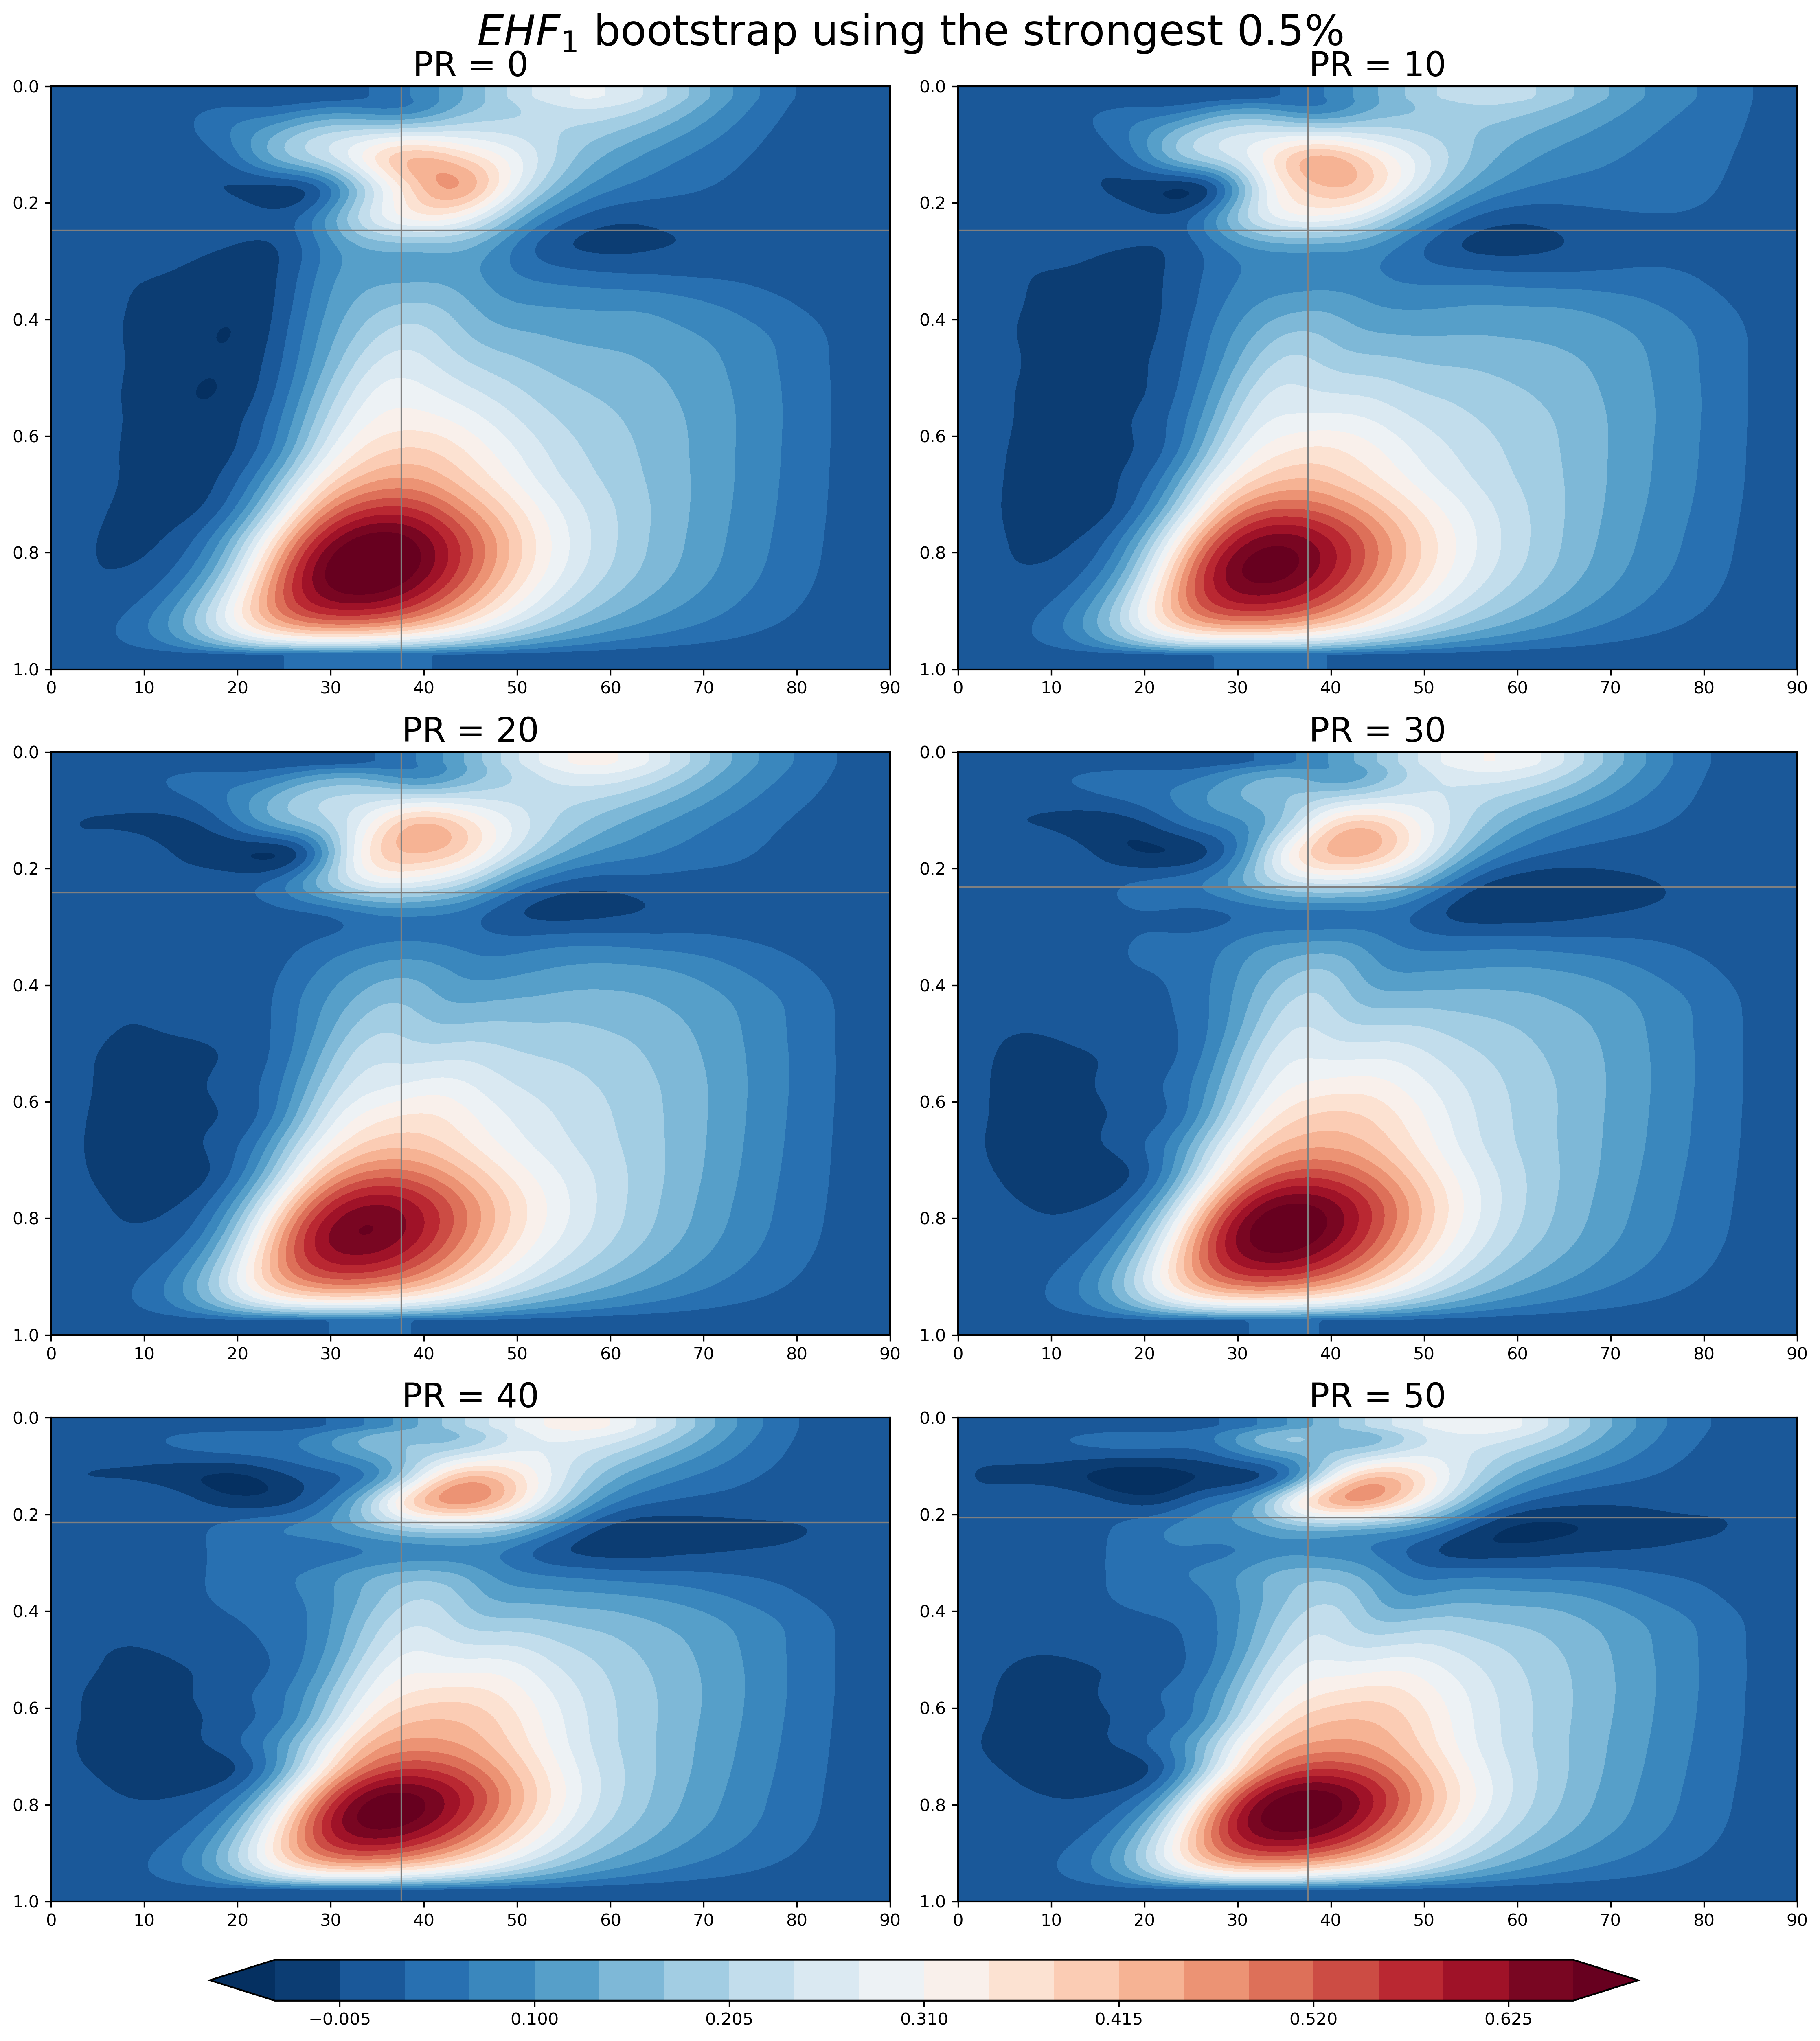

In [912]:
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,25), dpi=100.)
    for i in range(total_pr):
        # pr = i*pr_leap
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EHF_check[i,:,:], levels=21, cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{v'b'}$")
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    plt.show()
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    pr = 0
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EHF_check[int(pr/pr_leap),:,:], levels=np.linspace(-0.04,0.66,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += pr_leap
    plt.suptitle("$EHF_{1}$ bootstrap using the strongest 0.5%", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig(f"05bootstrap_EHF_PR{pr_start}_{int(pr_to-pr_leap)}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()

PR: 0 ,maximum [z index, y index]: 49 133
PR: 10 ,maximum [z index, y index]: 49 133
PR: 20 ,maximum [z index, y index]: 48 133
PR: 30 ,maximum [z index, y index]: 46 133
PR: 40 ,maximum [z index, y index]: 43 133
PR: 50 ,maximum [z index, y index]: 41 133


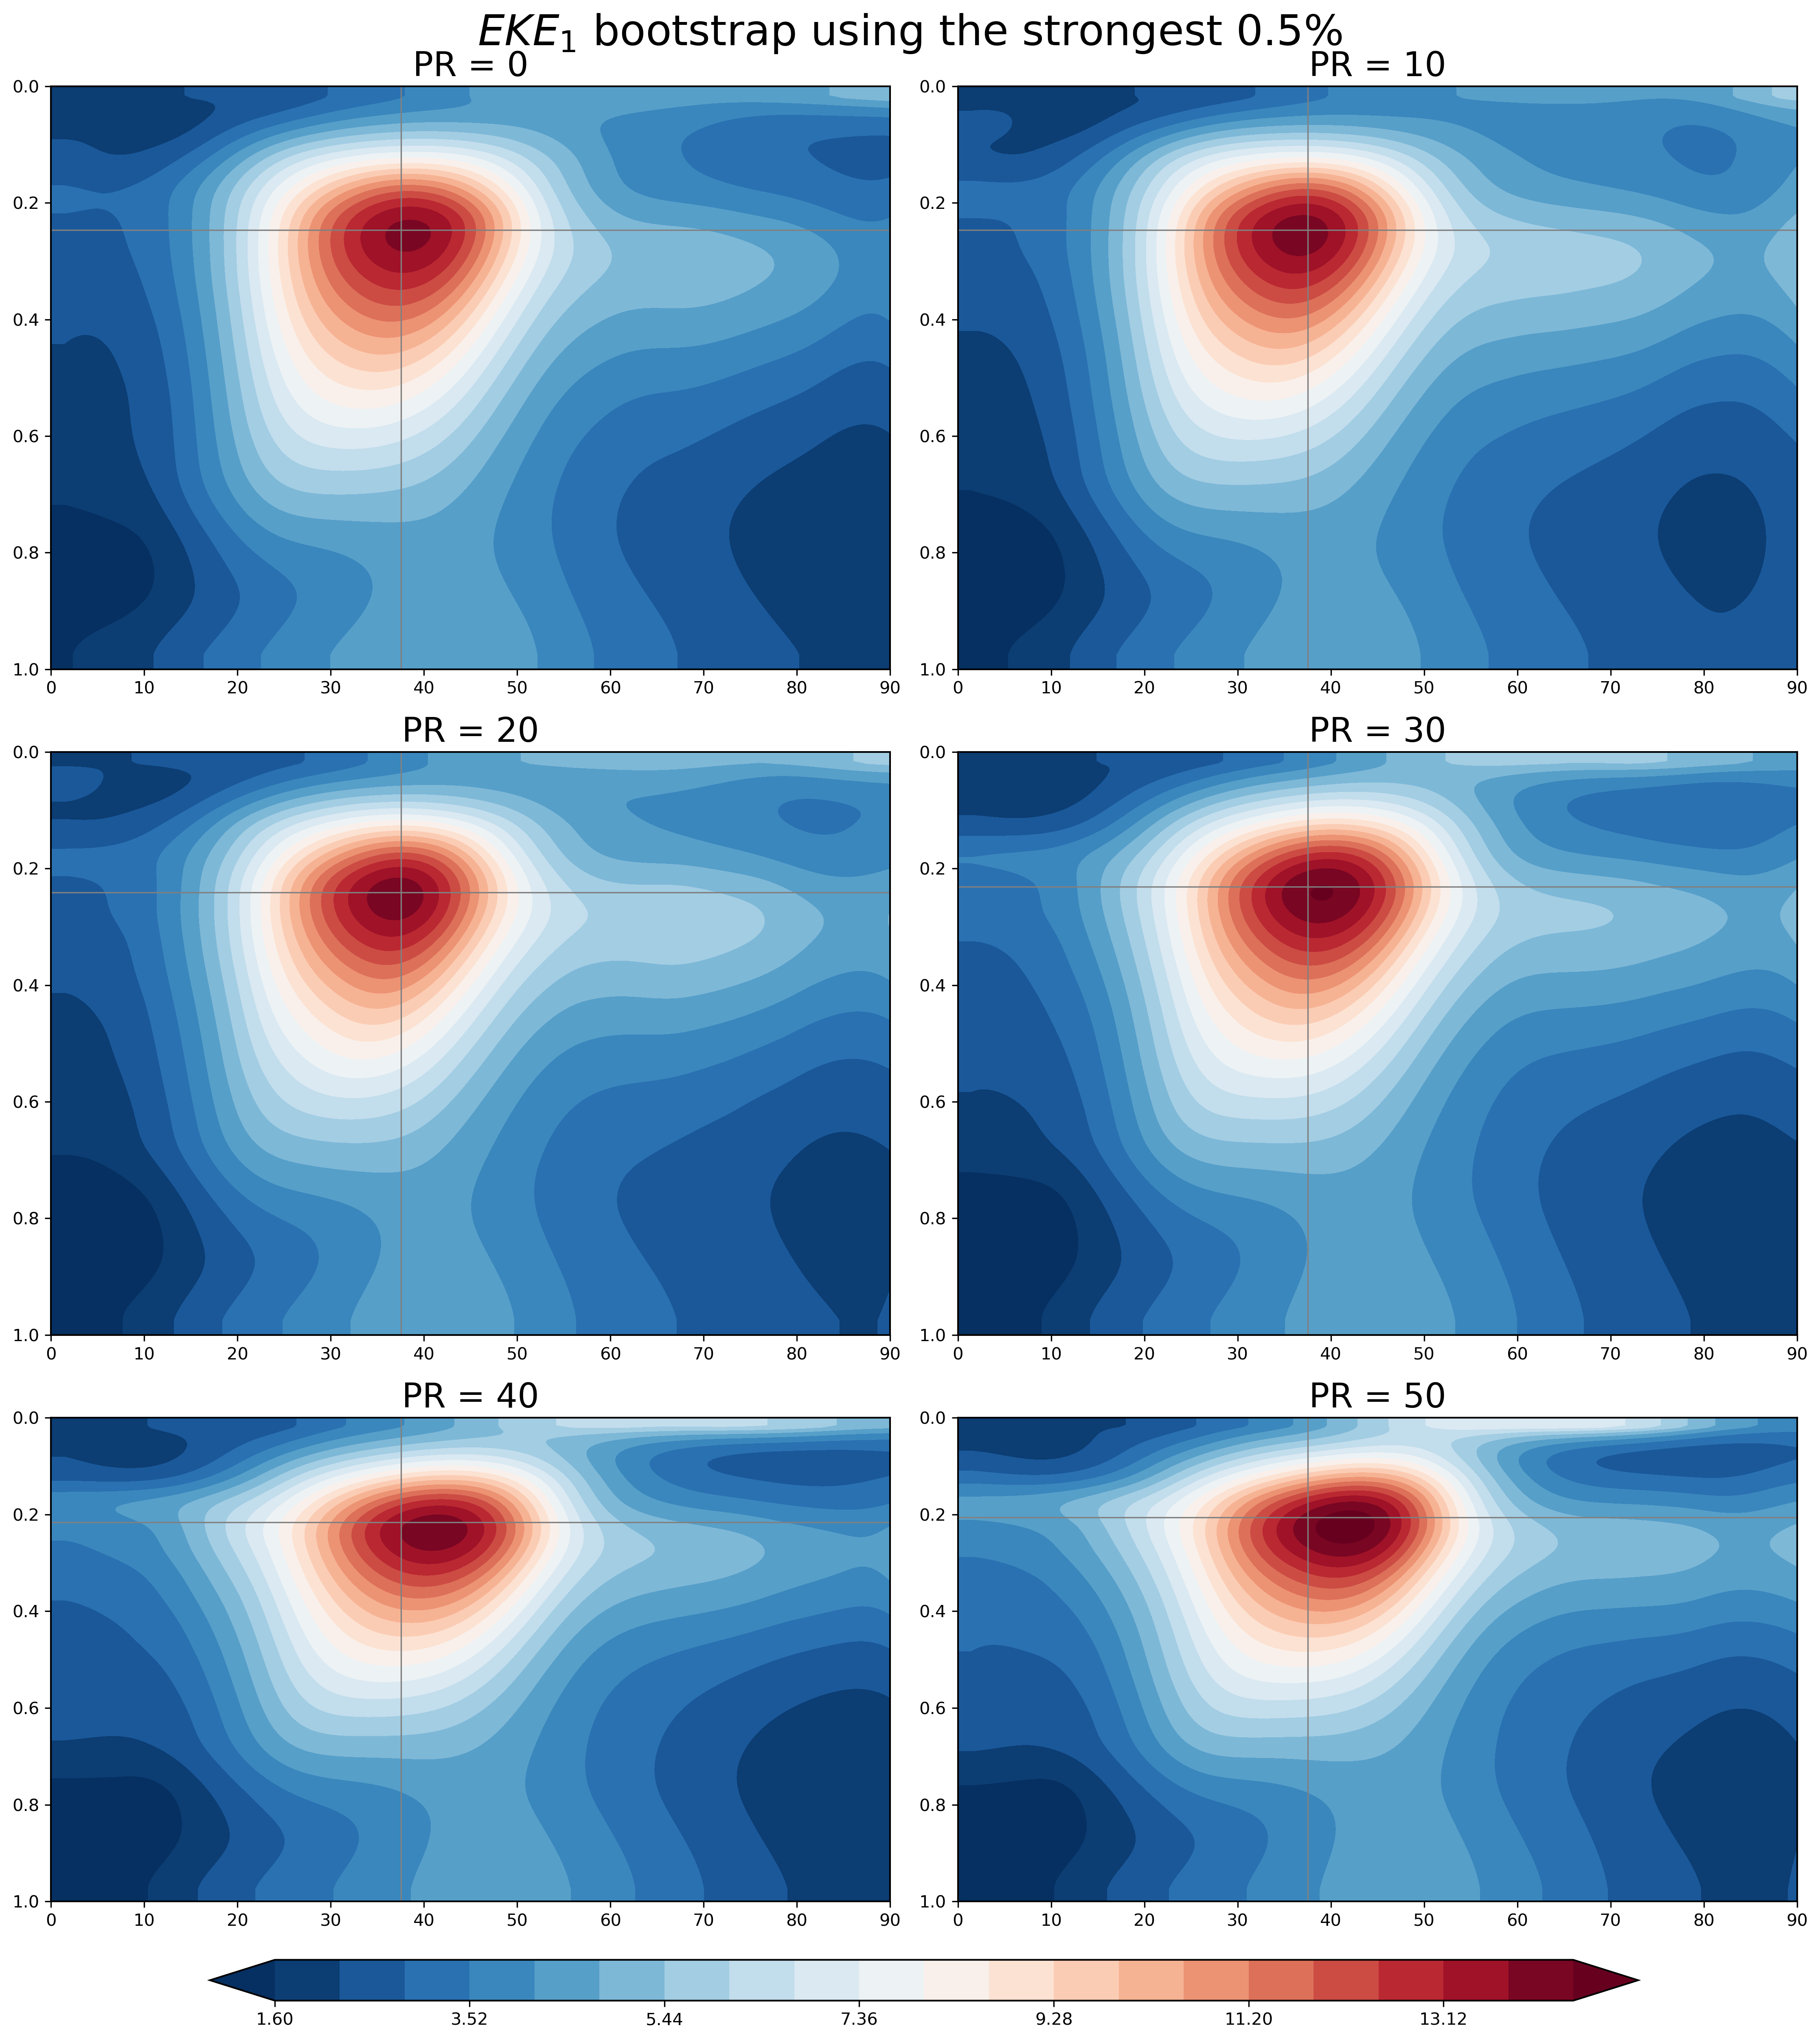

In [915]:
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,25), dpi=100.)
    for i in range(total_pr):
        pr = i*pr_leap
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EKE_thin_check[i,:,:], levels=np.linspace(-0.5,14,21), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{EKE}$")
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    plt.show()
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    pr = 0
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EKE_thin_check[int(pr/pr_leap),:,:], levels=np.linspace(1.6,14.4,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += pr_leap
    plt.suptitle("$EKE_{1}$ bootstrap using the strongest 0.5%", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig(f"05bootstrap_EKE_PR{pr_start}_{int(pr_to-pr_leap)}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()

In [405]:
# fig, ax = plt.subplots(8, figsize=(5,25), dpi=100.)
for i in range(8):
    print(np.nanmax(EKE_thin_check[i,:,:]))

12.426541478492267
12.302977262100752
12.681620624716288
12.796253347982908
12.71662669886624
12.763383913390413
12.795838636904588
12.463383023760736


In [861]:
pr_start = 0
pr_leap = 5
pr_to = 40

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
total_pr  = int((pr_to - pr_start) / pr_leap)
print(total_day)
print(total_pr)

800
8


In [886]:
check_05percentage = True
check_1percentage  = False
check_5percentage  = False
check_10percentage = False
if check_05percentage:
    if pr_leap ==5:
        y_pr0 = 37.53855211598746
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[2] = 0.245966425879397
        z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[4] = 0.2404396827889447
        z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[6] = 0.2302165672110553
        z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[8] = 0.21822737123115576
        z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[10] = 0.20429698492462314
        
        
    else:
        y_pr0 = 37.53855211598746
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        # z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[1] = 0.245966425879397
        # z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[2] = 0.2404396827889447
        # z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[3] = 0.2302165672110553
        # z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[4] = 0.21822737123115576
        # z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[5] = 0.20429698492462314

if check_1percentage:
    if pr_leap == 5:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.2504103093592965
        z_biggest_all[2] = 0.25088522298994975
        z_biggest_all[3] = 0.24788092807788945
        z_biggest_all[4] = 0.24516175408291457
        z_biggest_all[5] = 0.23950071451005026
        z_biggest_all[6] = 0.23397497644472362
        z_biggest_all[7] = 0.2242414337311558
        z_biggest_all[8] = 0.21955492305276383
        z_biggest_all[9] = 0.21416552292713567
        z_biggest_all[10] = 0.20697050879396983
    else:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.25088522298994975
        z_biggest_all[2] = 0.24516175408291457
        # z_biggest_all[3] = 0.23397497644472362
        # z_biggest_all[4] = 0.21955492305276383
        # z_biggest_all[5] = 0.20697050879396983
    
    
if check_10percentage:
    y_pr0 = 36.228926875979624
    z_biggest_all = np.zeros(total_pr)
    z_biggest_all[0] = 0.3238856163630653
    z_biggest_all[1] = 0.32541720398869345
    z_biggest_all[2] = 0.33223640625
    z_biggest_all[3] = 0.3252315201005025
    z_biggest_all[4] = 0.32447135364321605
    z_biggest_all[5] = 0.3121236958228643
    z_biggest_all[6] = 0.3052737688442211
    z_biggest_all[7] = 0.2859219904208543

if check_5percentage:
    y_pr0 = 36.5939329937304
    z_biggest_all = np.zeros(total_pr)
    z_biggest_all[0] = 0.28572386149497486
    z_biggest_all[1] = 0.2872950973618091
    z_biggest_all[2] = 0.29088036903266334
    z_biggest_all[3] = 0.2857038599246231
    z_biggest_all[4] = 0.2842567258165829
    z_biggest_all[5] = 0.27495892430904517
    z_biggest_all[6] = 0.2675492022613066
    z_biggest_all[7] = 0.252779739321608

In [887]:
print(z_biggest_all)
print(biggest_u_z_idx)

[0.32388562 0.3254172  0.33223641 0.32523152 0.32447135 0.3121237
 0.30527377 0.28592199 0.         0.         0.         0.        ]
47


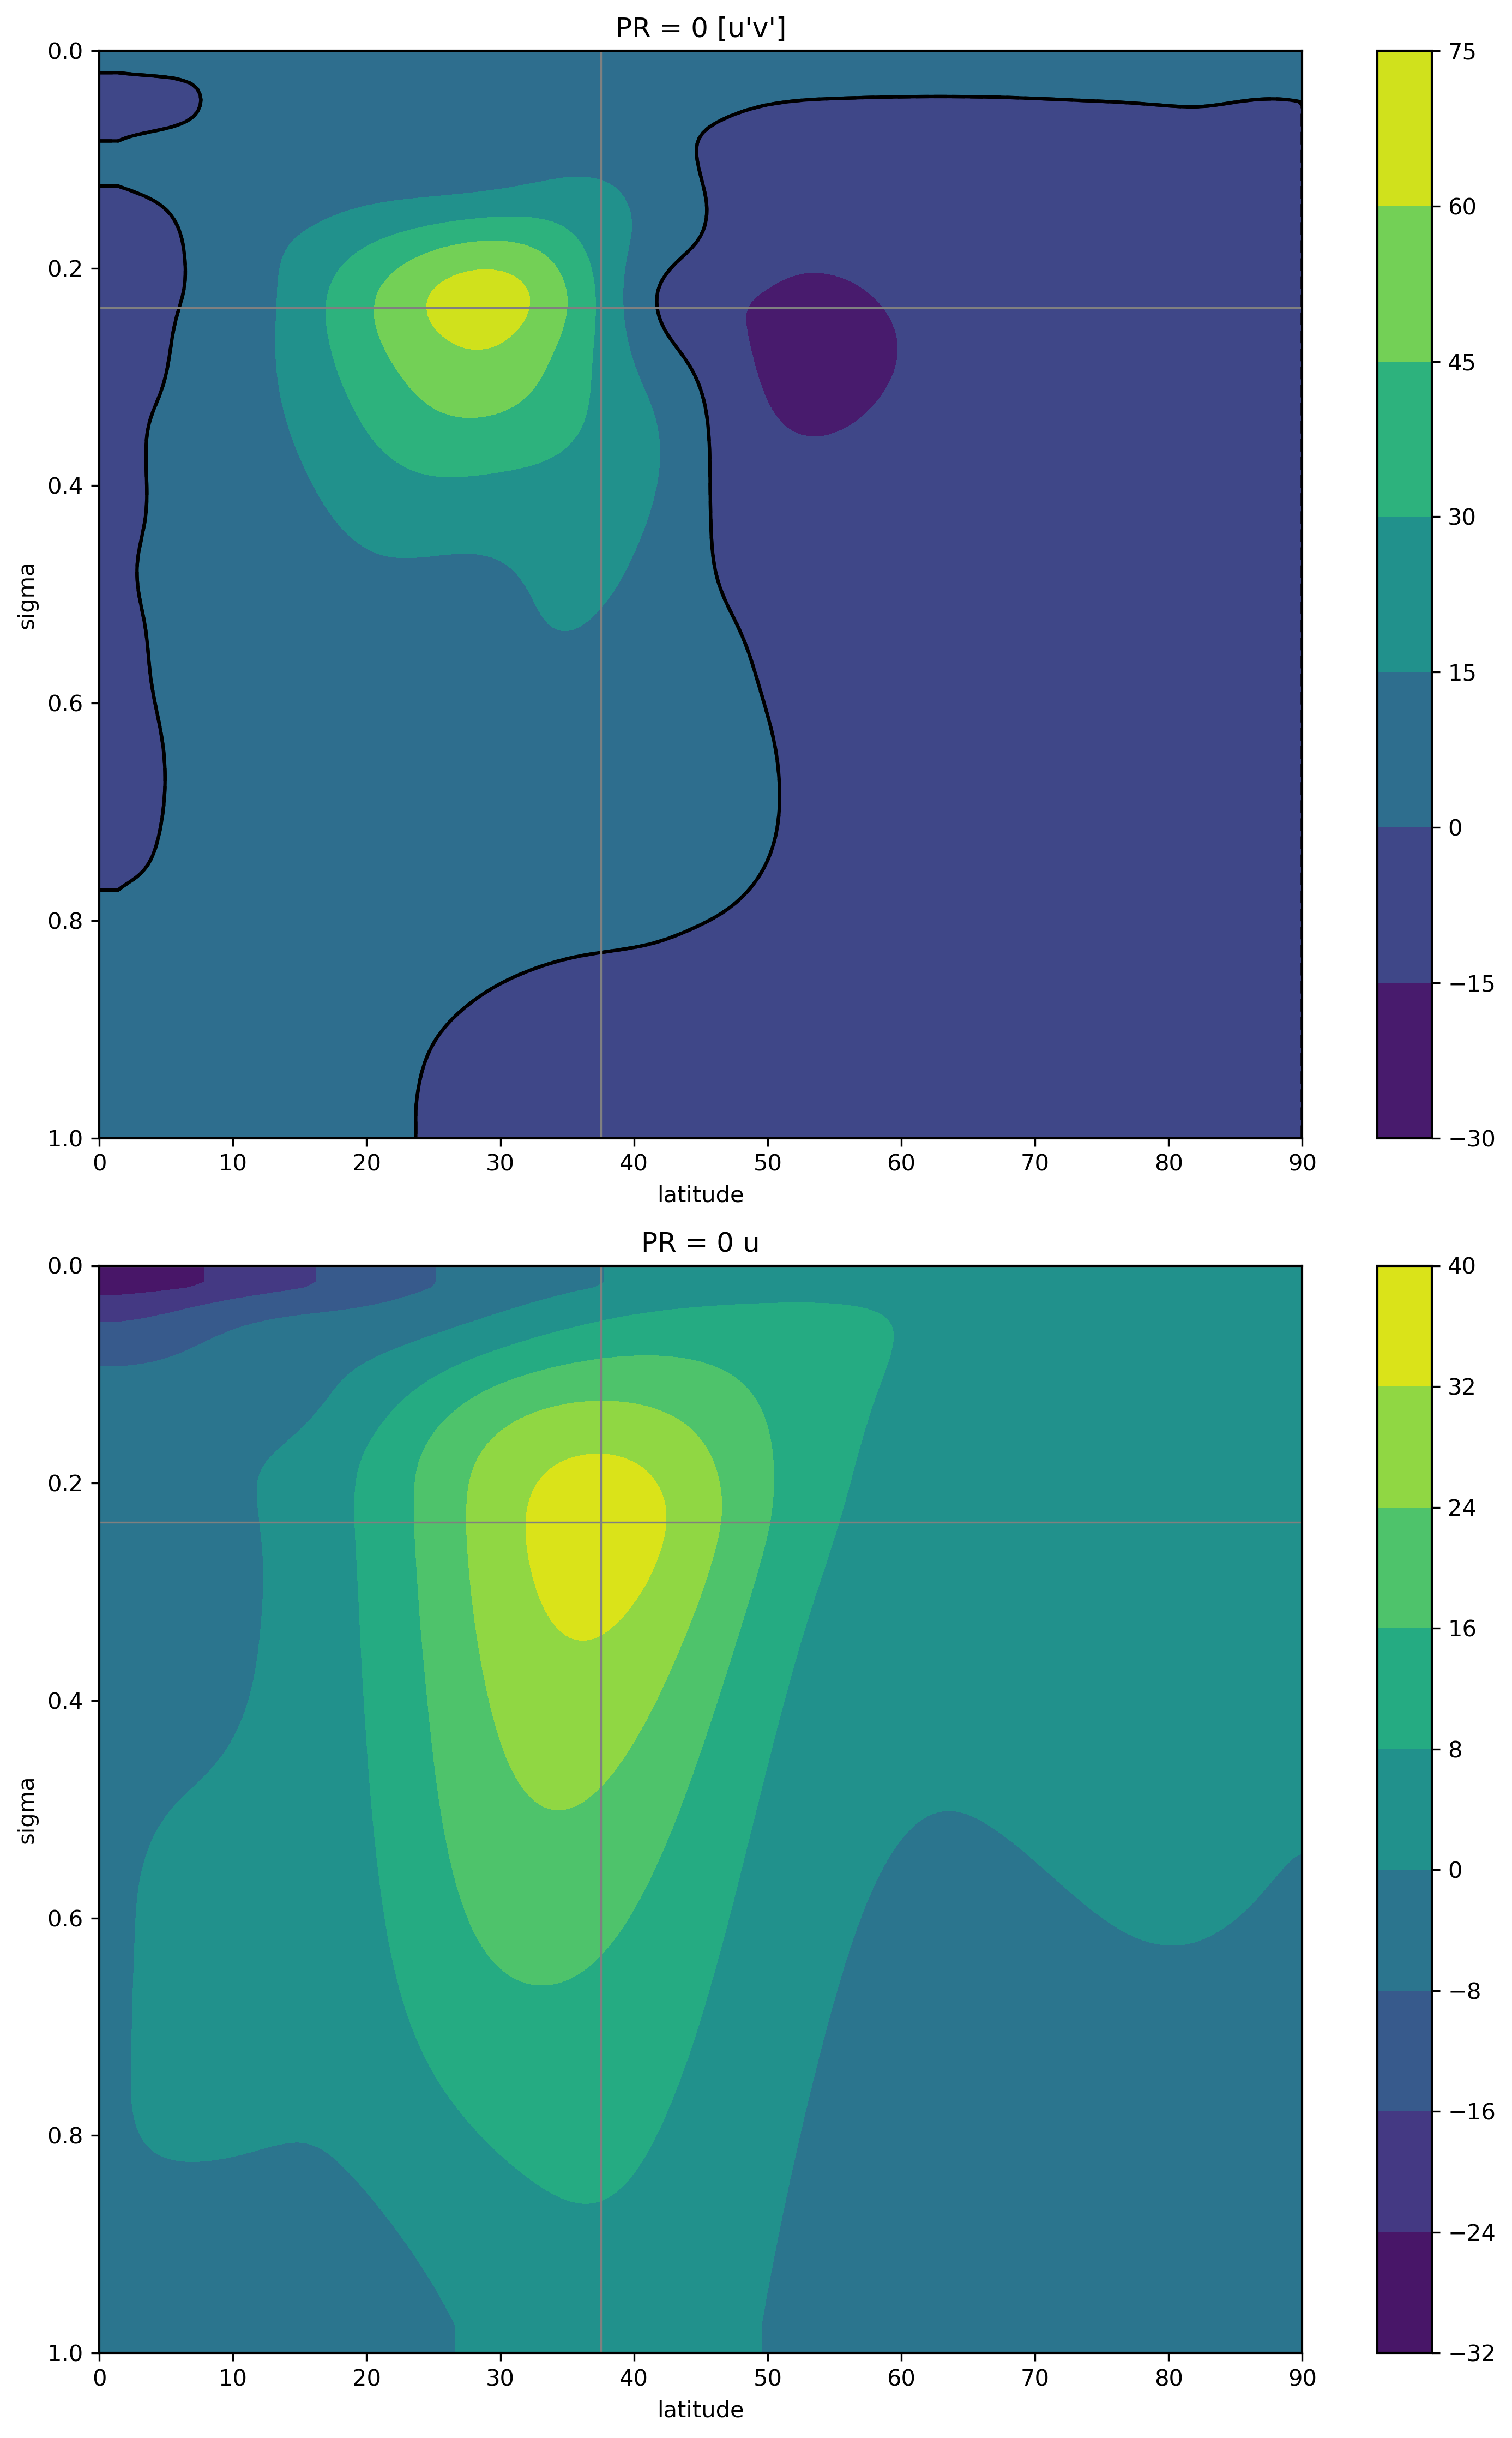

In [888]:
yys_2d, sigma_mean2s_2d = np.meshgrid(yys, sigma_mean2s)
fig, ax = plt.subplots(2, figsize=(10, 15), dpi=300.)

CS = ax[0].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], Mzmtm_thin_w)
ax[0].contour(yys_2d[:,:], sigma_mean2s_2d[:,:], Mzmtm_thin_w, [-0.00000001, 0.], colors='k')
plt.colorbar(CS, ax=ax[0])
ax[0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
ax[0].axhline(y=0, color='gray', lw=0.8)
ax[0].set_ylim([1,0])
ax[0].set_title("PR = 0 [u'v']")
ax[0].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)



CS = ax[1].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_thin_zy)

plt.colorbar(CS, ax=ax[1])

ax[1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
ax[1].axhline(y=0, color='gray', lw=0.8)
ax[1].set_ylim([1,0])
ax[1].set_title("PR = 0 u")
ax[1].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)


# plt.figure()
# CS = ax[2].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], v_thin_zy, levels=21)
# ax[2].contour(yys_2d[:,:], sigma_mean2s_2d[:,:], v_thin_zy, [-0.00000001, 0.], colors='k')
# plt.colorbar(CS, ax=ax[2])
# ax[2].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
# ax[2].axhline(y=0, color='gray', lw=0.8)
# ax[2].set_ylim([1,0])
# ax[2].set_title("PR = 0 v")
# ax[2].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)

for i in range(2):
    ax[i].set_xlabel("latitude")
    ax[i].set_ylabel("sigma")
plt.tight_layout()
plt.show()

PR: 0 ,maximum [z index, y index]: 64 128
PR: 5 ,maximum [z index, y index]: 65 128
PR: 10 ,maximum [z index, y index]: 66 128
PR: 15 ,maximum [z index, y index]: 65 128
PR: 20 ,maximum [z index, y index]: 65 128
PR: 25 ,maximum [z index, y index]: 62 128


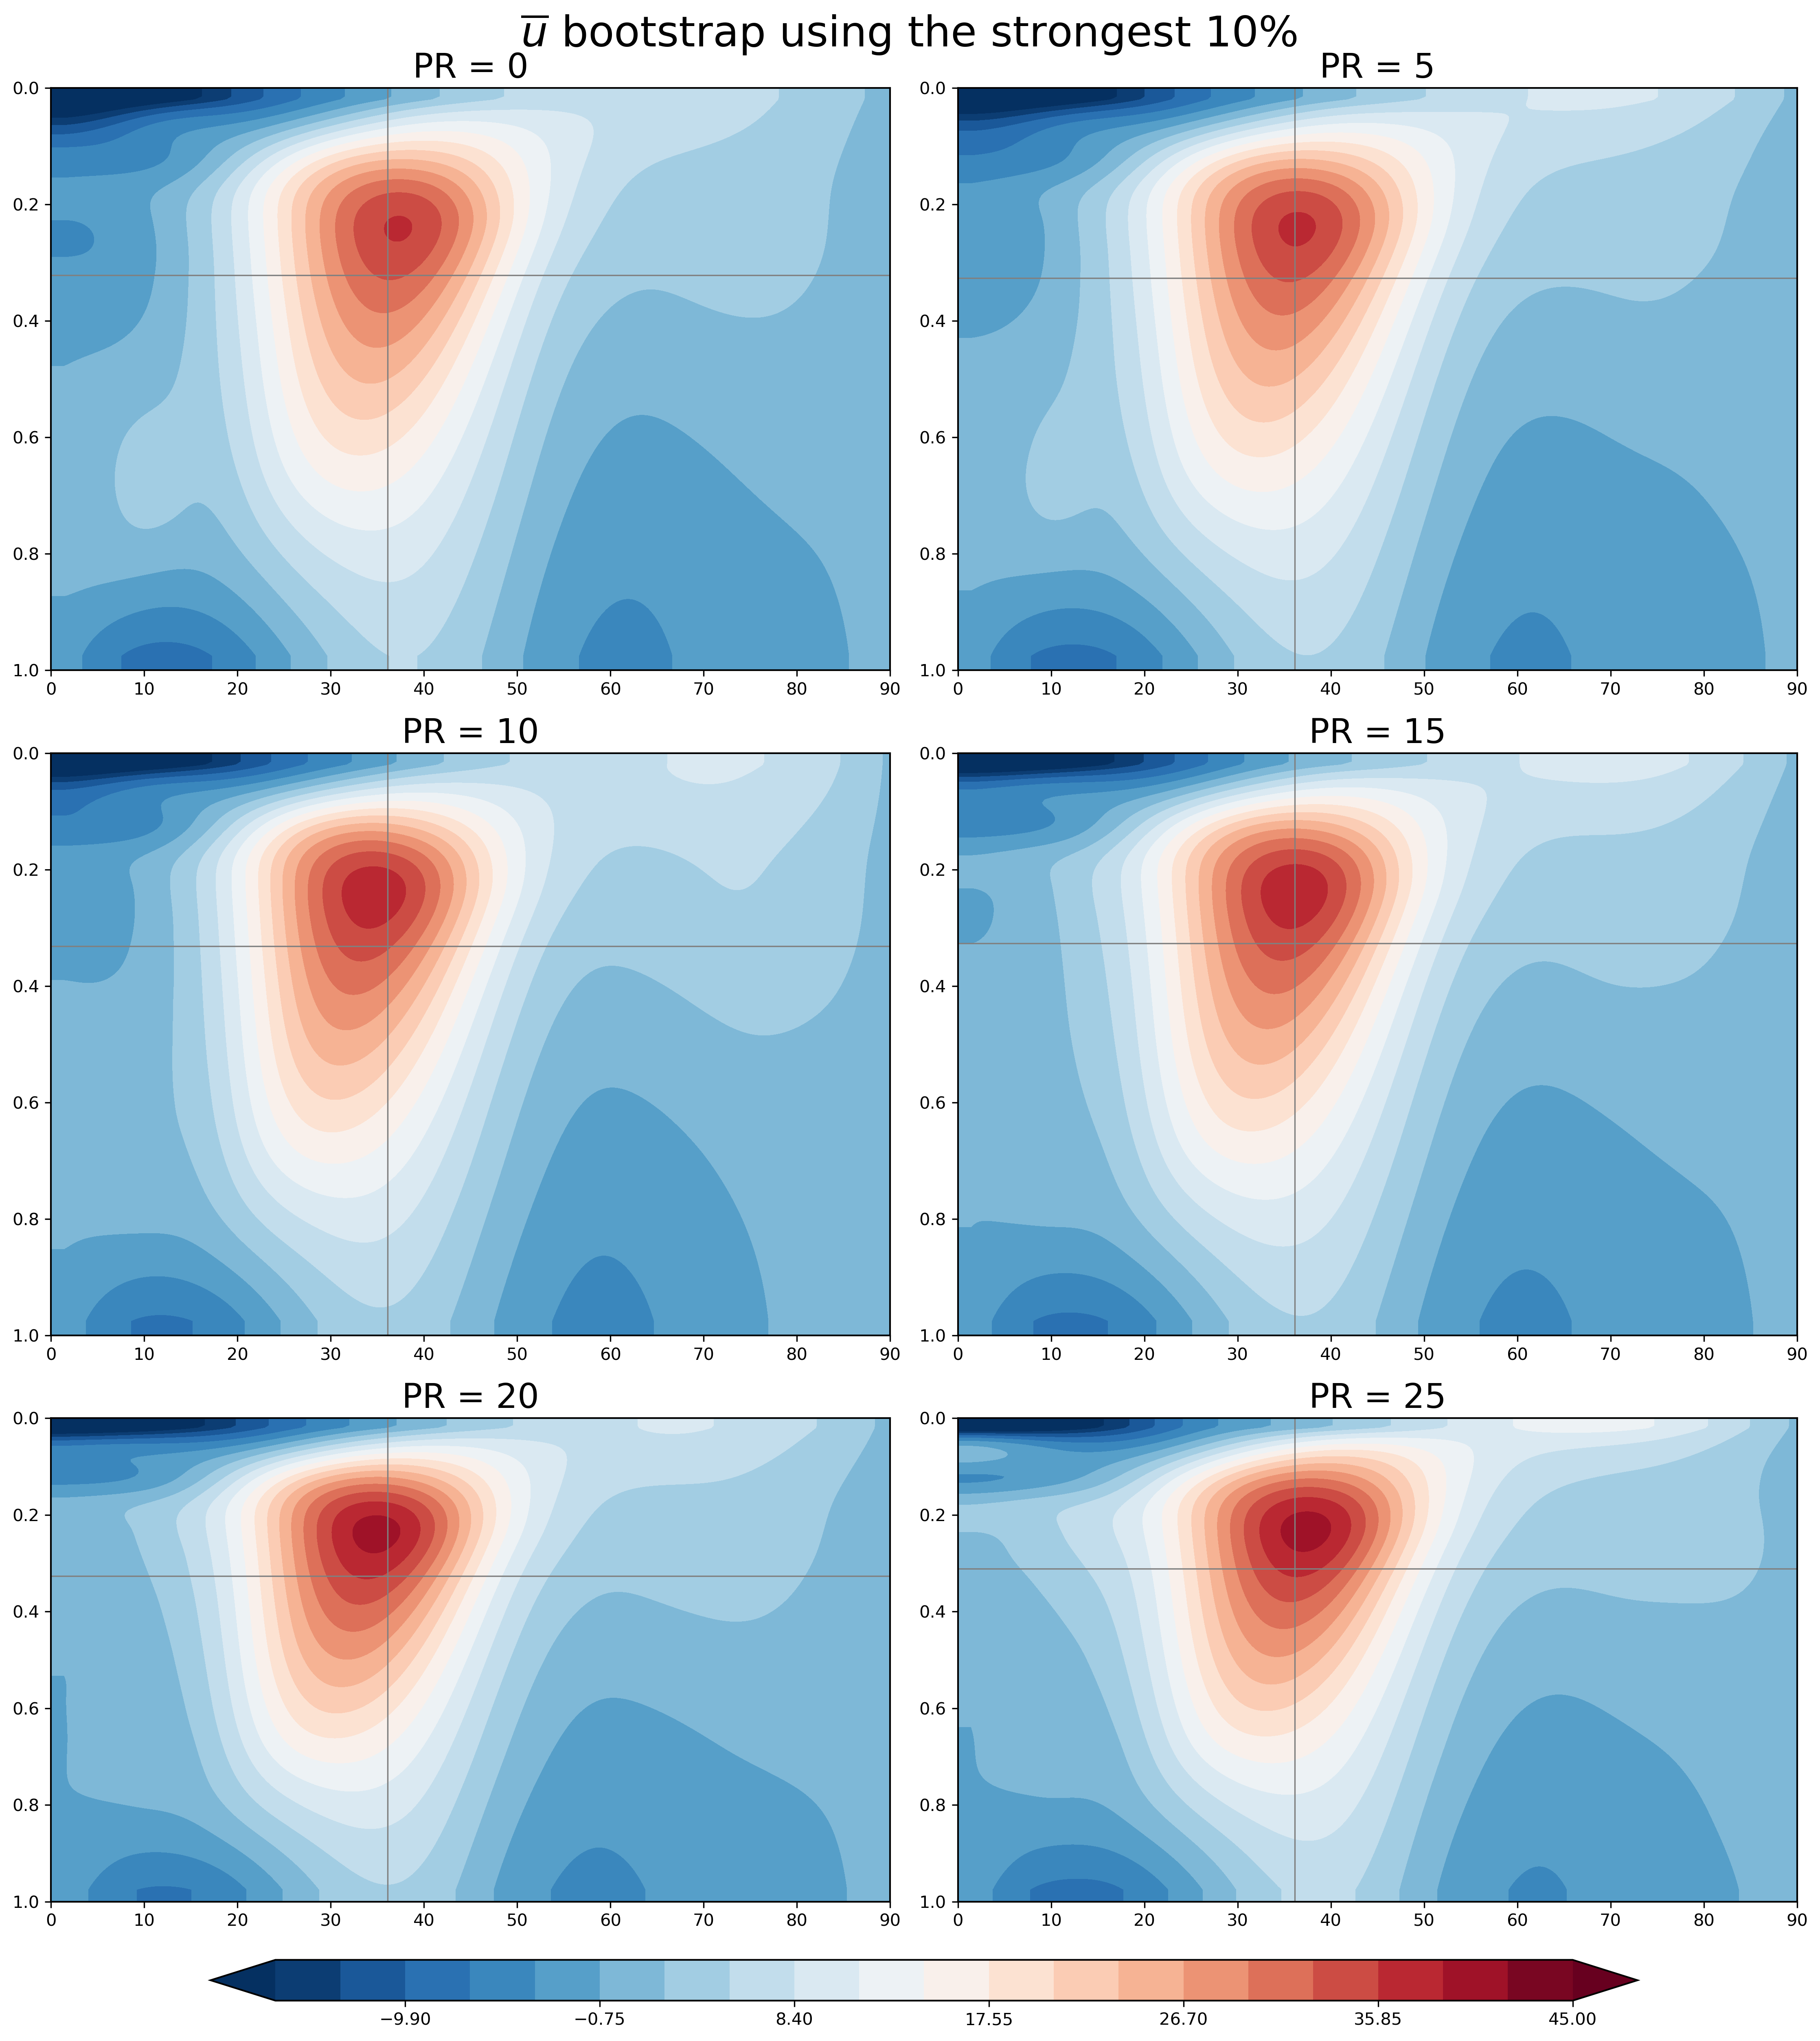

In [891]:
just_check = False
want_output_pic = True
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,25), dpi=100.)
    mpl.rcParams['axes.linewidth'] = 1
    
    for i in range(total_pr):
        pr = i*pr_leap
        biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
        biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
        print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[i,:,:], levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{u}$", fontsize=16)
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    # plt.savefig("U_PR0_50.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()
    
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    mpl.rcParams['axes.linewidth'] = 1
    pr = 0 
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[int(pr/5),:,:], levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += 5
    plt.suptitle("$\overline{u}$ bootstrap using the strongest 10% ", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig("10percentage_U_PR0_25.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()


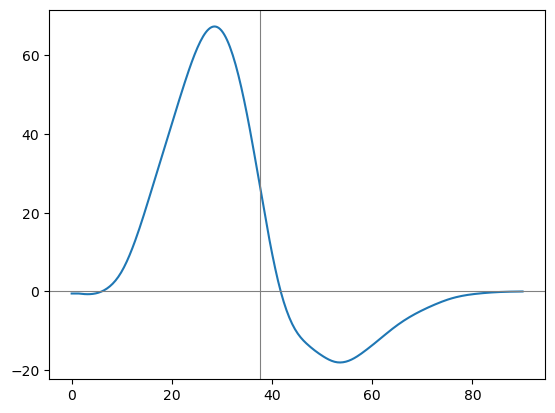

In [495]:
plt.figure()
plt.plot(yys, Mzmtm_thin_w[biggest_u_z_idx,:])
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.axhline(y=0, color='gray', lw=0.8)

In [497]:
dmdy = np.zeros((20*interpolation_times,32*interpolation_times))
r = 6371e3
for i in range(1,32*interpolation_times-1):
    dmdy[:,i] = -(Mzmtm_thin_w[:,i+1] - Mzmtm_thin_w[:,i-1]) / (r * (yys[i+1] - yys[i-1]))
dmdy[:, 0] = -(Mzmtm_thin_w[:, 1] - Mzmtm_thin_w[:, 0]) / (r*(yys[ 1] - yys[ 0]))
dmdy[:,-1] = -(Mzmtm_thin_w[:,-1] - Mzmtm_thin_w[:,-2]) / (r*(yys[-1] - yys[-2]))

(1.0, 0.0)

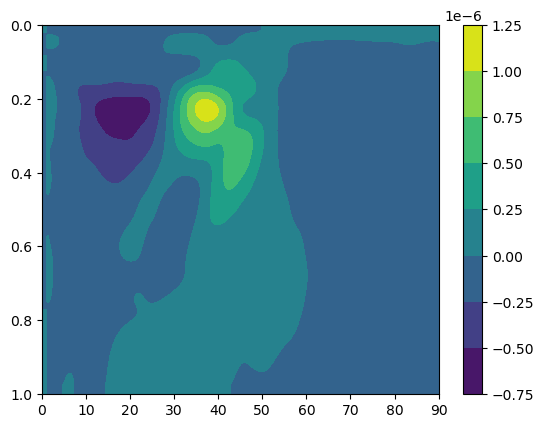

In [498]:
plt.figure()
CS = plt.contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], dmdy)
plt.colorbar(CS)
plt.ylim([1,0])

(200,)
(200, 320)


(1.0, 0.0)

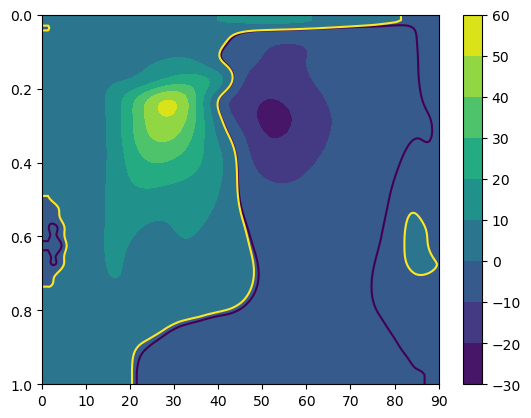

In [501]:
print(np.shape(sigma_mean2s))
yys_2d, sigma_mean2s_2d = np.meshgrid(yys, sigma_mean2s)
print(np.shape(yys_2d))
plt.figure()
CS = plt.contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], np.nanmean(M, axis=(0,3)))
plt.contour(yys_2d[:,:], sigma_mean2s_2d[:,:], np.nanmean(M, axis=(0,3)), [-0.5,0])

plt.colorbar(CS)
plt.ylim([1,0])

# try

In [1297]:
# read variables
from scipy.fftpack import fft,ifft,fftfreq
# file  = f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
# file  = "HSt42_0/RH80_PR0_1000day_startfrom_900day_final.dat"


# dycore = Dycore(file)
# u  = dycore.getVar("grid_u_c_xyzt")
# v  = dycore.getVar("grid_v_c_xyzt")
# t  = dycore.getVar("grid_t_c_xyzt")
# ps = dycore.getVar("grid_ps_c_xyzt")
# p  = dycore.getVar("grid_p_full_xyzt")
sigma = p / ps
sigma_mean  = np.nanmean(sigma, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
Rd = 287
cp = 1004
g = 9.81
theta      = t * (ps / p)**(Rd/cp)
H = 6800
a = 6.37122e6

In [1298]:
# # The edition without time mean
# def plot_V_W_50(pr):
#     # file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     file  = "HSt42_10/RH80_PR10_1000day_startfrom_900day_final.dat"

#     dycore = Dycore(file)
#     # u  = dycore.getVar("grid_u_c_xyzt")
#     v  = dycore.getVar("grid_v_c_xyzt")
#     t  = dycore.getVar("grid_t_c_xyzt")
#     ps = dycore.getVar("grid_ps_c_xyzt")
#     p  = dycore.getVar("grid_p_full_xyzt")
#     sigma = p / ps
#     sigma_mean = np.nanmean(sigma, axis=(0,3))
#     sigma_onlyz = np.nanmean(sigma_mean, axis=1)
#     Rd = 287
#     cp = 1004
#     g = 9.81
#     theta             = t * (ps / p)**(Rd/cp)
#     H = 6800
#     # p0 = 100000
#     a = 6.37122e6
    
#     # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
#     # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
#     # Z_all     = H * np.log(p0/p)
#     rho_0     = np.zeros((20,64))
#     rho_0_all = np.zeros(((100,20,64)))
#     for i in range(0,20):
#         rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
#         rho_0_all[:,i,:] = np.nanmean(p[:,i,:,:], axis=2) / np.nanmean(ps[:,0,:,:], axis=2)                  # np.exp(-Z_all[:,i,:,:]/H) 
#     omega  = (dycore.getVar("grid_w_full_xyzt"))
#     w = omega  
#     ### do dz by dz = H * ln(ps/p)
#     THzm = np.nanmean(theta, axis=(3)) ######################
#     THETAz  = np.zeros(((100,20,64))) ############ 
#     p_onlyz = np.nanmean(p, axis=(0,2,3))
#     for i in range(1,19):
#         THETAz[:,i,:] = (THzm[:,i+1,:] - THzm[:,i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1]) #########
#     THETAz[:,0,:]  = (THzm[:,1,:]  - THzm[:,0,:])  /  (p_onlyz[1] - p_onlyz[0])
#     THETAz[:,-1,:] = (THzm[:,-1,:] - THzm[:,-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
#     THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
#     Vza = np.zeros(u.shape)
#     THETAza = np.zeros(u.shape)
#     Wza = np.zeros(u.shape)
    
#     Vzm = np.nanmean(v, axis=3)
#     THzm = np.nanmean(theta, axis=3)
#     for i in range(0,128):
#         Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
#         THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
#     VTHETA = Vza * THETAza
#     VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
#     # VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
#     Wzm = np.nanmean(w, axis=3)
#     Wzmtm = np.nanmean(Wzm, axis=0)
#     Vzm = np.nanmean(v, axis=(3)) #########
    
#     # phi
#     lat   = np.linspace(-90, 90, 64)
#     phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
#     lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
#     cphi  = np.cos(phi) 
#     acphi = a * cphi

#     # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
#     vTEM_temp = rho_0_all * VTHzm / THETAz ############################################
#     vTEM_tempdz = np.zeros(((100,20,64)))
#     for i in range(1,19):
#         vTEM_tempdz[:,i,:] = (vTEM_temp[:,i+1,:] - vTEM_temp[:,i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
#     vTEM_tempdz[:,0,:]  = (vTEM_temp[:,1,:]  - vTEM_temp[:,0,:]) /  (p_onlyz[1] - p_onlyz[0])
#     vTEM_tempdz[:,-1,:] = (vTEM_temp[:,-1,:] - vTEM_temp[:,-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
#     vTEM1 = Vzm #################
#     vTEM2 = (1/rho_0_all) * vTEM_tempdz
#     vTEM  = vTEM1 - vTEM2
#     # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
#     wTEM_temp =  cphi * VTHzm / THETAz ############################################
#     wTEM_tempdphi = np.zeros(((100,20,64)))
#     for i in range(1,63):
#         wTEM_tempdphi[:,:,i] = (wTEM_temp[:,:,i+1] - wTEM_temp[:,:,i-1]) / (phi[:,i+1] - phi[:,i-1])
#     wTEM_tempdphi[:,:,0]  = (wTEM_temp[:,:,1] - wTEM_temp[:,:,0]) /  (phi[:,1]  - phi[:,0])
#     wTEM_tempdphi[:,:,-1] = (wTEM_temp[:,:,-1] - wTEM_temp[:,:,-2]) / (phi[:,-1] - phi[:,-2])
    
#     wTEM1 = Wzm ##################
#     wTEM2 = (wTEM_tempdphi) /acphi
#     wTEM = wTEM1 + wTEM2

#     return vTEM,wTEM,p, ps, Wzmtm, rho_0
# vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(10)
# print("over")


In [1299]:
pr_start = 0
pr_leap = 5
pr_to = 5
nProc = 2

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
print(total_day)


qv = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))

### fig
y = np.linspace(-90,90,64)
time = np.linspace(start, end, total_day)
yy, tt = np.meshgrid(y,time)
a      = int(0)
# fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
#########

do_check_qv = True
do_check_KE = True
do_check_t  = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_qv:
            if k ==0:
                qv[0:100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[0:100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[0:100,:,:,:]       = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]      = ps_ini[k,:,:,:,:]
                p_half[0:100,:,:,:]  = p_half_ini[k,:,:,:,:]            
            else:
                qv[k*100:(k+1)*100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:]       = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:]      = ps_ini[k,:,:,:,:]
                p_half[k*100:(k+1)*100,:,:,:]  = p_half_ini[k,:,:,:,:]
                
        if do_check_KE:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]            = ps_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:]  = u_ini[k,:,:,:,:]
                v[k*100:(k+1)*100,:,:,:]  = v_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:]  = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                
        if do_check_t:
            if k ==0:
                t[0:100,:,:,:]           = t_ini[k,:,:,:,:]
            else:
                t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
print("done")

800
done


In [1300]:
# print(vTEM.shape)
# cal zonal mean and zonal anamoly
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)

x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm  

In [1301]:
# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan

In [1302]:
u.shape

(800, 20, 64, 128)

In [1303]:
### try to calculate balanced partial u partial t, which is calculated by TEM equation.
# first calculate zonal (v'q') (q is potential vorticity)
# v  = dycore.getVar("grid_v_c_xyzt")
# u  = dycore.getVar("grid_u_c_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
ps = dycore.getVar("grid_ps_c_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
Rd = 287
cp = 1004

theta = t * (ps / p)**(Rd/cp)

Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
THzm = np.nanmean(theta, axis=3)
# THvm = np.nanmean(theta, axis=1)
Pzm = np.nanmean(p, axis=3)
Tzm = np.nanmean(t, axis=3)

In [1304]:
Vzmtm  = np.nanmean(Vzm, axis=0)
Uzmtm  = np.nanmean(Uzm, axis=0)
THzmtm = np.nanmean(THzm, axis=0)
# THvmtm = np.nanmean(THvm, axis=0)
Pzmtm  = np.nanmean(Pzm, axis=0)
Tzmtm  = np.nanmean(Tzm, axis=0)

Vza     = np.zeros(u.shape)
Uza     = np.zeros(u.shape)
THETAza = np.zeros(t.shape)
Pza = np.zeros(t.shape)
Tza = np.zeros(t.shape)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
    # THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
    Pza[:,:,:,i]     = p[:,:,:,i] - Pzm
    Tza[:,:,:,i]     = t[:,:,:,i] - Tzm
    
M = Uza * Vza
Mzm = np.nanmean(M, axis=(3))

# for i in range(1,64-1):
#     Mzm[:,:,i] = cy[i]**0.5 * Mzm[:,:,i]

dmdy = np.zeros(((np.shape(u)[0],20,64)))
r = 6371e3
for i in range(1,64-1):
    dmdy[:,:,i] = -(Mzm[:,:,i+1] - Mzm[:,:,i-1]) / (r * (yd[i+1] - yd[i-1]))
dmdy[:,:, 0] = -(Mzm[:,:, 1] - Mzm[:,:, 0]) / (r*(yd[ 1] - yd[ 0]))
dmdy[:,:,-1] = -(Mzm[:,:,-1] - Mzm[:,:,-2]) / (r*(yd[-1] - yd[-2]))
print(dmdy.shape)

(800, 20, 64)


Text(0.5, 1.0, "$\\overline{u'v'}$")

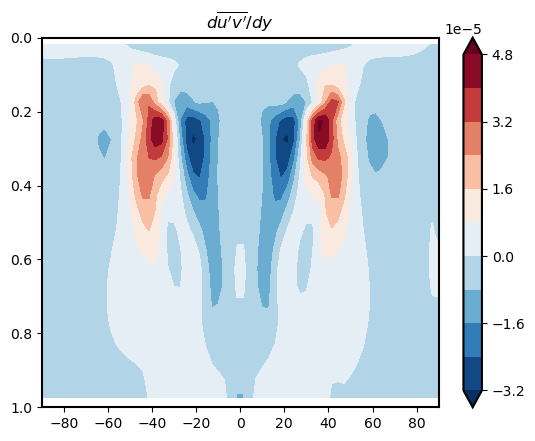

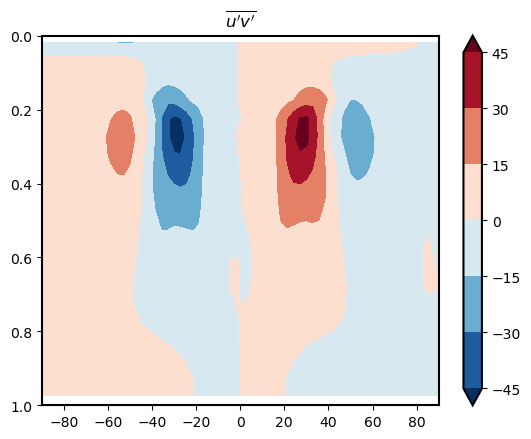

In [1305]:
sigma_mean      = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
# vq_yz = np.nanmean(Vza * qza, axis=(0,3))

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(dmdy, axis=0), levels= 11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$d\overline{u'v'} / dy$")

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(Mzm, axis=0), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{u'v'}$")

In [1306]:
x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xx,yyy = np.meshgrid(x,y)

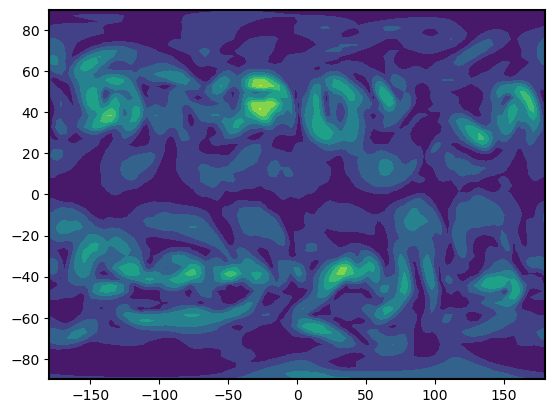

In [1307]:
plt.figure()
KE = (u**2+v**2)**0.5
plt.contourf(xx,yyy,np.nanmean(KE[200:201,-2,:,:], axis=0))

In [1308]:
qv_diff.shape
np.max(qv_diff)

4.6469149429321743e-07

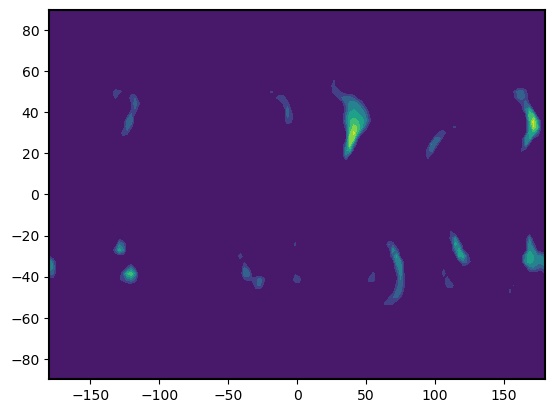

In [1309]:
plt.figure()
plt.contourf(xx,yyy,np.nanmean(qv_diff[200:201,-1,:,:], axis=0))

In [10]:
##################################################################
def plot_contourf_near0_fixcolorbar_one_fig(X, Y ,var_near0, cbar_lim, shading_levels = 9, least_levels = 4, near0white = True, my_cmap = 'coolwarm'):
    from matplotlib.colors import ListedColormap
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm
    #####
    import matplotlib.colors as colors
    a, antialiased = 1,  True
#     a, antialiased = 0.7, True
#     a, antialiased = 0.9, True
#     a, antialiased = 1, False
    
    my_cmap = plt.colormaps[my_cmap]  
    
    # create random data with cbar_lim
    rngdata = np.random.uniform(low=cbar_lim[0], high=cbar_lim[1], size=(len(Y),len(X)))
    print(np.shape(rngdata))
    # make sure the min and Max value are included
    rngdata[0,0] = cbar_lim[0]
    rngdata[-1,-1] = cbar_lim[1]
    
    # get contour levels with random data
    cs = plt.contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)

    # i, j = 0,0
    # cs = ax[i,j].contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    # plt.invert_yaxis()
    
    
    auto_levels_rng = cs.levels.copy()
    plt.gca().clear()

    cs = plt.contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    # cs = ax[i,j].contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    auto_levels2 = cs.levels.copy()
    #cbar = add_colorbar(cs)#plt.colorbar()
    #plt.show()

    if ~((np.min(auto_levels2) >= 0) | (np.max(auto_levels2) <= 0)):
        plt.gca().clear()
        
        try:
            cbar.remove()
        except:
            pass
        
        # check levels of both ends
        # if either end has contour levels less than 'least_levels', create custom levels
        if ((len(np.where(auto_levels2 > 0)[0]) < least_levels) | (len(np.where(auto_levels2 < 0)[0]) < least_levels)):
            cs = plt.contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            # cs = ax[i,j].contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            auto_levels1 = cs.levels.copy()
        #     plt.colorbar()
        #     plt.show()
            plt.gca().clear()
            if (len(np.where(auto_levels2 > 0)[0]) > len(np.where(auto_levels2 < 0)[0])):
                   custom_levels = np.concatenate((np.linspace(np.min(auto_levels1), 0, least_levels+1), 
                                    auto_levels2[auto_levels2 > 0]))

            else:
                   custom_levels = np.concatenate((auto_levels2[auto_levels2 < 0], 
                                               np.linspace(0,np.max(auto_levels1),least_levels+1)))

            #custom_levels = np.unique(custom_levels)
            custom_levels_bar = custom_levels
        else:

            custom_levels = auto_levels2
            custom_levels_bar = custom_levels

        # create white shading around 0
        if near0white:
            custom_lower = custom_levels[custom_levels < 0]
            dlevel_lower = custom_lower[1] - custom_lower[0]
            custom_lower_near0 = np.concatenate((custom_lower, [0 - dlevel_lower/5]))

            custom_upper = custom_levels[custom_levels > 0]
            dlevel_upper = custom_upper[1] - custom_upper[0]
            custom_upper_near0 = np.concatenate(([dlevel_upper/5 - 0] ,custom_upper))

            custom_levels_near0 = np.concatenate((custom_lower_near0, [0], custom_upper_near0))

            mycmap_lower_near0 = my_cmap(np.linspace(0, 0.5, len(custom_levels_near0[custom_levels_near0 < 0])))
            mycmap_upper_near0 = my_cmap(np.linspace(0.5, 1, len(custom_levels_near0[custom_levels_near0 >= 0])))[1:]
            all_colors = np.vstack((mycmap_lower_near0, mycmap_upper_near0))

            all_colors[np.where(custom_levels_near0 == 0)[0]] = [1, 1, 1, 1] # set to white
            all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [1, 1, 1, 1]
            
#             all_colors[np.where(custom_levels_near0 == 0)[0]] = [0.85, 0.85, 0.85, 1] # set to gray
#             all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [0.85, 0.85, 0.85, 1]

            #all_colors[:,0:3] *= a


            mycmap_near0 = colors.LinearSegmentedColormap.from_list('mycmap_near0', all_colors)

            custom_levels = custom_levels_near0
            mycmap = mycmap_near0
        else:
            mycmap = my_cmap


        norm = colors.BoundaryNorm(boundaries=custom_levels, ncolors=256)

        cs = plt.contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
        # cs = ax[i,j].contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
        plt.gca().invert_yaxis()
        
        plt.axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        plt.title(f"PR={int(0*10)}", fontsize=16)

#         cbar = plt.colorbar(spacing="proportional")#cbar = add_colorbar(cs, aspect=8, pad_fraction=0.8)#

#         cbar.set_ticks(custom_levels_bar)
#         ticklabs = cbar.ax.get_yticklabels()
#         cbar.ax.set_yticklabels(ticklabs, fontsize=14)
        
    #####
    return custom_levels, custom_levels_bar, cs
########################################################################

In [1311]:
print(np.shape(np.nanmean(Mzm, axis=0)))
print(sigma_onlyz.shape)

(20, 64)
(20,)


In [11]:
_,custom_levels_bar,cs=plot_contourf_near0_fixcolorbar_one_fig(y, sigma_onlyz, np.nanmean(Mzm, axis=0), cbar_lim = [-55, 45], my_cmap="RdBu_r") # ,my_cmap = 'BlueYellowRed'
plt.colorbar(cs)
plt.title("$\overline{u'v'}$, PR=0")

NameError: name 'sigma_onlyz' is not defined

(20, 64)


Text(0.5, 1.0, "$d\\overline{u'v'} / dy$, PR=0")

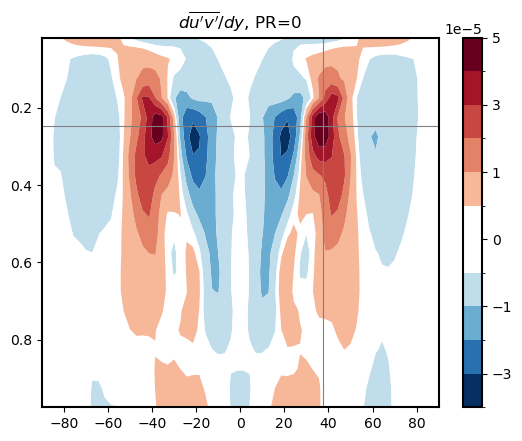

In [1322]:
_, custom_levels_bar,cs=plot_contourf_near0_fixcolorbar_one_fig(y, sigma_onlyz, np.nanmean(dmdy, axis=0), cbar_lim = [-3.5E-5, 4.8E-5], my_cmap="RdBu_r") # ,my_cmap = 'BlueYellowRed'
plt.colorbar(cs)
plt.title("$d\overline{u'v'} / dy$, PR=0")